# IMPORT MODULES

In [2]:
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib
# import dill
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.datasets import make_regression
from scipy.stats import gaussian_kde, spearmanr, pearsonr, gmean
from scipy.interpolate import UnivariateSpline,BivariateSpline
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 3, 3
sns.set(rc={'figure.figsize':(3,3)})
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,median_absolute_error, balanced_accuracy_score
import os
np.random.seed(42)
from tqdm import trange
from IPython.display import Image
from scipy.special import kl_div
import h2o
from h2o.automl import H2OAutoML
import random
import time
from h2o.utils.threading import local_context
from h2o.exceptions import H2ODependencyWarning
warnings.filterwarnings("ignore", category=H2ODependencyWarning)
from imbalance_metrics import regression_metrics as rm

# DATA

In [172]:
rep = r'C:\Users\samgo\OneDrive\Perso\Thèse\Travaux\Survey IR\Résultats\Simus'
os.chdir(rep)

In [173]:
def minmax(z):
    return (z-min(z))/(max(z)-min(z))

In [174]:
def simu_data(n,graine=42, c = 1):
    np.random.seed(graine)
    X0 = np.random.normal(0,1,n)
    X1 = np.random.normal(0,1,n)
    X2 = np.random.normal(0,1,n)
    X3 = np.random.normal(0,1,n)
    X4 = np.random.normal(0,1,n)
    X5 = np.random.normal(np.exp(X0*2)/(1+np.exp(X0*2)),0.01,n)
    X6 = np.random.normal(np.sin(X1*2),0.1,n)
    X7 = np.random.normal(np.cos(X2*2),0.1,n)
    X8 = np.random.normal(X3**2,0.5,n)
    X9 = np.random.normal(X4**2,0.5,n)
    if c == 1:
        PL = minmax(X0) + minmax(X1) + minmax(X2) + minmax(X3) + minmax(X4)
    elif c == 2:
        PL = minmax(X5) + minmax(X1) + minmax(X2) + minmax(X3) + minmax(X4)
    elif c == 3:
        PL = minmax(X5) + minmax(X6) + minmax(X7) + minmax(X3) + minmax(X4)
    elif c == 4:
        PL = minmax(X5) + minmax(X6) + minmax(X7) + 2 * minmax(X8) + 2 * minmax(X9)
    elif c == 5:
        PL = minmax(X5) + minmax(X6) * minmax(X7) + minmax(X8) * minmax(X9)
    Y = np.random.normal(PL,.1)
    return pd.DataFrame(data={'Y': Y, 'X0': X0,'X1': X1,'X2': X2,'X3': X3,'X4': X4,'X5': X5,'X6': X6,'X7': X7,'X8': X8,'X9': X9})

In [175]:
n=10000

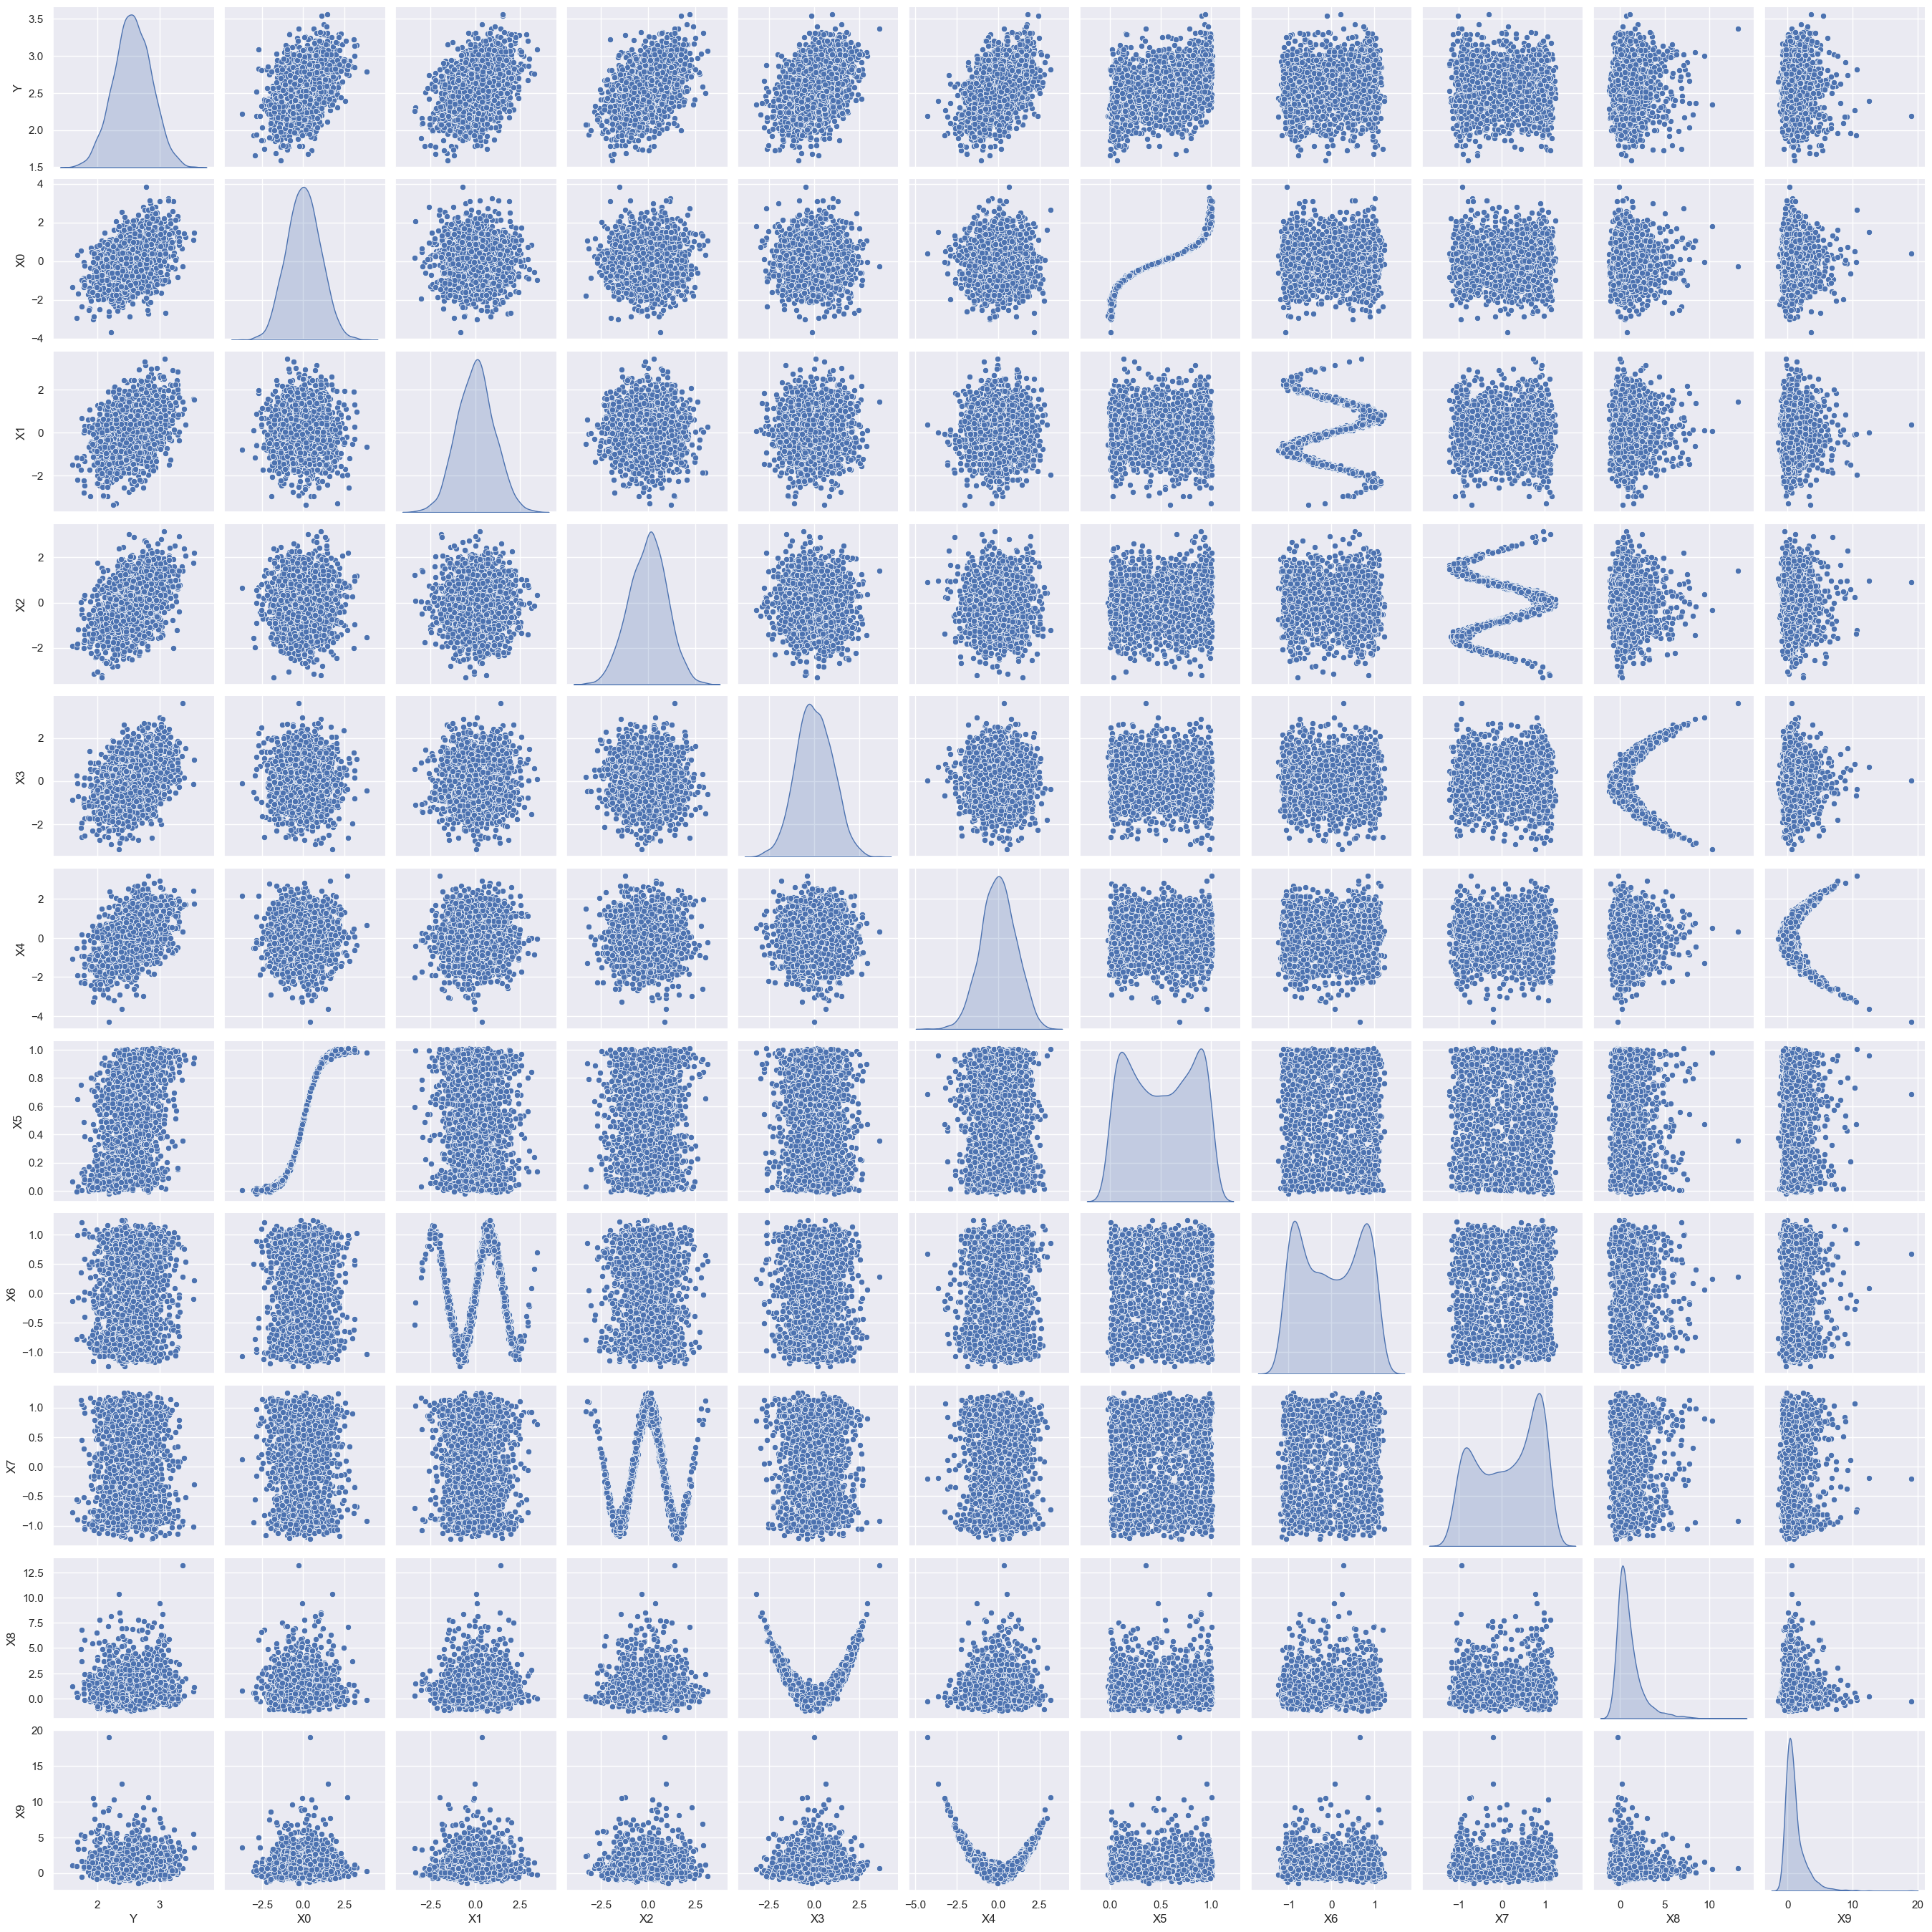

In [176]:
data = simu_data(n, c=1)
X_df = data
data.Y.describe()
sns.pairplot(data.sample(2000), diag_kind="kde")

<Axes: xlabel='Y', ylabel='Count'>

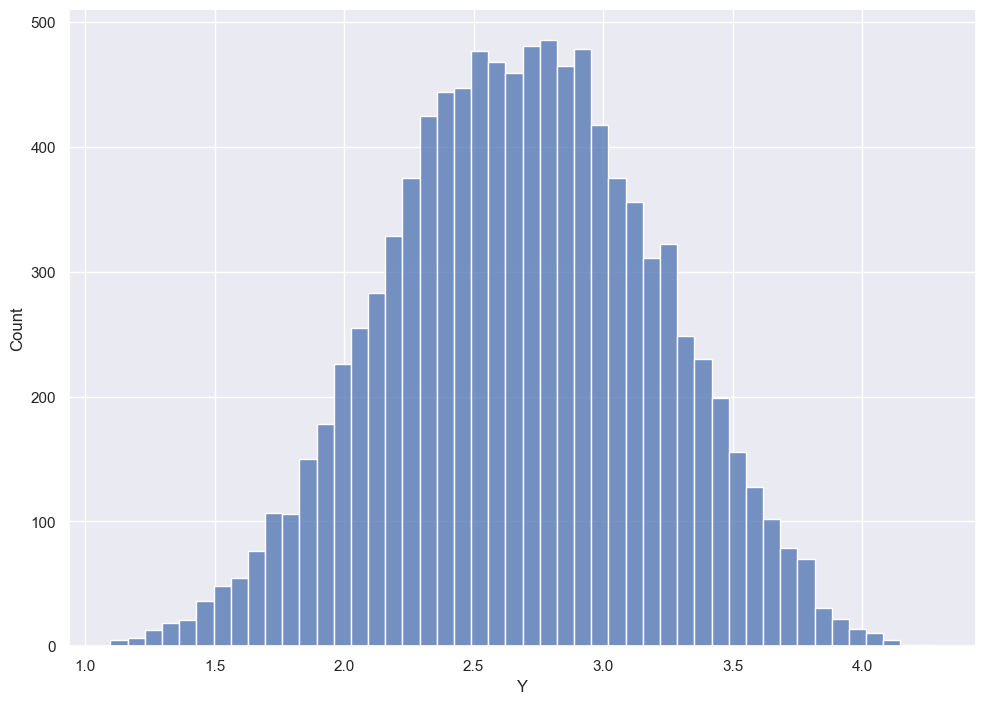

In [181]:
lab_Y = "Y"
data.dropna(axis=0, inplace=True)
sns.histplot(data[lab_Y])

In [182]:
data = data[ [lab_Y] + [col for col in data.columns if col != lab_Y]]

In [183]:
colY = np.where(data.columns==lab_Y)[0][0] ; colY

0

In [184]:
alpha=1/2

In [185]:
test_size=0.1
train_size=0.1

In [186]:
seed_sample = np.random.randint(1000);seed_sample

921

## Analyse

In [189]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y       10000 non-null  float64
 1   X0      10000 non-null  float64
 2   X1      10000 non-null  float64
 3   X2      10000 non-null  float64
 4   X3      10000 non-null  float64
 5   X4      10000 non-null  float64
 6   X5      10000 non-null  float64
 7   X6      10000 non-null  float64
 8   X7      10000 non-null  float64
 9   X8      10000 non-null  float64
 10  X9      10000 non-null  float64
dtypes: float64(11)
memory usage: 859.5 KB


<Axes: xlabel='Y', ylabel='Count'>

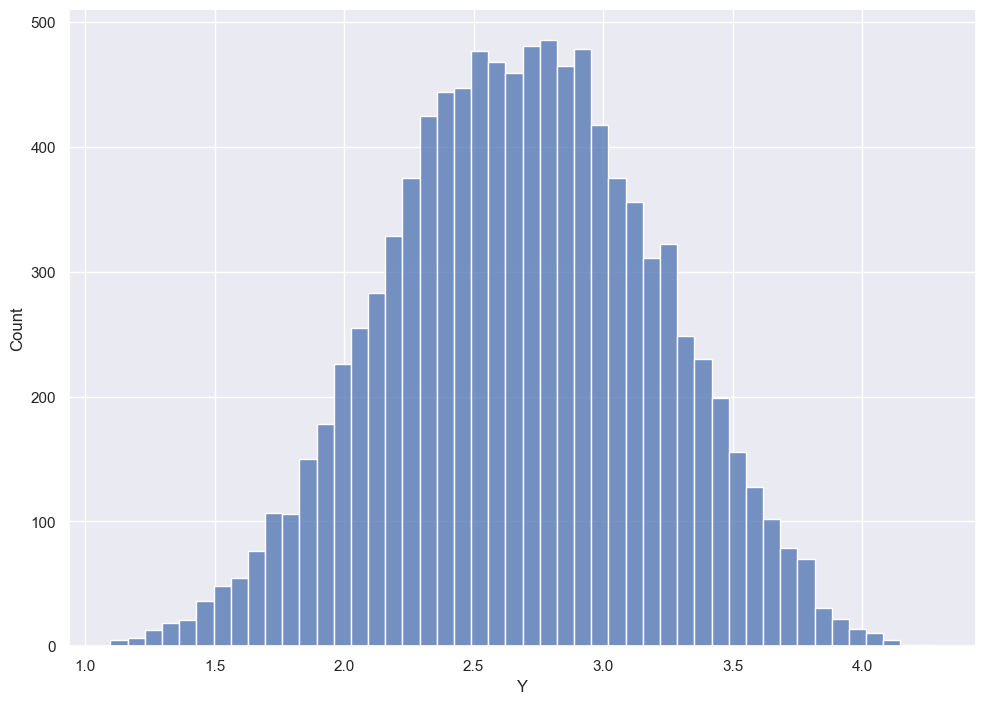

In [190]:
sns.histplot(data[lab_Y])

In [191]:
data.describe()

Y            X0            X1            X2            X3  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       2.684478     -0.002136      0.013534     -0.012463     -0.007571   
std        0.516844      1.003462      1.001010      0.991418      1.004487   
min        1.098521     -3.922400     -3.856375     -3.655087     -4.465604   
25%        2.323515     -0.672591     -0.662011     -0.700152     -0.694613   
50%        2.687755     -0.002595      0.015847     -0.005768     -0.010382   
75%        3.048643      0.671081      0.693865      0.663897      0.679030   
max        4.279157      3.926238      4.479084      3.691625      3.727833   

                 X4            X5            X6            X7            X8  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.006532      0.499278     -0.002800      0.128448      1.011528   
std        1.000397      0.314069      0.715111      0.703941      1.518180   
min       -4.295391     -0.024288     -1.372429     -1.441437     -1.650264   
25%       -0.664068      0.206656     -0.700412     -0.541938      0.086789   
50%        0.009561      0.497697      0.004866      0.237252      0.622643   
75%        0.683835      0.792547      0.697821      0.797083      1.461169   
max        3.536532      1.018758      1.295163      1.290813     20.069755   

                 X9  
count  10000.000000  
mean       0.998161  
std        1.493016  
min       -1.624064  
25%        0.072291  
50%        0.606434  
75%        1.427872  
max       19.008286

In [192]:
# X_df = pd.read_csv(rep+"/X_df.csv")
# data = X_df

In [193]:
kdem = gaussian_kde(np.array(data.T),bw_method="scott")
pd.DataFrame(kdem.covariance)

0         1         2         3         4         5         6   \
0   0.078232  0.084337  0.028000  0.003874  0.034330  0.036112  0.027453   
1   0.084337  0.294896 -0.002516  0.007786 -0.003016 -0.003316  0.088924   
2   0.028000 -0.002516  0.293456  0.007792  0.003926 -0.000917 -0.000873   
3   0.003874  0.007786  0.007792  0.287859  0.000738  0.001900  0.002251   
4   0.034330 -0.003016  0.003926  0.000738  0.295499  0.002362 -0.001230   
5   0.036112 -0.003316 -0.000917  0.001900  0.002362  0.293097 -0.000724   
6   0.027453  0.088924 -0.000873  0.002251 -0.001230 -0.000724  0.028888   
7   0.055603  0.000609  0.079504  0.000764 -0.002392 -0.002670  0.000043   
8   0.053235 -0.000344 -0.002224  0.002565 -0.000764  0.000945  0.000117   
9  -0.001406 -0.004565  0.006997 -0.003302 -0.005634  0.002083 -0.001140   
10 -0.003453 -0.001849 -0.000924 -0.003136 -0.004082 -0.008854 -0.000426   

          7         8         9         10  
0   0.055603  0.053235 -0.001406 -0.003453  
1   0.000609 -0.000344 -0.004565 -0.001849  
2   0.079504 -0.002224  0.006997 -0.000924  
3   0.000764  0.002565 -0.003302 -0.003136  
4  -0.002392 -0.000764 -0.005634 -0.004082  
5  -0.002670  0.000945  0.002083 -0.008854  
6   0.000043  0.000117 -0.001140 -0.000426  
7   0.149766  0.000280  0.001936 -0.000917  
8   0.000280  0.145124 -0.000273 -0.002302  
9   0.001936 -0.000273  0.675015 -0.000221  
10 -0.000917 -0.002302 -0.000221  0.652823

<Axes: >

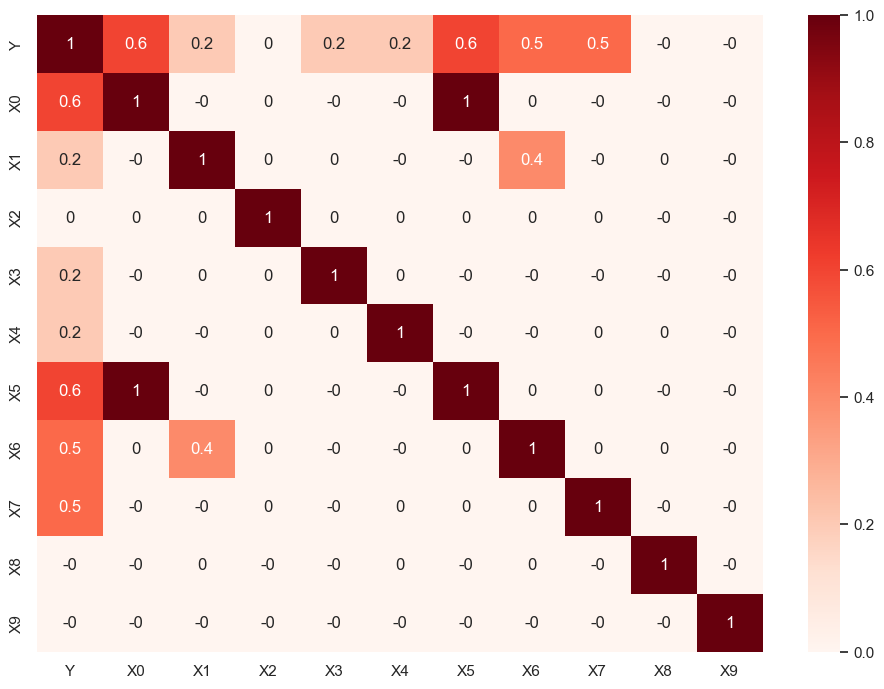

In [194]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(np.round(data.corr(method="pearson"),1),annot=True, cmap="Reds")

<Axes: >

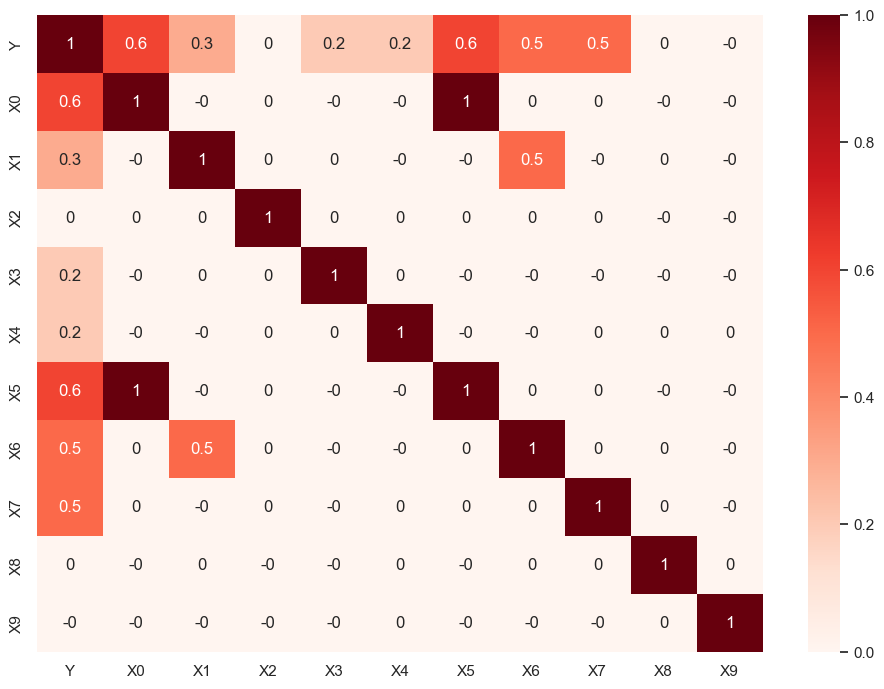

In [195]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(np.round(data.corr(method="spearman"),1),annot=True, cmap="Reds")

**Remarque** : on voit bien ici le problème de Silverman : ne capte que les corr bi lin (le coef de corr entre X2-X7, X3-X8 et X4-X9 sont quasi nuls alors que corrélations parfaites !

In [196]:
def transformer(inputs, mode_quanti="MinMax", mode_quali="OHE"):
    quanti = inputs.select_dtypes(include=['number'])
    quali = inputs.select_dtypes(include=['object', 'category'])
    name_quanti = quanti.columns
    if mode_quanti=="MinMax" :
      scaler = MinMaxScaler()
      quanti_t = pd.DataFrame(scaler.fit_transform(quanti))
    else:
      scaler = StandardScaler()
      quanti_t = pd.DataFrame(scaler.fit_transform(quanti))
    quanti_t.columns = name_quanti
    if quali.shape[1]==0:
        return quanti_t
    else:
        quali_t = pd.get_dummies(quali)
        if mode_quali=="AFDM" :
          quali_t=quali_t/np.sqrt(quali_t.mean())
        return pd.concat([quanti_t, quali_t], axis=1)

In [197]:
def inv_transformer(inputs, outputs, mode_quanti="MinMax", mode_quali="OHE"):
  quanti = inputs.select_dtypes(include=['number'])
  quali = inputs.select_dtypes(include=['object', 'category'])
  name_quanti = quanti.columns
  if quanti.shape[1] > 0 :
    if mode_quanti=="MinMax" :
      scaler = MinMaxScaler()
      scaler.fit(quanti)
      res_quanti =  pd.DataFrame(scaler.inverse_transform(outputs[name_quanti]))
    elif mode_quanti=="SC" :
      scaler = StandardScaler()
      scaler.fit(quanti)
      res_quanti =  pd.DataFrame(scaler.inverse_transform(outputs[name_quanti]))
    else:
      res_quanti =  pd.DataFrame(outputs[name_quanti])
    res_quanti.columns = name_quanti
    res_quanti.index = outputs.index
  if quali.shape[1] > 0 :
    quali_t = pd.get_dummies(quali)
    name_quali_t = quali_t.columns
    res_quali = outputs.copy()
    res_quali.drop(name_quanti, axis=1, inplace=True)
    res_quali.index = quali_t.index
    res_quali = np.round(res_quali,0)
    if quanti.shape[1] > 0 :
      return pd.concat([res_quanti, res_quali], axis=1)
    else:
      return res_quali
  else:
    return res_quanti

## Weighting IR 

In [198]:
def IR_weighting(Y, plot=False, alpha=1/2, Yeval=None, kde=None):
    if Yeval is None: Yeval=Y
    if kde is None:
        w= 1/gaussian_kde(Y).evaluate(Yeval)**(alpha)
    else:
        w= 1/kde.evaluate(Yeval)**(alpha)
    w=w/sum(w)
    if plot==True:
        sns.set(rc={'figure.figsize':(3,3)})
        sns.histplot(Y)
        plt.show()
        sns.scatterplot(x=Y,y=w)
    return w

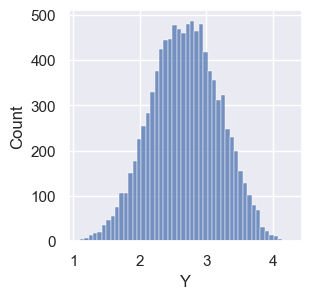

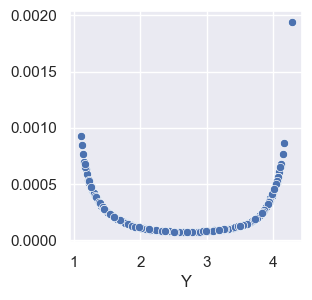

In [199]:
kde_data=gaussian_kde(data[lab_Y])
w_Y_data=IR_weighting(data[lab_Y], plot=True, alpha=alpha)

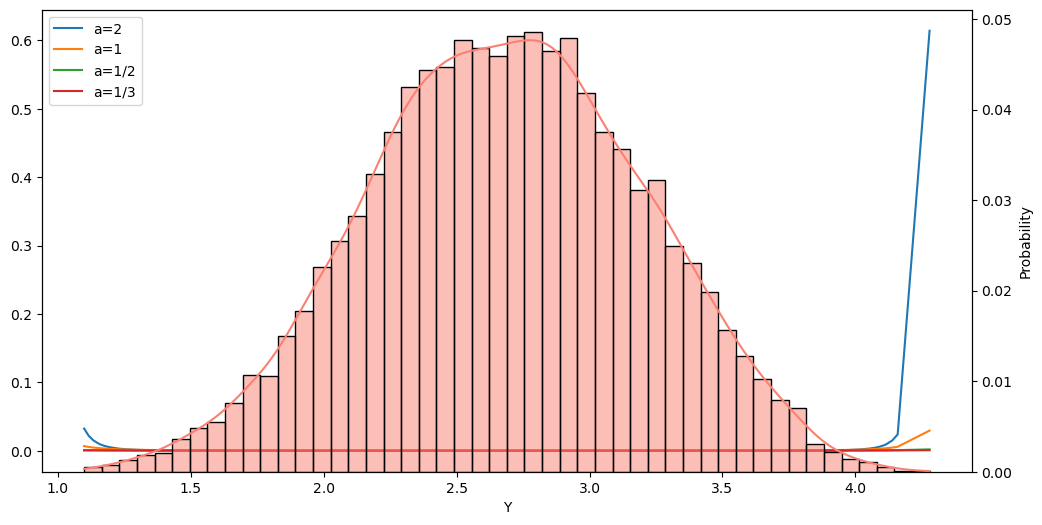

In [200]:
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(x=data.Y,y=IR_weighting(data.Y, plot=False, alpha=2),ax=ax1,label="a=2")
sns.lineplot(x=data.Y,y=IR_weighting(data.Y, plot=False, alpha=1),ax=ax1,label="a=1")
sns.lineplot(x=data.Y,y=IR_weighting(data.Y, plot=False, alpha=1/2),ax=ax1,label='a=1/2')
sns.lineplot(x=data.Y,y=IR_weighting(data.Y, plot=False, alpha=1/3), ax=ax1, label='a=1/3')
# ax1.legend(['alpha=1',  'alpha=1/3', "alpha=1/3","alpha=1/3"])
plt.legend()
ax2 = ax1.twinx()
sns.histplot(data=data,x='Y',alpha=0.5, ax=ax2,kde=True, stat="probability", color="salmon")
plt.savefig('graph_Alpha.png')

## Train-Test Split

In [201]:
def trainTest(data, test_size=0.3,np_seed=None,w_test=None, train_size=None, imbForce=0):
    if np_seed is None:
        np.random.seed()
    else:
        np.random.seed(np_seed)
    n = data.shape[0]
    if w_test is None:w_test=np.repeat(1,n)/n
    n_test = round(test_size*n)
    n_train = round(train_size*n)
    id_test = np.random.choice(n, size=n_test, p=w_test , replace=False)
    X_test = data.iloc[id_test,:]
    X_train = data.drop(index=id_test)
    if train_size is not None:
        w_imb = IR_weighting(data[lab_Y],alpha=imbForce)[X_train.index]
        id_imb = np.random.choice(X_train.shape[0], size=n_train, p=w_imb/sum(w_imb) , replace=False)
        X_imb = X_train.iloc[id_imb,:]
        w_bal = w_test[X_train.index]
        id_bal = np.random.choice(X_train.shape[0], size=n_train, p=w_bal/sum(w_bal) , replace=False)
        X_bal = X_train.iloc[id_bal,:]
    return{'X_train':X_imb,'X_test':X_test,'X_bal':X_bal}

In [202]:
split = trainTest(data,test_size,seed_sample,w_test=w_Y_data,train_size=train_size, imbForce=-1.5)
X_train = split['X_train']
X_test = split['X_test']
X_bal = split['X_bal']
print(X_train.shape)
print(X_test.shape)
print(X_bal.shape)

(1000, 11)
(1000, 11)
(1000, 11)


<Axes: xlabel='Y', ylabel='Density'>

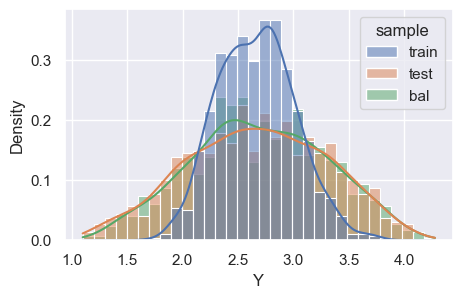

In [203]:
sns.set(rc={'figure.figsize':(5,3)})
train_df = pd.DataFrame(X_train[[lab_Y]])
train_df['sample']='train'
test_df = pd.DataFrame(X_test[[lab_Y]])
test_df['sample']='test'
bal_df = pd.DataFrame(X_bal[[lab_Y]])
bal_df['sample']='bal'
sns.histplot(data=pd.concat([train_df,test_df, bal_df],axis=0),x=lab_Y,hue='sample',kde=True, stat="density")

                 Y
count  1000.000000
mean      2.666963
std       0.345665
min       1.725901
25%       2.409848
50%       2.675094
75%       2.905634
max       3.784996


<Axes: ylabel='Count'>

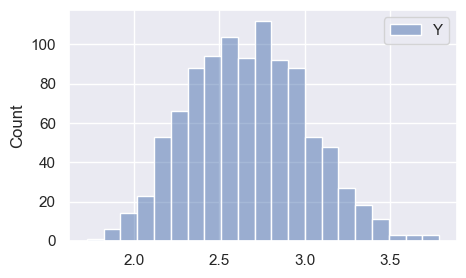

In [204]:
print(X_train[[lab_Y]].describe())
sns.histplot(X_train[[lab_Y]])

                 Y
count  1000.000000
mean      2.670709
std       0.635216
min       1.098521
25%       2.197202
50%       2.685107
75%       3.156013
max       4.279157


<Axes: ylabel='Count'>

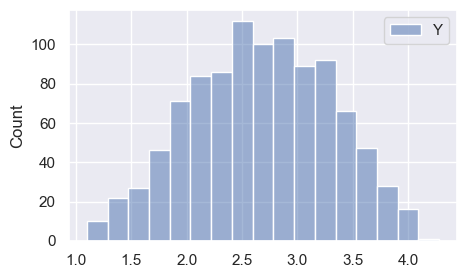

In [205]:
print(X_test[[lab_Y]].describe())
sns.histplot(X_test[[lab_Y]])

<Axes: xlabel='Y'>

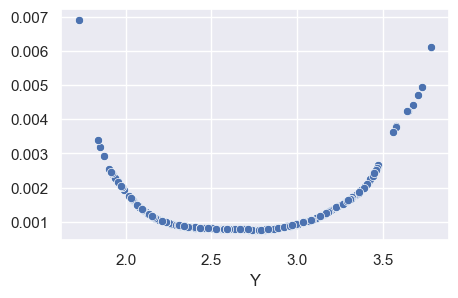

In [206]:
Xy_train=X_train.copy()
y_train =  X_train[[lab_Y]]
X_train.drop(columns=lab_Y, axis=1, inplace=True)
w_Y=IR_weighting(y_train[lab_Y], alpha=alpha)
sns.scatterplot(x=y_train[lab_Y],y=w_Y)

# AUTOMATISATION

## Analyse

In [40]:
def PCA_NL_Analyze_y(res, X_train, y_train, plot_Model=False, MC_ref=None, w_Y=None):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    train=X_train.copy()
    ytrain = pd.DataFrame(y_train.copy())
    ytrain.columns = [lab_Y]
    decoded_x = pd.DataFrame(res['decoded_x'].cpu().detach().numpy())
    decoded_y = pd.DataFrame(res['decoded_y'].cpu().detach().numpy())
    encoded = pd.DataFrame(res['encoded'].cpu().detach())
    decoded_x.columns=X_train.columns
    decoded_y.columns=ytrain.columns
    RMSE_X = np.sqrt(np.mean((decoded_x-transformer(train))**2))
    RMSE_y = np.sqrt(np.mean((decoded_y-transformer(ytrain))**2))
    wRMSE_y = np.sqrt(np.mean(((decoded_y-transformer(y_train))**2)[lab_Y]*w_Y))
    decoded_x = inv_transformer(X_train, decoded_x)
    decoded_x['Type'] = 'Recons'
    train['Type'] = 'Real'
    reconstruct_x  = pd.concat([train,decoded_x])
    
    decoded_y = inv_transformer(ytrain, decoded_y)
    decoded_y['Type'] = 'Recons'
    ytrain['Type'] = 'Real'
    reconstruct_y  = pd.concat([ytrain,decoded_y])
    
    KL_R = 0#KL_dataset(reconstruct)
    if plot_Model:
        losses=res['losses']
        losses_VAE=res['losses_VAE']
        losses_X=res['losses_X']
        losses_Y=res['losses_Y']
        losses_KL=res['losses_KL']
        losses_COV=res['losses_COV']
        plt.clf()
        m=int(len(losses)/50)
        sns.set(rc={'figure.figsize':(11.7,8.27)})
        sns.lineplot(pd.DataFrame({"losses":losses,"losses_VAE":losses_VAE,"losses_X":losses_X,"losses_Y":losses_Y,"losses_KL":losses_KL,"losses_COV":losses_COV}))
        plt.suptitle("Losses Analysis", y=1.02)
        plt.show()
        sns.set(rc={'figure.figsize':(11.7,8.27)})
        sns.lineplot(pd.DataFrame({"losses":losses,"losses_VAE":losses_VAE,"losses_X":losses_X,"losses_Y":losses_Y,"losses_KL":losses_KL,"losses_COV":losses_COV}).iloc[m:,:])
        plt.suptitle("Losses Analysis-Focus", y=1.02)
        plt.show()
        print("losses_min:",np.min(losses))
        print("RMSE_X:",RMSE_X)
        print("RMSE_y",RMSE_y)
        print('wRMSE_y',wRMSE_y)
        print("MSE_X:",RMSE_X**2)
    if  plot_Model:
        sns.pairplot(encoded,diag_kind='kde')
        plt.show()
    # if plot_Model:
    #     sns.set(rc={'figure.figsize':(11.7,8.27)})
    #     sns.heatmap(np.round(pd.DataFrame(encoded.corr(method="spearman")),1),annot=True)
    #     sns.heatmap(np.round(pd.DataFrame(encoded.corr(method="pearson")),1),annot=True)
    #     plt.show()
    # if MC_ref is not None:
    #     MC_dif = (np.abs(MC_ref - np.abs(pd.DataFrame(encoded.corr(method="spearman")))).sum().sum())/2
    #     MC_filtre = MC_ref - np.eye(MC_ref.shape[1])
    #     MC_corr=np.abs(np.abs(pd.DataFrame(encoded.corr(method="spearman"))) * MC_filtre - MC_filtre).sum().sum()/2 
    if plot_Model:  
        sns.set(rc={'figure.figsize':(11.7,8.27)})
        sns.pairplot(decoded_x, diag_kind='kde')
        sns.pairplot(reconstruct_x, diag_kind='kde', hue='Type')
        sns.pairplot(decoded_y, diag_kind='kde')
        sns.pairplot(reconstruct_y, diag_kind='kde', hue='Type')
        
    if MC_ref is not None:
        return {'RMSE_X':RMSE_X,'RMSE_y':RMSE_y,'wRMSE_y':wRMSE_y,'MSE_X':RMSE_X**2, 'MC_dif':MC_dif,'MC_corr':MC_corr,"KL_R":KL_R}
    else:
        return {'RMSE_X':RMSE_X,'RMSE_y':RMSE_y,'wRMSE_y':wRMSE_y, 'MSE_X':RMSE_X**2, "KL_R":KL_R}

## Outputs

In [41]:
def outputs(res, inputsX, inputsY):
    inputsX = transformer(inputsX)
    inputsY = transformer(inputsY)
    inputsX=torch.FloatTensor(inputsX.to_numpy()).to(device)
    inputsY=torch.FloatTensor(inputsY.to_numpy()).to(device)
    res['model'].eval()
    if res['type'] == 'AE':
        mu = res['model'].encode(inputsX, inputsY)
    else:
        mu, _ = res['model'].encode(inputsX, inputsY)
    outputs_x, outputs_y = res['model'].decode(mu)
    outputs_x=pd.DataFrame(outputs_x.cpu().detach())
    outputs_y=pd.DataFrame(outputs_y.cpu().detach())
    outputs_x.columns=X_train.columns
    outputs_y.columns=y_train.columns
    outputs_xy = pd.concat([outputs_y, outputs_x],axis=1)
    outputs_xy.index = Xy_train.index
    return inv_transformer(Xy_train,outputs_xy)

## Prediction

In [208]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------
H2O_cluster_uptime:         4 hours 24 mins
H2O_cluster_timezone:       Europe/Paris
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.2
H2O_cluster_version_age:    9 months and 19 days
H2O_cluster_name:           H2O_from_python_samgo_71hfe8
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    14.85 Gb
H2O_cluster_total_cores:    32
H2O_cluster_allowed_cores:  32
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.11.4 final
--------------------------  -----------------------------

In [209]:
test_data = h2o.H2OFrame(X_test)
X_col = X_test.columns
y_col = X_test.columns[colY]
X_col = X_col.drop(y_col).tolist()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [210]:
def TirMix(train, synth, graine):
    train_graine = train.iloc[graine,:]
    doub=(train_graine.duplicated()*1).to_numpy()
    synth_mix = synth.copy()
    for i in range(synth_mix.shape[0]):
        if doub[i]==0:
            synth_mix.iloc[i,:]=np.float32(train_graine.iloc[i,:])
    return np.round(synth_mix,10)

In [211]:
def pred(train, test_data, Mix=False,Xy_train=None,graine=None, preds=None, weights=None):
    warnings.filterwarnings("ignore", category=H2ODependencyWarning)
    w_test = IR_weighting(X_test[lab_Y],kde=kde_data, alpha=alpha)
    if Mix:
        print("mode TirMix")
        train_hat = TirMix(Xy_train, train, graine)
    else:
        train_hat=train.copy()
    if preds is None:
        train_hat = np.round(train_hat,10)
        train_hat = h2o.H2OFrame(train_hat)
        if weights is not None:
            train_hat = train_hat.cbind(h2o.H2OFrame(weights))
            columns = train_hat.columns
            columns[-1] = "weights"
            train_hat.columns = columns
            aml = H2OAutoML(max_models=10, seed=42)
            aml.train(x=X_col, y=y_col, training_frame=train_hat, weights_column='weights')
            train_hat = train_hat.drop("weights")
        else:
            aml = H2OAutoML(max_models=10, seed=42)
            aml.train(x=X_col, y=y_col, training_frame=train_hat)
        res_aml = aml.leaderboard
        preds = aml.predict(test_data)
        preds = preds.as_data_frame().to_numpy()
    obs = test_data[y_col].as_data_frame().to_numpy()
    mse = mean_squared_error(preds,obs)
    wmse=(w_test*(preds-obs)**2).mean()
    mape = mean_absolute_percentage_error(preds,obs)
    mae = median_absolute_error(preds,obs)
    gm =  gmean(np.abs(preds-obs))[0]
    rs = spearmanr(preds,obs)[0]
    egm = np.prod(np.abs(preds-obs))**(1/test_data.shape[0])
    if preds is None:
        return {"res_aml" : res_aml, "preds" : preds.ravel(), "mse" : mse, 'mape':mape, 'mae':mae, 'wmse':wmse, 'gm':gm, 'rs':rs, 'obs':obs.ravel(), 'w_test':w_test}
    else:
        return {"res_aml" : res_aml, "preds" : preds.ravel(), "mse" : mse, 'mape':mape, 'mae':mae, 'wmse':wmse, 'gm':gm, 'rs':rs, 'obs':obs.ravel(), 'w_test':w_test}

# Simulations

## Runs

In [95]:
seed_samples=[]
complS = [1,2,3,4,5]
imbS = [0.5,0,-0.5,-1,-1.5]
trainsizeS = [0.02,  0.05, 0.1, 0.2, 0.5]
test_size=0.1
alpha=1/2
kfold = 3
start_time_boucle = time.time()
n=10000

In [47]:
res_MAPE_l=[]
res_MAE_l =[]
res_MSE_l =[]   
res_wMSE_l=[]
res_preds_l = []
res_aml_l = []
simu = 0
w_Y_data=IR_weighting(data[lab_Y], alpha=alpha)
if seed_samples==[] : relance = False
for k in range(kfold):
    h2o.init()
    # Seed
    if relance == False:
        np.random.seed()
        seed_sample = np.random.randint(1000)
    else:
        seed_sample = seed_samples[simu]
    seed_samples.append(seed_sample)
    np.random.seed(seed_sample)
    random.seed(seed_sample)
    
    for compl in complS:
        for imb in imbS:
            for trainsize in trainsizeS:
                print("============================     simu : ",simu,"          ======================")
                res_MSE  =  []
                res_wMSE =  []
                res_MAE  =  []
                res_MAPE =  []
                res_preds = []
                res_aml = []

                # data
                data = simu_data(n, graine=seed_sample, c=compl)

                # Train-test sampling
                w_Y_data=IR_weighting(data[lab_Y], plot=False, alpha=alpha)
                split = trainTest(data,test_size,seed_sample,w_test=w_Y_data,train_size=trainsize, imbForce=imb)
                X_train = split['X_train']
                X_test = split['X_test']
                X_bal = split['X_bal']
                Xy_train = X_train.copy()
                y_train =  X_train[[lab_Y]]
                X_train.drop(lab_Y, axis=1, inplace=True)
                Xy_bal = X_bal.copy()
                y_bal =  X_bal[[lab_Y]]
                X_bal.drop(lab_Y, axis=1, inplace=True)

                test_data = h2o.H2OFrame(X_test)
                X_col = X_test.columns
                y_col = X_test.columns[colY]
                X_col = X_col.drop(y_col).tolist()

                # Prediction
                resPred_imb = pred(Xy_train, test_data, Mix=False)
                resPred_bal = pred(Xy_bal, test_data, Mix=False)
                warnings.resetwarnings()
                res_MSE  =  pd.DataFrame({'run':simu, 'Complexity':[compl],'trainSize':[trainsize],'ImbLevel':[imb],'seed':[seed_sample],'imb':[resPred_imb['mse']]})
                res_MAE  =  pd.DataFrame({'run':simu, 'Complexity':[compl],'trainSize':[trainsize],'ImbLevel':[imb],'seed':[seed_sample],'imb':[resPred_imb['mae']]})
                res_MAPE =  pd.DataFrame({'run':simu, 'Complexity':[compl],'trainSize':[trainsize],'ImbLevel':[imb],'seed':[seed_sample],'imb':[resPred_imb['mape']]})
                res_wMSE =  pd.DataFrame({'run':simu, 'Complexity':[compl],'trainSize':[trainsize],'ImbLevel':[imb],'seed':[seed_sample],'imb':[resPred_imb['wmse']]})    
                res_preds = pd.DataFrame({'run':simu,'obs':resPred_imb['obs'],'w_test':resPred_imb['w_test'],'Imb':resPred_imb['preds']})
                res_MSE['bal'] = resPred_bal['mse']
                res_MAE['bal'] = resPred_bal['mae']
                res_MAPE['bal'] = resPred_bal['mape']
                res_wMSE['bal'] = resPred_bal['wmse']
                res_preds['Bal'] = resPred_bal['preds']
                with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
                    res_aml_imb = resPred_imb['res_aml'].as_data_frame()
                    res_aml_bal = resPred_bal['res_aml'].as_data_frame()
                res_aml_imb['train'] = 'imb'
                res_aml_bal['train'] = 'bal'
                res_aml = pd.concat([res_aml_imb, res_aml_bal])
                res_aml['run'] = simu
                res_aml['Complexity'] = compl
                res_aml['trainSize'] = trainsize
                res_aml['ImbLevel'] = imb
                res_aml['seed'] = seed_sample

                if len(res_MSE_l)==0:
                    res_MSE_l  = res_MSE
                    res_MAE_l  =  res_MAE
                    res_MAPE_l =  res_MAPE
                    res_wMSE_l =  res_wMSE
                    res_preds_l =  res_preds
                    res_aml_l =  res_aml
                else:
                    res_MSE_l  = pd.concat([res_MSE_l, res_MSE])
                    res_MAE_l  = pd.concat([res_MAE_l,res_MAE])
                    res_MAPE_l = pd.concat([res_MAPE_l,res_MAPE])
                    res_wMSE_l  = pd.concat([res_wMSE_l, res_wMSE])
                    res_preds_l  = pd.concat([res_preds_l, res_preds])
                    res_aml_l  = pd.concat([res_aml_l, res_aml])
                simu +=1
    res_MSE_l.to_csv(rep+"/res_MSE_l.csv")
    res_MAE_l.to_csv(rep+"/res_MAE_l.csv")
    res_MAPE_l.to_csv(rep+"/res_MAPE_l.csv")
    res_wMSE_l.to_csv(rep+"/res_wMSE_l.csv")
    res_preds_l.to_csv(rep+"/res_preds_l.csv")
    res_aml_l.to_csv(rep+"/res_aml_l.csv")

print("tps de calcul : ",time.time()-start_time_boucle)

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------
H2O_cluster_uptime:         5 hours 47 mins
H2O_cluster_timezone:       Europe/Paris
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.2
H2O_cluster_version_age:    9 months and 15 days
H2O_cluster_name:           H2O_from_python_samgo_71hfe8
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    14.65 Gb
H2O_cluster_total_cores:    32
H2O_cluster_allowed_cores:  32
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.11.4 final
--------------------------  -----------------------------

============================     simu :  0           ======================
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
00:53:18.125: AutoML: XGBoost is not available; skipping it.
00:53:18.775: GBM_1_AutoML_1_20250301_05318 [GBM def_5] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_1_AutoML_1_20250301_05318.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 160.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 160.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 160.0.
ERRR on fie

--------------------------  -----------------------------
H2O_cluster_uptime:         13 hours 6 mins
H2O_cluster_timezone:       Europe/Paris
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.2
H2O_cluster_version_age:    9 months and 15 days
H2O_cluster_name:           H2O_from_python_samgo_71hfe8
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    10.98 Gb
H2O_cluster_total_cores:    32
H2O_cluster_allowed_cores:  32
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.11.4 final
--------------------------  -----------------------------

============================     simu :  125           ======================
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
08:12:22.16: AutoML: XGBoost is not available; skipping it.
08:12:22.50: GBM_1_AutoML_251_20250301_81222 [GBM def_5] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_1_AutoML_251_20250301_81222.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 160.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 160.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 160.0.
ERRR on

--------------------------  -----------------------------
H2O_cluster_uptime:         20 hours 25 mins
H2O_cluster_timezone:       Europe/Paris
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.2
H2O_cluster_version_age:    9 months and 16 days
H2O_cluster_name:           H2O_from_python_samgo_71hfe8
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    1.694 Gb
H2O_cluster_total_cores:    32
H2O_cluster_allowed_cores:  32
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.11.4 final
--------------------------  -----------------------------

============================     simu :  250           ======================
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
15:30:57.599: AutoML: XGBoost is not available; skipping it.
15:30:57.642: GBM_1_AutoML_501_20250301_153057 [GBM def_5] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_1_AutoML_501_20250301_153057.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 160.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 160.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 160.0.
ERR

In [48]:
res_MAE_l

run  Complexity  trainSize  ImbLevel  seed       imb       bal
0     0           1       0.02       0.5   994  0.072390  0.071527
0     1           1       0.05       0.5   994  0.071750  0.069511
0     2           1       0.10       0.5   994  0.069545  0.068980
0     3           1       0.20       0.5   994  0.068732  0.069211
0     4           1       0.50       0.5   994  0.069275  0.068770
..  ...         ...        ...       ...   ...       ...       ...
0   370           5       0.02      -1.5   160  0.102736  0.087739
0   371           5       0.05      -1.5   160  0.095272  0.081406
0   372           5       0.10      -1.5   160  0.093447  0.079743
0   373           5       0.20      -1.5   160  0.086834  0.079340
0   374           5       0.50      -1.5   160  0.080545  0.075628

[375 rows x 7 columns]

In [49]:
res_aml_l

model_id      rmse       mse  \
0                       GLM_1_AutoML_1_20250301_05318  0.103610  0.010735   
1   StackedEnsemble_BestOfFamily_1_AutoML_1_202503...  0.104316  0.010882   
2   StackedEnsemble_AllModels_1_AutoML_1_20250301_...  0.104352  0.010889   
3              DeepLearning_1_AutoML_1_20250301_05318  0.154844  0.023977   
4   DeepLearning_grid_1_AutoML_1_20250301_05318_mo...  0.158033  0.024974   
..                                                ...       ...       ...   
7                    DRF_1_AutoML_750_20250301_225331  0.109070  0.011896   
8                    XRT_1_AutoML_750_20250301_225331  0.109290  0.011944   
9           DeepLearning_1_AutoML_750_20250301_225331  0.109290  0.011944   
10                   GBM_4_AutoML_750_20250301_225331  0.109649  0.012023   
11                   GLM_1_AutoML_750_20250301_225331  0.124776  0.015569   

         mae     rmsle  mean_residual_deviance train  run  Complexity  \
0   0.084558  0.029744                0.010735   imb    0           1   
1   0.085118  0.029941                0.010882   imb    0           1   
2   0.085571  0.029990                0.010889   imb    0           1   
3   0.123237  0.044097                0.023977   imb    0           1   
4   0.121479  0.046015                0.024974   imb    0           1   
..       ...       ...                     ...   ...  ...         ...   
7   0.086802  0.065164                0.011896   bal  374           5   
8   0.086822  0.065390                0.011944   bal  374           5   
9   0.086870  0.065579                0.011944   bal  374           5   
10  0.087169  0.065505                0.012023   bal  374           5   
11  0.099158  0.075619                0.015569   bal  374           5   

    trainSize  ImbLevel  seed  
0        0.02       0.5   994  
1        0.02       0.5   994  
2        0.02       0.5   994  
3        0.02       0.5   994  
4        0.02       0.5   994  
..        ...       ...   ...  
7        0.50      -1.5   160  
8        0.50      -1.5   160  
9        0.50      -1.5   160  
10       0.50      -1.5   160  
11       0.50      -1.5   160  

[9000 rows x 12 columns]

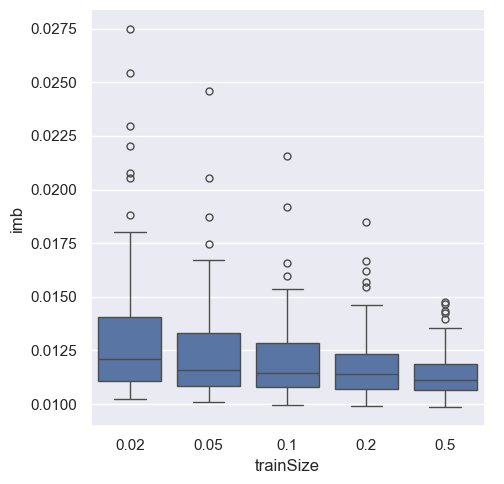

In [50]:
sns.catplot(y='imb',x='trainSize',kind='box', data=res_MSE_l)

<Axes: xlabel='ImbLevel', ylabel='imb'>

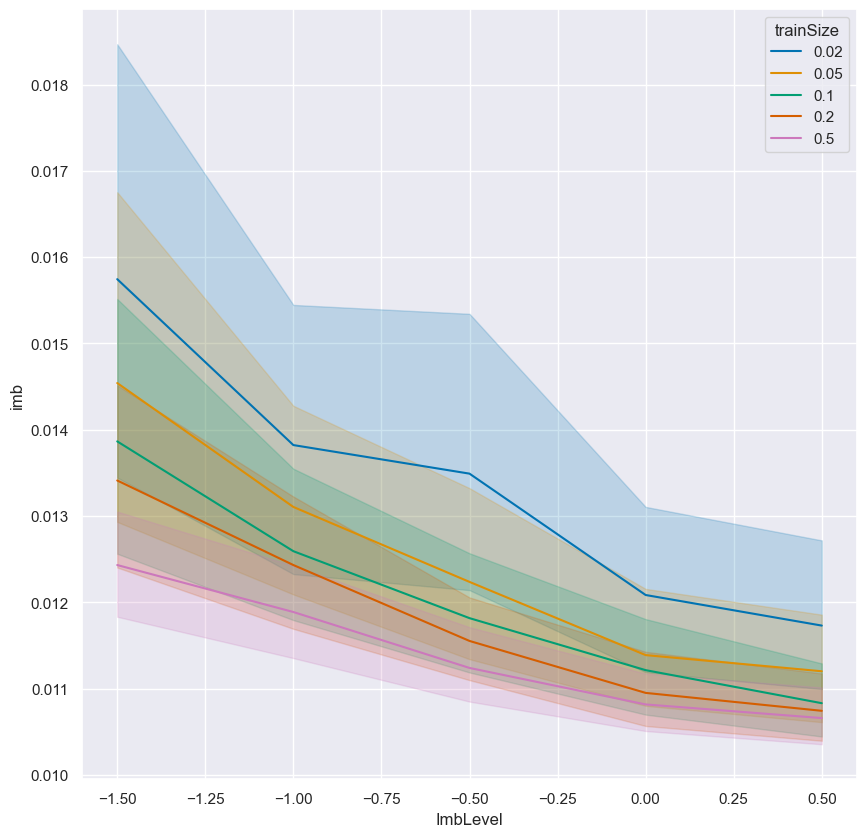

In [51]:
sns.set(rc={'figure.figsize':(10,10)})
sns.lineplot(y='imb',x='ImbLevel',hue='trainSize', data=res_MSE_l, palette='colorblind')

<Axes: xlabel='ImbLevel', ylabel='imb'>

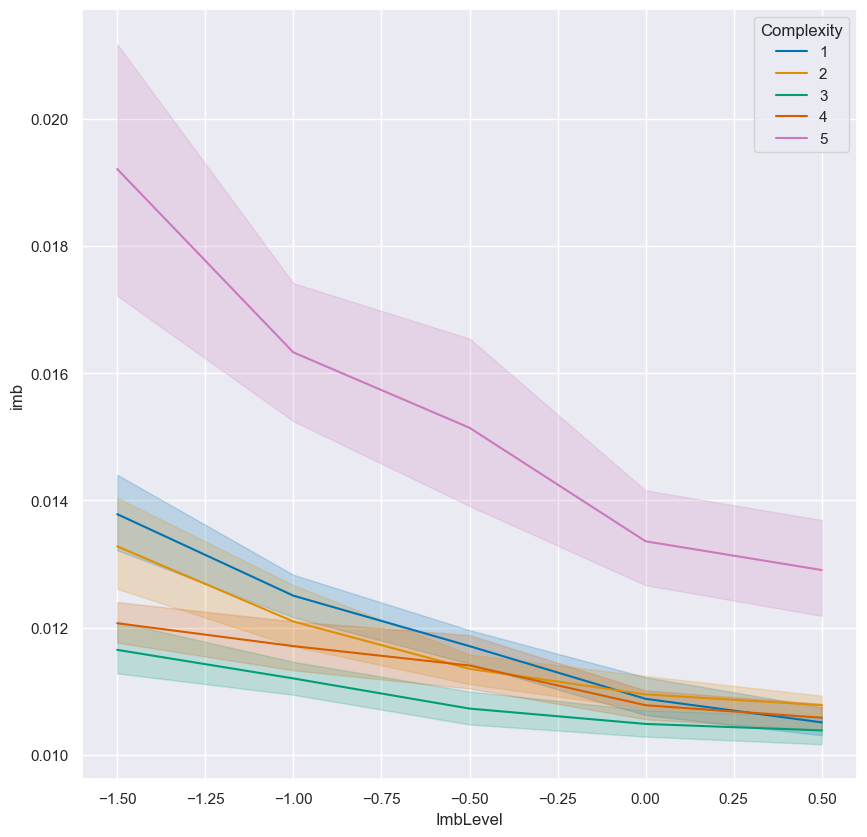

In [52]:
sns.set(rc={'figure.figsize':(10,10)})
sns.lineplot(y='imb',x='ImbLevel',hue='Complexity', data=res_MSE_l, palette='colorblind')

<Axes: xlabel='trainSize', ylabel='imb'>

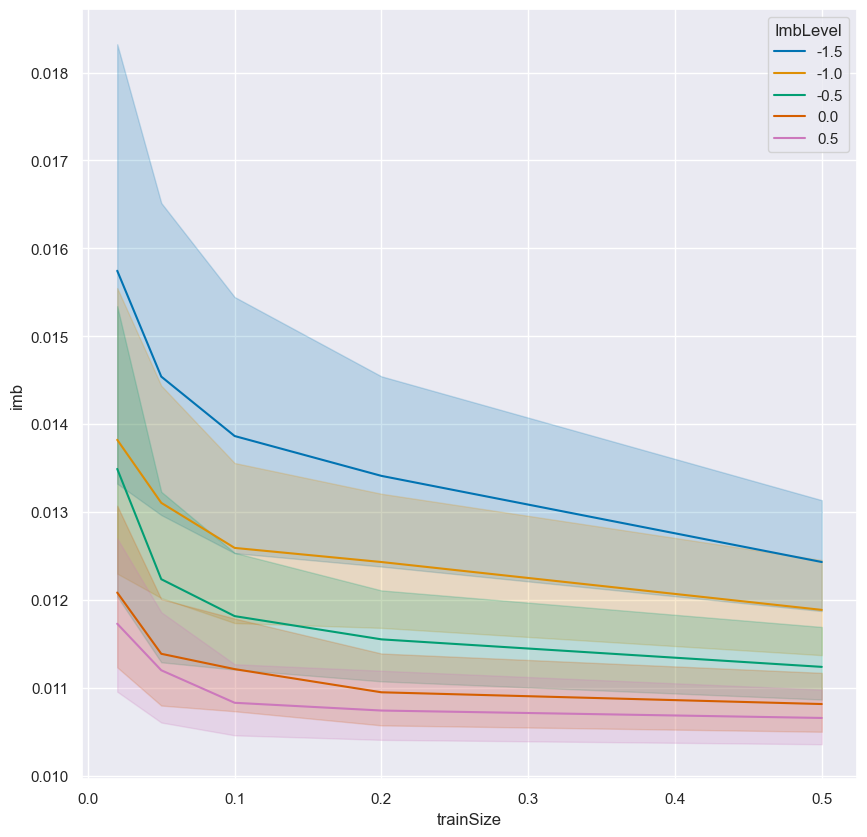

In [53]:
sns.set(rc={'figure.figsize':(10,10)})
sns.lineplot(y='imb',x='trainSize',hue='ImbLevel', data=res_MSE_l, palette='colorblind')

In [54]:
res_aml_l

model_id      rmse       mse  \
0                       GLM_1_AutoML_1_20250301_05318  0.103610  0.010735   
1   StackedEnsemble_BestOfFamily_1_AutoML_1_202503...  0.104316  0.010882   
2   StackedEnsemble_AllModels_1_AutoML_1_20250301_...  0.104352  0.010889   
3              DeepLearning_1_AutoML_1_20250301_05318  0.154844  0.023977   
4   DeepLearning_grid_1_AutoML_1_20250301_05318_mo...  0.158033  0.024974   
..                                                ...       ...       ...   
7                    DRF_1_AutoML_750_20250301_225331  0.109070  0.011896   
8                    XRT_1_AutoML_750_20250301_225331  0.109290  0.011944   
9           DeepLearning_1_AutoML_750_20250301_225331  0.109290  0.011944   
10                   GBM_4_AutoML_750_20250301_225331  0.109649  0.012023   
11                   GLM_1_AutoML_750_20250301_225331  0.124776  0.015569   

         mae     rmsle  mean_residual_deviance train  run  Complexity  \
0   0.084558  0.029744                0.010735   imb    0           1   
1   0.085118  0.029941                0.010882   imb    0           1   
2   0.085571  0.029990                0.010889   imb    0           1   
3   0.123237  0.044097                0.023977   imb    0           1   
4   0.121479  0.046015                0.024974   imb    0           1   
..       ...       ...                     ...   ...  ...         ...   
7   0.086802  0.065164                0.011896   bal  374           5   
8   0.086822  0.065390                0.011944   bal  374           5   
9   0.086870  0.065579                0.011944   bal  374           5   
10  0.087169  0.065505                0.012023   bal  374           5   
11  0.099158  0.075619                0.015569   bal  374           5   

    trainSize  ImbLevel  seed  
0        0.02       0.5   994  
1        0.02       0.5   994  
2        0.02       0.5   994  
3        0.02       0.5   994  
4        0.02       0.5   994  
..        ...       ...   ...  
7        0.50      -1.5   160  
8        0.50      -1.5   160  
9        0.50      -1.5   160  
10       0.50      -1.5   160  
11       0.50      -1.5   160  

[9000 rows x 12 columns]

In [ ]:
sns.boxplot(y=compTime_l.Approach, x=compTime_l.Comp_Time)

In [ ]:
sns.set(rc={'figure.figsize':(5,10)})
sns.heatmap(pd.DataFrame(res_MSE_l.mean(axis=1)), annot=True, cmap='RdYlGn_r',fmt='.2f')
plt.show()
sns.heatmap(pd.DataFrame(res_MSE_l.std(axis=1)), annot=True, cmap='RdYlGn_r',fmt='.2f')

In [ ]:
sns.set(rc={'figure.figsize':(5,10)})
sns.heatmap(pd.DataFrame(res_MAE_l.mean(axis=1)), annot=True, cmap='RdYlGn_r',fmt='.2f')
plt.show()
sns.heatmap(pd.DataFrame(res_MAE_l.std(axis=1)), annot=True, cmap='RdYlGn_r',fmt='.2f')

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(res_MSE_l.transpose(), orient='h')
plt.savefig('res_MSE_l.png')

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(res_MAE_l.transpose(), orient='h')

In [ ]:
res_MSE_lRank = res_MSE_l.rank(axis=0);res_MSE_lRank.mean(1)


In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(res_MAPE_l.transpose(), orient='h')

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(res_GM_l.transpose(), orient='h')

In [ ]:
sns.histplot(synth_kBVAEw[lab_Y], bins=30, kde=True, stat='probability')
sns.histplot(synth_ILRgn[lab_Y], bins=30, kde=True, stat='probability')

### Metrics

In [ ]:
res_preds_l.groupby('seed').apply(
    lambda group: rm.phi_weighted_mse(group['obs'], group['baseline'])
).reset_index(name='IRL_MSE')

In [ ]:
# try:
y_test = res_preds_l['obs']
y_pred = res_preds_l['baseline']
ilr_mse = rm.phi_weighted_mse (y_test , y_pred)
ilr_mae = rm.phi_weighted_mae (y_test , y_pred)
ilr_r2 = rm.phi_weighted_r2 (y_test , y_pred)
ilr_rmse = rm.phi_weighted_root_mse (y_test , y_pred) 
ser_t = rm.ser_t(y_test,y_pred,t=.7)
sera= rm.sera(y_test,y_pred,return_err = True)
f1s = resreg.f1_score(y_test,y_pred)

# except Exception as e: synth_ILRsmote = Xy_train


In [ ]:
rm.calculate_phi(X_test[lab_Y])

In [ ]:
res_preds_l.drop(columns='q_w_test', inplace=True)

In [ ]:
q=4
res_preds_l.insert(3,'q_w_test', pd.qcut(res_preds_l['w_test'],4, labels=[f"q{i}" for i in range(1, q + 1)]))
res_preds_MSE = res_preds_l.copy()
res_preds_MAE = res_preds_l.copy()
res_preds_MAPE = res_preds_l.copy()

res_preds_wMSE = res_preds_l.copy()
res_preds_wMAE = res_preds_l.copy()
res_preds_wMAPE = res_preds_l.copy()

for j in np.arange(4,res_preds_MSE.shape[1]):
    col = res_preds_MSE.columns[j]
    res_preds_MSE[col] = (res_preds_MSE[col] - res_preds_MSE['obs'])**2
    res_preds_MAE[col] = np.abs(res_preds_MAE[col] - res_preds_MAE['obs'])
    res_preds_MAPE[col] = np.abs((res_preds_MAPE[col] - res_preds_MAPE['obs'])/res_preds_MAPE['obs'])
    
    res_preds_wMSE[col] = (res_preds_wMSE[col] - res_preds_wMSE['obs'])**2 * res_preds_wMSE['w_test'] 
    res_preds_wMAE[col] = np.abs(res_preds_wMAE[col] - res_preds_wMAE['obs']) * res_preds_wMAE['w_test']
    res_preds_wMAPE[col] = np.abs((res_preds_wMAPE[col] - res_preds_wMAPE['obs'])/res_preds_wMAPE['obs']) * res_preds_wMAPE['w_test']
    
    # aggrégation : faire moyenne par graine et par q_w_test
    

In [ ]:
res_preds_wMSE.groupby(['seed', 'q_w_test']).mean()

In [ ]:
res_preds_wMSE

In [ ]:
data_long = pd.melt(res_preds_wMSE.drop(columns=['obs','seed','q_w_test']), id_vars=['w_test'], var_name='variable', value_name='value')

# Tracé avec Seaborn
plt.figure(figsize=(20, 6))
sns.lineplot(data=data_long, x='w_test', y='value', hue='variable')
plt.title('Graphique avec w_test en abscisse et a, b, c en ordonnée')
plt.xlabel('w_test')
plt.ylabel('Valeurs')
plt.legend(title='Variables')
plt.grid(True)
plt.show()

In [ ]:
data_long = pd.melt(res_preds_wMSE.drop(columns=['obs','seed','w_test']), id_vars=['q_w_test'], var_name='variable', value_name='value')
data_long.head()

In [ ]:
sns.boxplot(x=data_long.q_w_test, y=np.log(data_long.value), hue=data_long.variable)

### Results analysis

In [5]:
rep = r'C:\Users\samgo\OneDrive\Perso\Thèse\Travaux\Survey IR\Résultats\Simus'

In [6]:
for metric in ['res_MAE_l','res_MAPE_l','res_MSE_l','res_preds_l','res_wMSE_l']:
    run1 = pd.read_csv(rep+"/1-2/"+metric+".csv", index_col=0)
    run234 = pd.read_csv(rep+"/3-4-5/"+metric+".csv", index_col=0) 
    # run5 = pd.read_csv(rep+"/Old/"+metric+".csv", index_col=0) 
    runs = pd.concat([run1,run234])
    runs.to_csv(rep+"/"+metric+".csv", index=False)

In [7]:
res_MAE_l = pd.read_csv(rep+"/res_MAE_l.csv")
res_MAPE_l = pd.read_csv(rep+"/res_MAPE_l.csv")
res_MSE_l = pd.read_csv(rep+"/res_MSE_l.csv")
res_preds_l = pd.read_csv(rep+"/res_preds_l.csv")
# res_ytrain_l = pd.read_csv(rep+"/res_ytrain_l.csv")
res_wMSE_l = pd.read_csv(rep+"/res_wMSE_l.csv")
data = pd.read_csv(rep+"/data.csv")

In [8]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

#### MAE

In [9]:
MAE_per_run = res_preds_l.groupby("run").apply(lambda x: mean_absolute_error(x["obs"], x["Imb"]) if len(x["obs"].unique()) > 1 else None)
# Convertir en dataframe
MAE_per_run = MAE_per_run.reset_index().rename(columns={0: "MAE"})
res_MAE_l = pd.merge(res_MSE_l, MAE_per_run, on='run', how='inner')
res_MAE_l

run  Complexity  trainSize  ImbLevel  seed       imb       bal       MAE
0      0           1       0.02       0.5   668  0.010982  0.011559  0.084888
1      0           1       0.02       0.5   994  0.011684  0.010958  0.084888
2      1           1       0.05       0.5   668  0.010885  0.010638  0.083165
3      1           1       0.05       0.5   994  0.010924  0.010962  0.083165
4      2           1       0.10       0.5   668  0.010739  0.010500  0.082657
..   ...         ...        ...       ...   ...       ...       ...       ...
620  370           5       0.02      -1.5   160  0.025426  0.016227  0.124539
621  371           5       0.05      -1.5   160  0.024598  0.014770  0.121842
622  372           5       0.10      -1.5   160  0.021541  0.013497  0.114198
623  373           5       0.20      -1.5   160  0.018497  0.012826  0.106989
624  374           5       0.50      -1.5   160  0.014761  0.012569  0.095863

[625 rows x 8 columns]

In [10]:
res_MAE_l.trainSize = res_MAE_l.trainSize * data.shape[0]
res_MAE_l.trainSize = res_MAE_l.trainSize.astype(int)

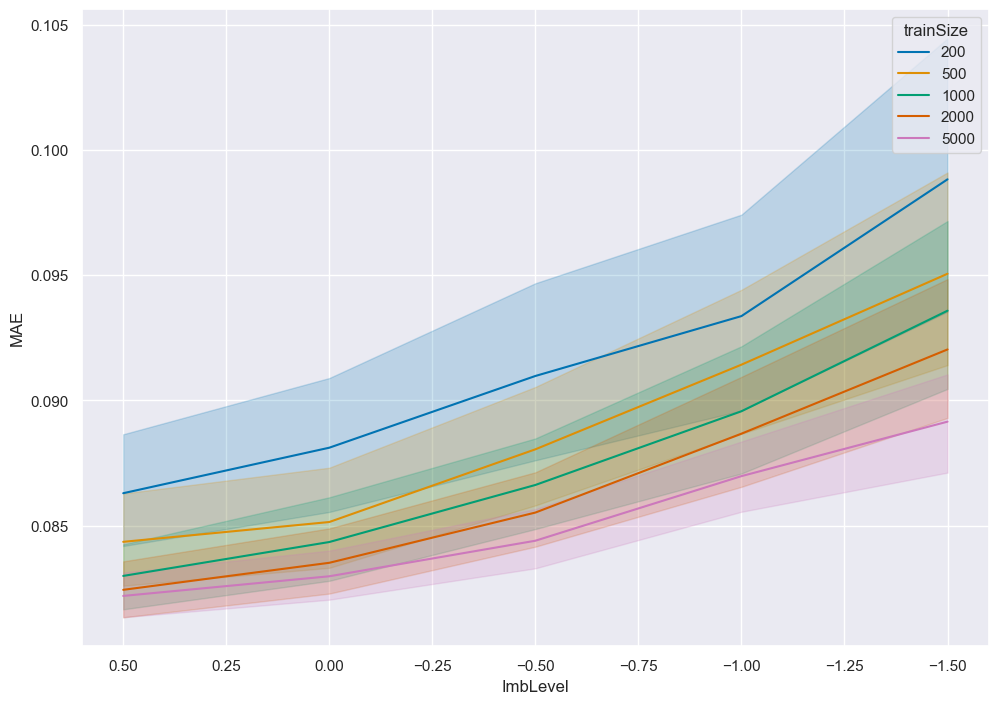

In [11]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x='ImbLevel', y='MAE',hue='trainSize', data=res_MAE_l, palette='colorblind')
plt.gca().invert_xaxis()
plt.savefig(rep+'/plot_MAE_imb.png')

In [12]:
MAE_per_run_bal = res_preds_l.groupby("run").apply(lambda x: mean_absolute_error(x["obs"], x["Bal"]) if len(x["obs"].unique()) > 1 else None)
# Convertir en dataframe
MAE_per_run_bal = MAE_per_run_bal.reset_index().rename(columns={0: "MAE_bal"})
res_MAE_l = pd.merge(res_MAE_l, MAE_per_run_bal, on='run', how='inner')
res_MAE_l

run  Complexity  trainSize  ImbLevel  seed       imb       bal       MAE  \
0      0           1        200       0.5   668  0.010982  0.011559  0.084888   
1      0           1        200       0.5   994  0.011684  0.010958  0.084888   
2      1           1        500       0.5   668  0.010885  0.010638  0.083165   
3      1           1        500       0.5   994  0.010924  0.010962  0.083165   
4      2           1       1000       0.5   668  0.010739  0.010500  0.082657   
..   ...         ...        ...       ...   ...       ...       ...       ...   
620  370           5        200      -1.5   160  0.025426  0.016227  0.124539   
621  371           5        500      -1.5   160  0.024598  0.014770  0.121842   
622  372           5       1000      -1.5   160  0.021541  0.013497  0.114198   
623  373           5       2000      -1.5   160  0.018497  0.012826  0.106989   
624  374           5       5000      -1.5   160  0.014761  0.012569  0.095863   

      MAE_bal  
0    0.084310  
1    0.084310  
2    0.082771  
3    0.082771  
4    0.081747  
..        ...  
620  0.101767  
621  0.096132  
622  0.092774  
623  0.090103  
624  0.089825  

[625 rows x 9 columns]

In [13]:
data.shape

(10000, 11)

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\4073389601.py:2: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.lineplot(x='ImbLevel', y='MAE',hue='trainSize', data=res_MAE_l, palette=sns.color_palette(palette='Reds_d'))
C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\4073389601.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.lineplot(x='ImbLevel', y='MAE_bal',hue='trainSize', data=res_MAE_l, palette=sns.color_palette(palette='Greens_d'))


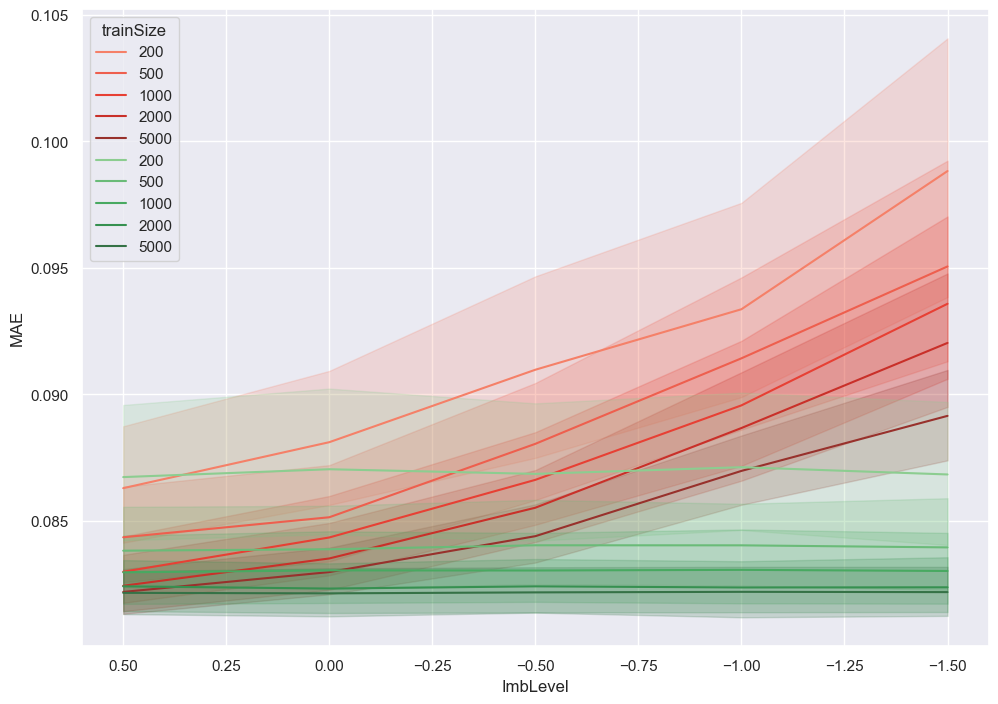

In [14]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x='ImbLevel', y='MAE',hue='trainSize', data=res_MAE_l, palette=sns.color_palette(palette='Reds_d'))
sns.lineplot(x='ImbLevel', y='MAE_bal',hue='trainSize', data=res_MAE_l, palette=sns.color_palette(palette='Greens_d'))
plt.gca().invert_xaxis()
plt.savefig(rep+'/plot_MAE_imb_vs_bal.png')

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\1708272697.py:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.boxplot(x='ImbLevel', y='MAE',hue='trainSize', data=res_MAE_l, palette=sns.color_palette(palette='colorblind'))


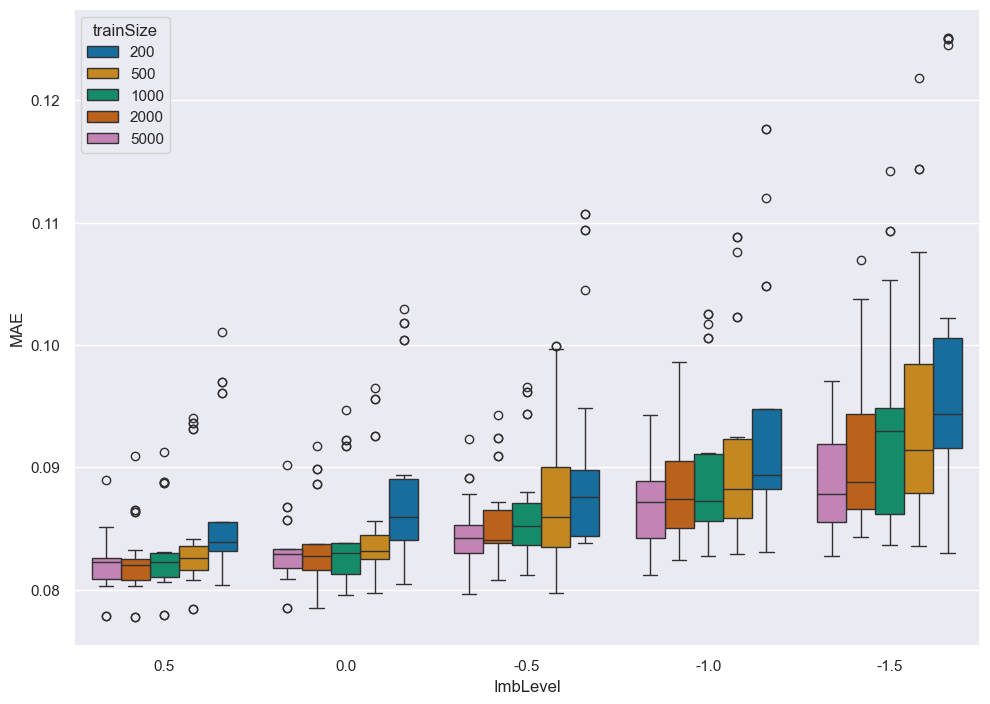

In [15]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='ImbLevel', y='MAE',hue='trainSize', data=res_MAE_l, palette=sns.color_palette(palette='colorblind'))
plt.gca().invert_xaxis()
plt.savefig(rep+'/boxplot_MAE_imb_trainSize.png')

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\3843968462.py:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.boxplot(x='ImbLevel', y='MAE',hue='Complexity', data=res_MAE_l, palette=sns.color_palette(palette='colorblind'))


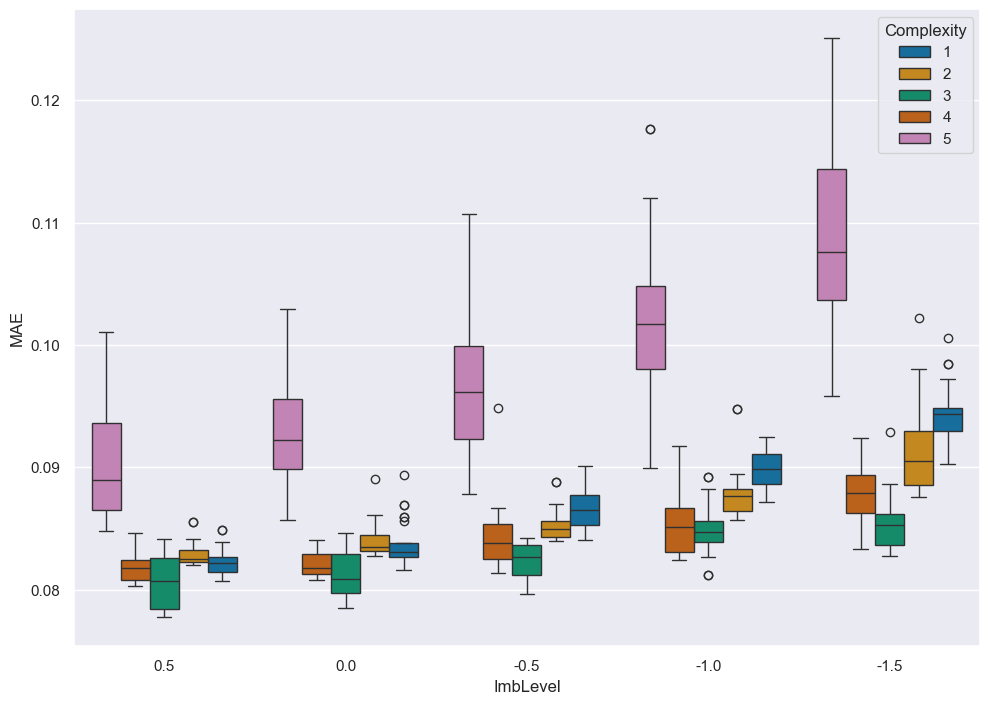

In [16]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='ImbLevel', y='MAE',hue='Complexity', data=res_MAE_l, palette=sns.color_palette(palette='colorblind'))
plt.gca().invert_xaxis()
plt.savefig(rep+'/boxplot_MAE_imb_Complexity.png')

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\2695731476.py:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.boxplot(x='ImbLevel', y='MAE',hue='trainSize', data=res_MAE_l, palette=sns.color_palette(palette='colorblind'))
C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\2695731476.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(x='ImbLevel', y='MAE_bal',hue='trainSize', data=res_MAE_l, palette=sns.color_palette(palette='Greens_d'))


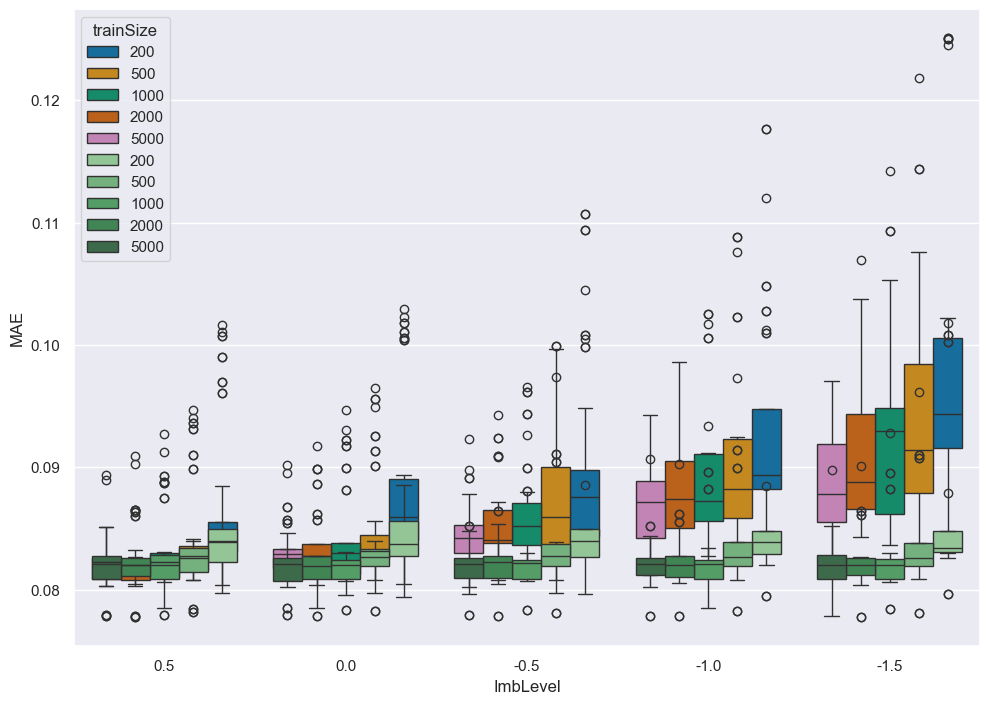

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='ImbLevel', y='MAE',hue='trainSize', data=res_MAE_l, palette=sns.color_palette(palette='colorblind'))
sns.boxplot(x='ImbLevel', y='MAE_bal',hue='trainSize', data=res_MAE_l, palette=sns.color_palette(palette='Greens_d'))
plt.gca().invert_xaxis()
plt.savefig(rep+'/boxplot_MAE_imb_vs_bal_trainSize.png')

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\260260613.py:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.boxplot(x='ImbLevel', y='MAE',hue='Complexity', data=res_MAE_l, palette=sns.color_palette(palette='colorblind'))
C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\260260613.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(x='ImbLevel', y='MAE_bal',hue='Complexity', data=res_MAE_l, palette=sns.color_palette(palette='Greens_d'))


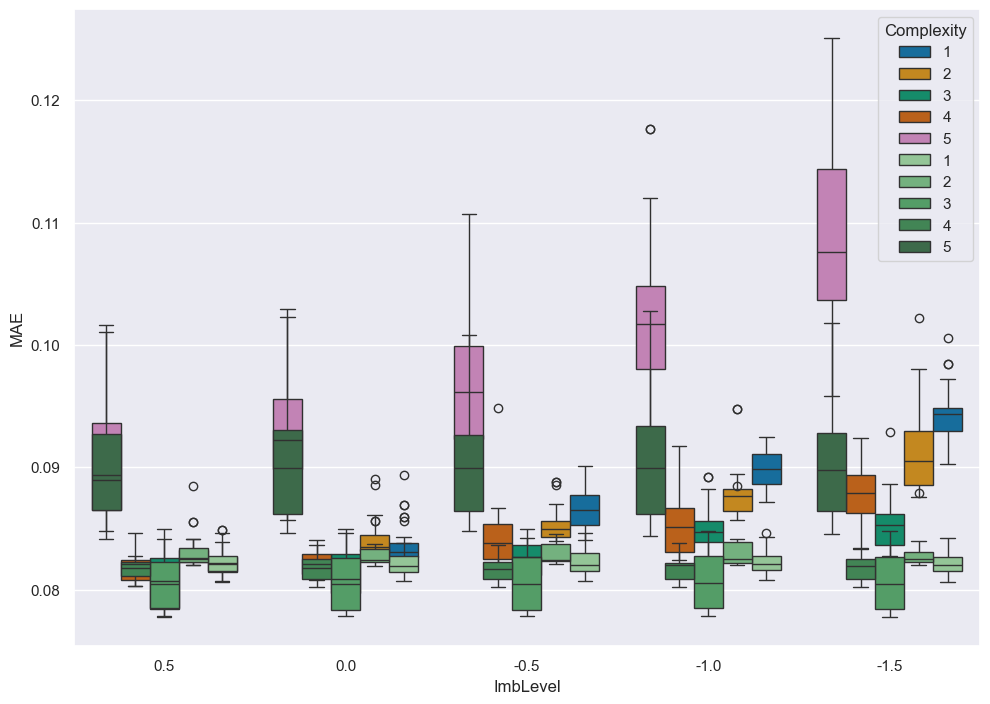

In [18]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='ImbLevel', y='MAE',hue='Complexity', data=res_MAE_l, palette=sns.color_palette(palette='colorblind'))
sns.boxplot(x='ImbLevel', y='MAE_bal',hue='Complexity', data=res_MAE_l, palette=sns.color_palette(palette='Greens_d'))
plt.gca().invert_xaxis()
plt.savefig(rep+'/boxplot_MAE_imb_vs_bal_Complexity.png')

#### MAPE

In [19]:
MAPE_per_run = res_preds_l.groupby("run").apply(lambda x: mean_absolute_percentage_error(x["obs"], x["Imb"]) if len(x["obs"].unique()) > 1 else None)
# Convertir en dataframe
MAPE_per_run = MAPE_per_run.reset_index().rename(columns={0: "MAPE"})
res_MAPE_l = pd.merge(res_MSE_l, MAPE_per_run, on='run', how='inner')
res_MAPE_l

run  Complexity  trainSize  ImbLevel  seed       imb       bal      MAPE
0      0           1       0.02       0.5   668  0.010982  0.011559  0.034840
1      0           1       0.02       0.5   994  0.011684  0.010958  0.034840
2      1           1       0.05       0.5   668  0.010885  0.010638  0.034110
3      1           1       0.05       0.5   994  0.010924  0.010962  0.034110
4      2           1       0.10       0.5   668  0.010739  0.010500  0.033909
..   ...         ...        ...       ...   ...       ...       ...       ...
620  370           5       0.02      -1.5   160  0.025426  0.016227  0.395420
621  371           5       0.05      -1.5   160  0.024598  0.014770  0.388329
622  372           5       0.10      -1.5   160  0.021541  0.013497  0.371139
623  373           5       0.20      -1.5   160  0.018497  0.012826  0.365387
624  374           5       0.50      -1.5   160  0.014761  0.012569  0.340666

[625 rows x 8 columns]

In [20]:
res_MAPE_l.trainSize = res_MAPE_l.trainSize * data.shape[0]
res_MAPE_l.trainSize = res_MAPE_l.trainSize.astype(int)

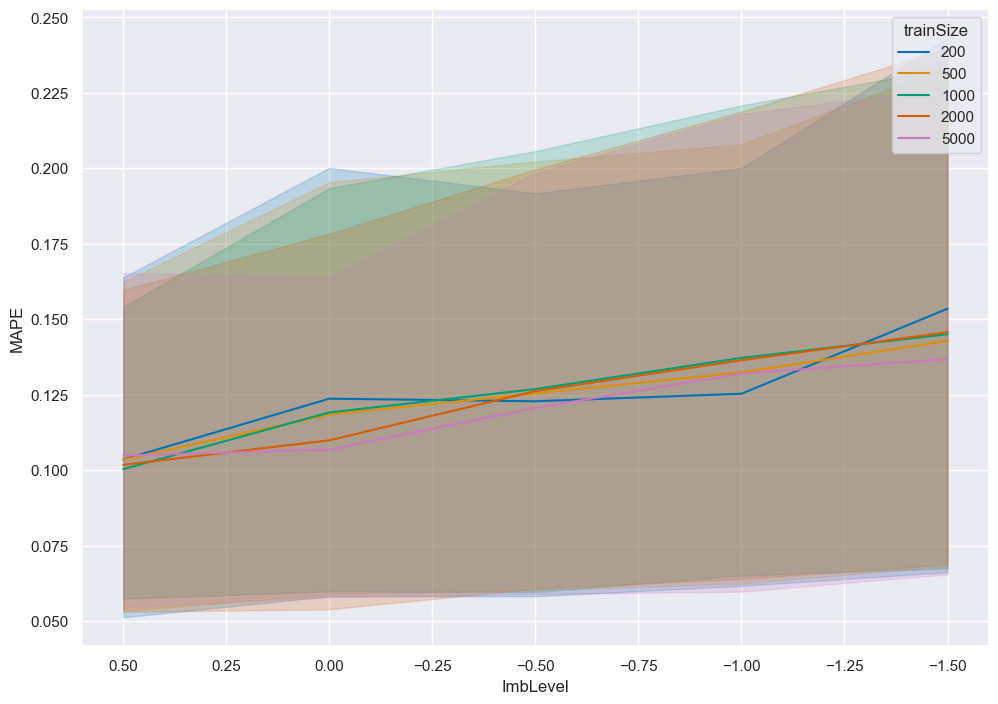

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x='ImbLevel', y='MAPE',hue='trainSize', data=res_MAPE_l, palette='colorblind')
plt.gca().invert_xaxis()
plt.savefig(rep+'/plot_MAPE_imb.png')

In [22]:
MAPE_per_run_bal = res_preds_l.groupby("run").apply(lambda x: mean_absolute_percentage_error(x["obs"], x["Bal"]) if len(x["obs"].unique()) > 1 else None)
# Convertir en dataframe
MAPE_per_run_bal = MAPE_per_run_bal.reset_index().rename(columns={0: "MAPE_bal"})
res_MAPE_l = pd.merge(res_MAPE_l, MAPE_per_run_bal, on='run', how='inner')
res_MAPE_l

run  Complexity  trainSize  ImbLevel  seed       imb       bal      MAPE  \
0      0           1        200       0.5   668  0.010982  0.011559  0.034840   
1      0           1        200       0.5   994  0.011684  0.010958  0.034840   
2      1           1        500       0.5   668  0.010885  0.010638  0.034110   
3      1           1        500       0.5   994  0.010924  0.010962  0.034110   
4      2           1       1000       0.5   668  0.010739  0.010500  0.033909   
..   ...         ...        ...       ...   ...       ...       ...       ...   
620  370           5        200      -1.5   160  0.025426  0.016227  0.395420   
621  371           5        500      -1.5   160  0.024598  0.014770  0.388329   
622  372           5       1000      -1.5   160  0.021541  0.013497  0.371139   
623  373           5       2000      -1.5   160  0.018497  0.012826  0.365387   
624  374           5       5000      -1.5   160  0.014761  0.012569  0.340666   

     MAPE_bal  
0    0.034541  
1    0.034541  
2    0.033908  
3    0.033908  
4    0.033566  
..        ...  
620  0.274485  
621  0.264426  
622  0.263995  
623  0.262586  
624  0.260152  

[625 rows x 9 columns]

In [23]:
data.shape

(10000, 11)

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\2698837506.py:2: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.lineplot(x='ImbLevel', y='MAPE',hue='trainSize', data=res_MAPE_l, palette=sns.color_palette(palette='Reds_d'))
C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\2698837506.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.lineplot(x='ImbLevel', y='MAPE_bal',hue='trainSize', data=res_MAPE_l, palette=sns.color_palette(palette='Greens_d'))


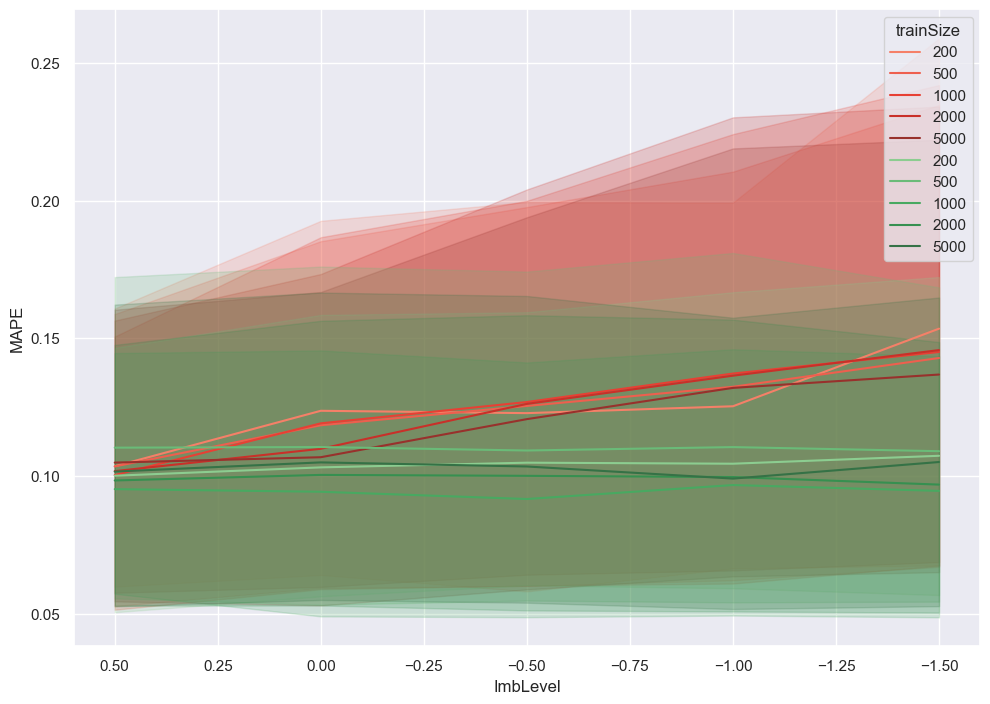

In [24]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x='ImbLevel', y='MAPE',hue='trainSize', data=res_MAPE_l, palette=sns.color_palette(palette='Reds_d'))
sns.lineplot(x='ImbLevel', y='MAPE_bal',hue='trainSize', data=res_MAPE_l, palette=sns.color_palette(palette='Greens_d'))
plt.gca().invert_xaxis()
plt.savefig(rep+'/plot_MAPE_imb_vs_bal.png')

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\3407473840.py:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.boxplot(x='ImbLevel', y='MAPE',hue='trainSize', data=res_MAPE_l, palette=sns.color_palette(palette='colorblind'))
C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\3407473840.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(x='ImbLevel', y='MAPE_bal',hue='trainSize', data=res_MAPE_l, palette=sns.color_palette(palette='Greens_d'))


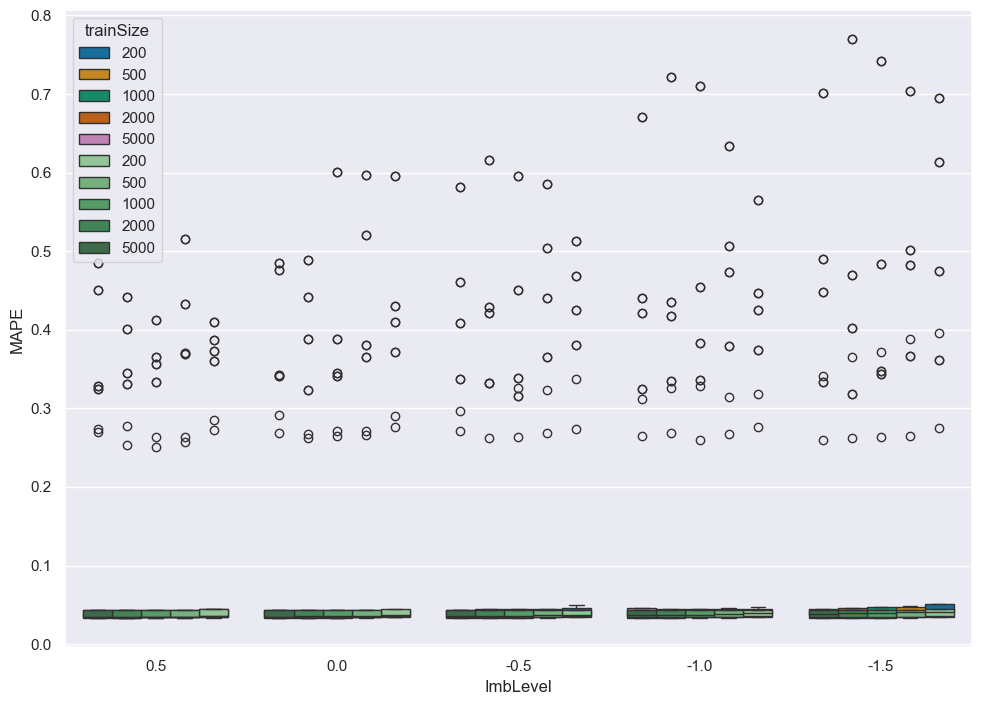

In [25]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='ImbLevel', y='MAPE',hue='trainSize', data=res_MAPE_l, palette=sns.color_palette(palette='colorblind'))
sns.boxplot(x='ImbLevel', y='MAPE_bal',hue='trainSize', data=res_MAPE_l, palette=sns.color_palette(palette='Greens_d'))
plt.gca().invert_xaxis()
plt.savefig(rep+'/boxplot_MAPE_imb_vs_bal.png')

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\2929188659.py:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.boxplot(x='ImbLevel', y='MAPE',hue='trainSize', data=res_MAPE_l, palette=sns.color_palette(palette='colorblind'))


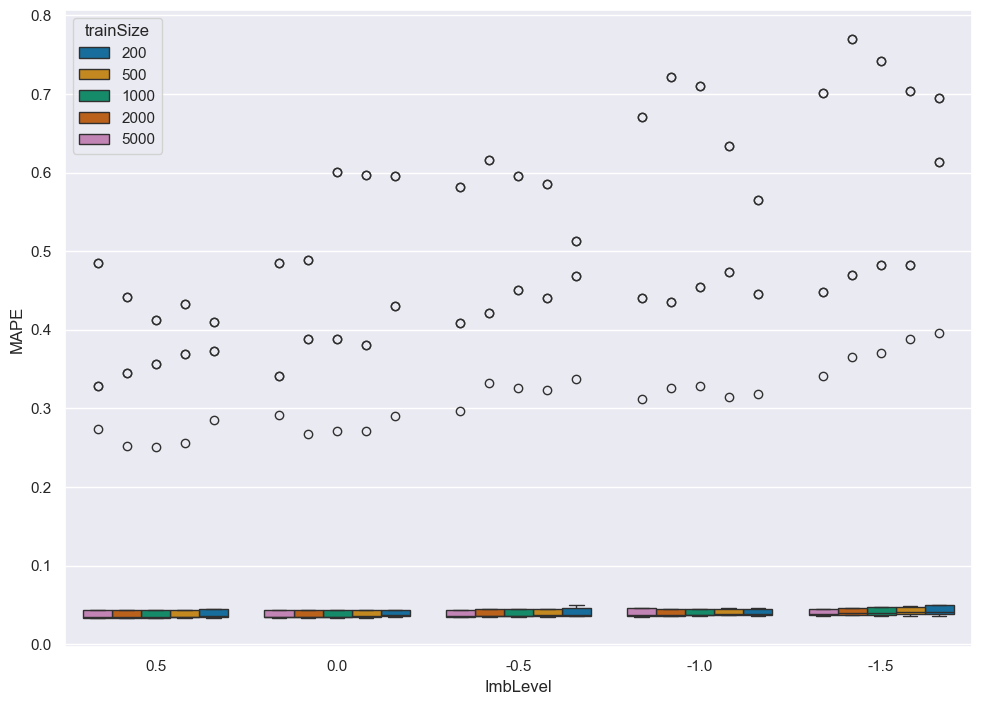

In [26]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='ImbLevel', y='MAPE',hue='trainSize', data=res_MAPE_l, palette=sns.color_palette(palette='colorblind'))
plt.gca().invert_xaxis()
plt.savefig(rep+'/boxplot_MAPE_imb.png')

#### RMSE

In [27]:
RMSE_per_run = res_preds_l.groupby("run").apply(lambda x: root_mean_squared_error(x["obs"], x["Imb"]) if len(x["obs"].unique()) > 1 else None)
# Convertir en dataframe
RMSE_per_run = RMSE_per_run.reset_index().rename(columns={0: "RMSE"})
res_RMSE_l = pd.merge(res_MSE_l, RMSE_per_run, on='run', how='inner')
res_RMSE_l

run  Complexity  trainSize  ImbLevel  seed       imb       bal      RMSE
0      0           1       0.02       0.5   668  0.010982  0.011559  0.106458
1      0           1       0.02       0.5   994  0.011684  0.010958  0.106458
2      1           1       0.05       0.5   668  0.010885  0.010638  0.104425
3      1           1       0.05       0.5   994  0.010924  0.010962  0.104425
4      2           1       0.10       0.5   668  0.010739  0.010500  0.103736
..   ...         ...        ...       ...   ...       ...       ...       ...
620  370           5       0.02      -1.5   160  0.025426  0.016227  0.159456
621  371           5       0.05      -1.5   160  0.024598  0.014770  0.156837
622  372           5       0.10      -1.5   160  0.021541  0.013497  0.146770
623  373           5       0.20      -1.5   160  0.018497  0.012826  0.136003
624  374           5       0.50      -1.5   160  0.014761  0.012569  0.121496

[625 rows x 8 columns]

In [28]:
res_RMSE_l[(res_RMSE_l.trainSize==2994) & (res_RMSE_l.ImbLevel==0.5)]

Empty DataFrame
Columns: [run, Complexity, trainSize, ImbLevel, seed, imb, bal, RMSE]
Index: []

In [29]:
res_RMSE_l.trainSize = res_RMSE_l.trainSize * data.shape[0]
res_RMSE_l.trainSize = res_RMSE_l.trainSize.astype(int)

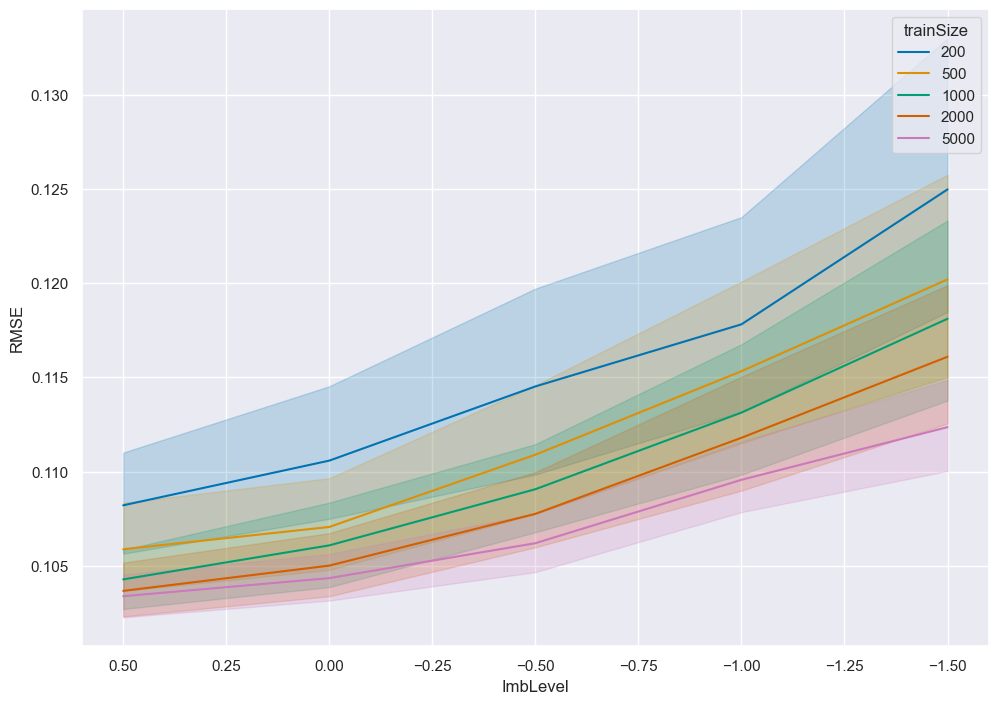

In [30]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x='ImbLevel', y='RMSE',hue='trainSize', data=res_RMSE_l, palette='colorblind')
plt.gca().invert_xaxis()
plt.savefig(rep+'/plot_RMSE_imb.png')

In [31]:
RMSE_per_run_bal = res_preds_l.groupby("run").apply(lambda x: root_mean_squared_error(x["obs"], x["Bal"]) if len(x["obs"].unique()) > 1 else None)
# Convertir en dataframe
RMSE_per_run_bal = RMSE_per_run_bal.reset_index().rename(columns={0: "RMSE_bal"})
res_RMSE_l = pd.merge(res_RMSE_l, RMSE_per_run_bal, on='run', how='inner')
res_RMSE_l

run  Complexity  trainSize  ImbLevel  seed       imb       bal      RMSE  \
0      0           1        200       0.5   668  0.010982  0.011559  0.106458   
1      0           1        200       0.5   994  0.011684  0.010958  0.106458   
2      1           1        500       0.5   668  0.010885  0.010638  0.104425   
3      1           1        500       0.5   994  0.010924  0.010962  0.104425   
4      2           1       1000       0.5   668  0.010739  0.010500  0.103736   
..   ...         ...        ...       ...   ...       ...       ...       ...   
620  370           5        200      -1.5   160  0.025426  0.016227  0.159456   
621  371           5        500      -1.5   160  0.024598  0.014770  0.156837   
622  372           5       1000      -1.5   160  0.021541  0.013497  0.146770   
623  373           5       2000      -1.5   160  0.018497  0.012826  0.136003   
624  374           5       5000      -1.5   160  0.014761  0.012569  0.121496   

     RMSE_bal  
0    0.106108  
1    0.106108  
2    0.103923  
3    0.103923  
4    0.102892  
..        ...  
620  0.127385  
621  0.121531  
622  0.116176  
623  0.113252  
624  0.112112  

[625 rows x 9 columns]

In [32]:
data.shape

(10000, 11)

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\1258093364.py:2: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.lineplot(x='ImbLevel', y='RMSE',hue='trainSize', data=res_RMSE_l, palette=sns.color_palette(palette='Reds_d'))
C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\1258093364.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.lineplot(x='ImbLevel', y='RMSE_bal',hue='trainSize', data=res_RMSE_l, palette=sns.color_palette(palette='Greens_d'))


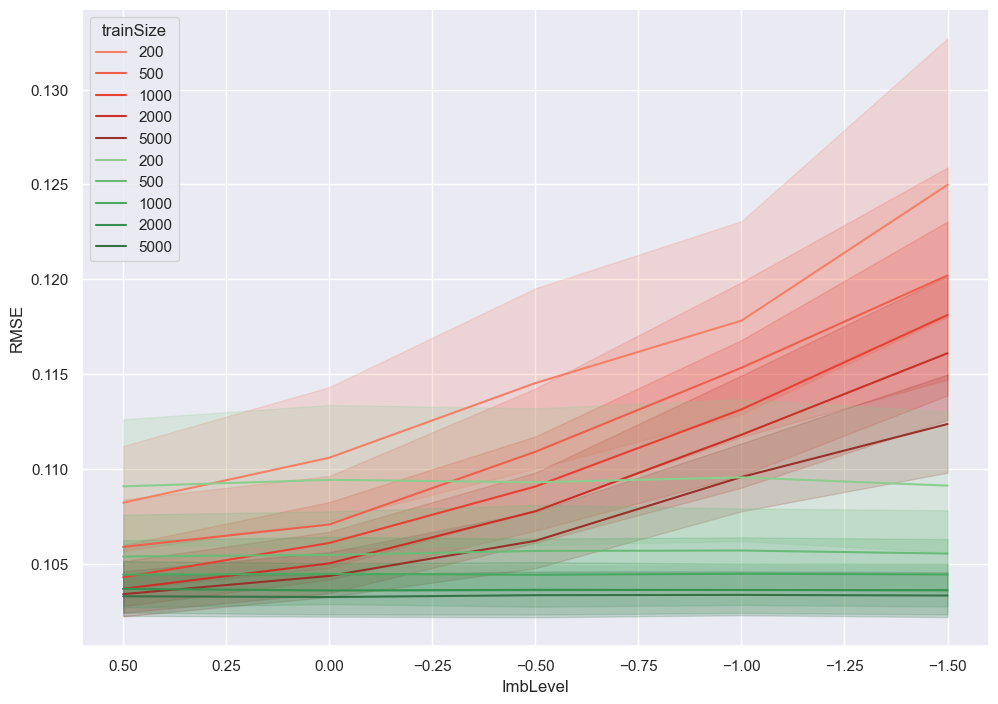

In [33]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x='ImbLevel', y='RMSE',hue='trainSize', data=res_RMSE_l, palette=sns.color_palette(palette='Reds_d'))
sns.lineplot(x='ImbLevel', y='RMSE_bal',hue='trainSize', data=res_RMSE_l, palette=sns.color_palette(palette='Greens_d'))
plt.gca().invert_xaxis()
plt.savefig(rep+'/plot_RMSE_imb_vs_bal.png')

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\706140306.py:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.boxplot(x='ImbLevel', y='RMSE',hue='trainSize', data=res_RMSE_l, palette=sns.color_palette(palette='colorblind'))
C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\706140306.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(x='ImbLevel', y='RMSE_bal',hue='trainSize', data=res_RMSE_l, palette=sns.color_palette(palette='Greens_d'))


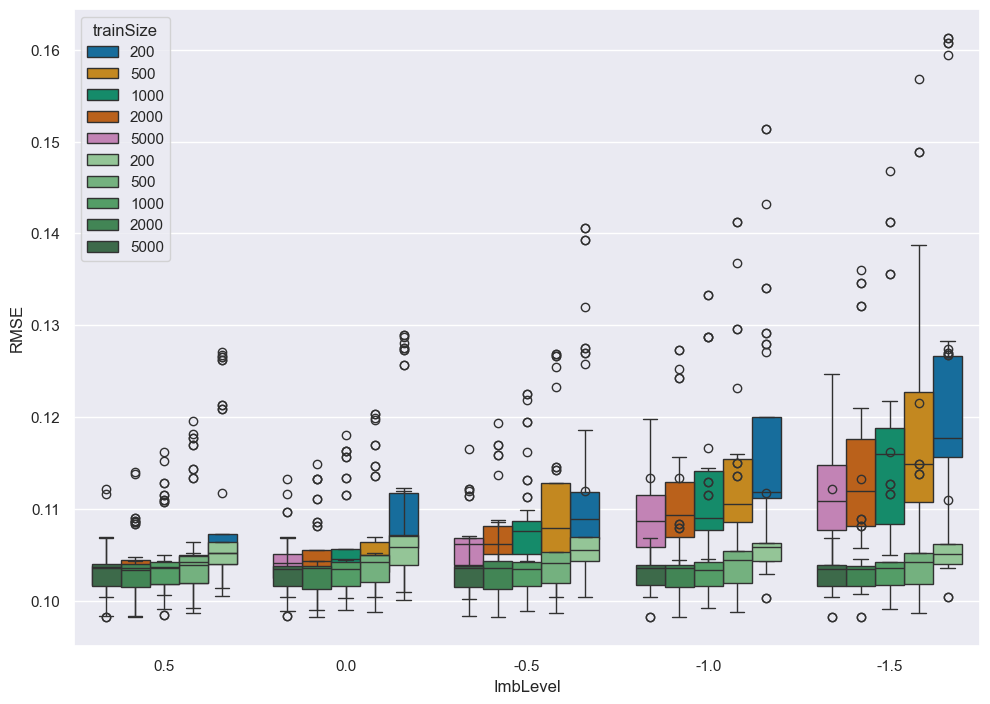

In [34]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='ImbLevel', y='RMSE',hue='trainSize', data=res_RMSE_l, palette=sns.color_palette(palette='colorblind'))
sns.boxplot(x='ImbLevel', y='RMSE_bal',hue='trainSize', data=res_RMSE_l, palette=sns.color_palette(palette='Greens_d'))
plt.gca().invert_xaxis()
# plt.ylim(2500, 5000)
plt.savefig(rep+'/boxplot_RMSE_imb_vs_bal_trainSize.png')

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\2532016492.py:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.boxplot(x='ImbLevel', y='RMSE',hue='Complexity', data=res_RMSE_l, palette=sns.color_palette(palette='colorblind'))
C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\2532016492.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(x='ImbLevel', y='RMSE_bal',hue='Complexity', data=res_RMSE_l, palette=sns.color_palette(palette='Greens_d'))


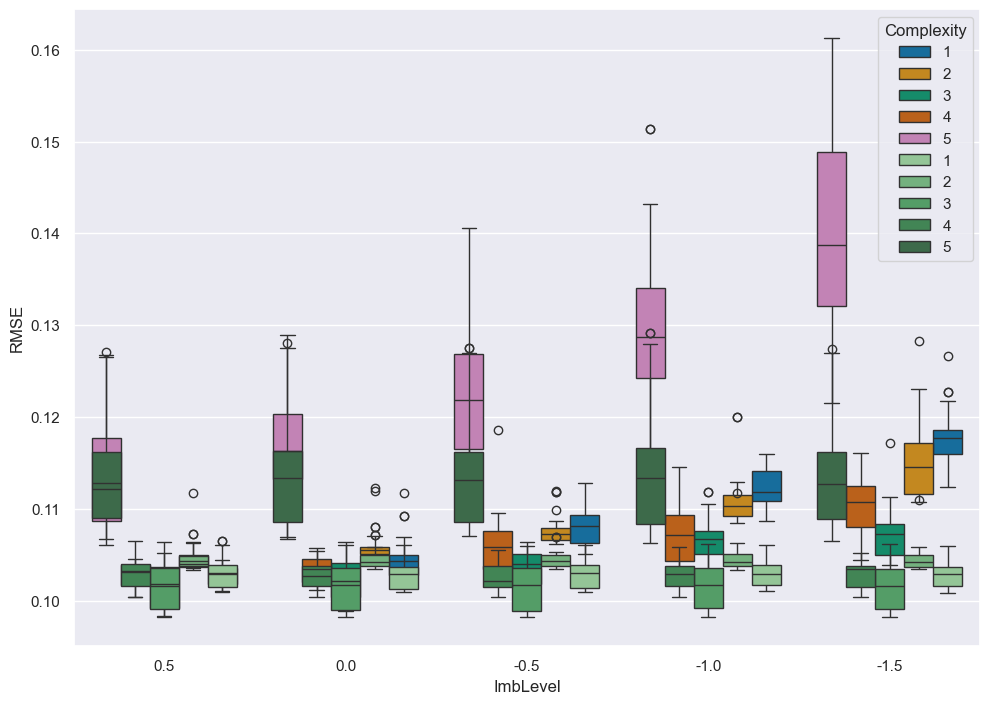

In [35]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='ImbLevel', y='RMSE',hue='Complexity', data=res_RMSE_l, palette=sns.color_palette(palette='colorblind'))
sns.boxplot(x='ImbLevel', y='RMSE_bal',hue='Complexity', data=res_RMSE_l, palette=sns.color_palette(palette='Greens_d'))
plt.gca().invert_xaxis()
# plt.ylim(2500, 5000)
plt.savefig(rep+'/boxplot_RMSE_imb_vs_bal_Complexity.png')

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\2000244315.py:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.boxplot(x='ImbLevel', y='RMSE',hue='trainSize', data=res_RMSE_l, palette=sns.color_palette(palette='colorblind'))


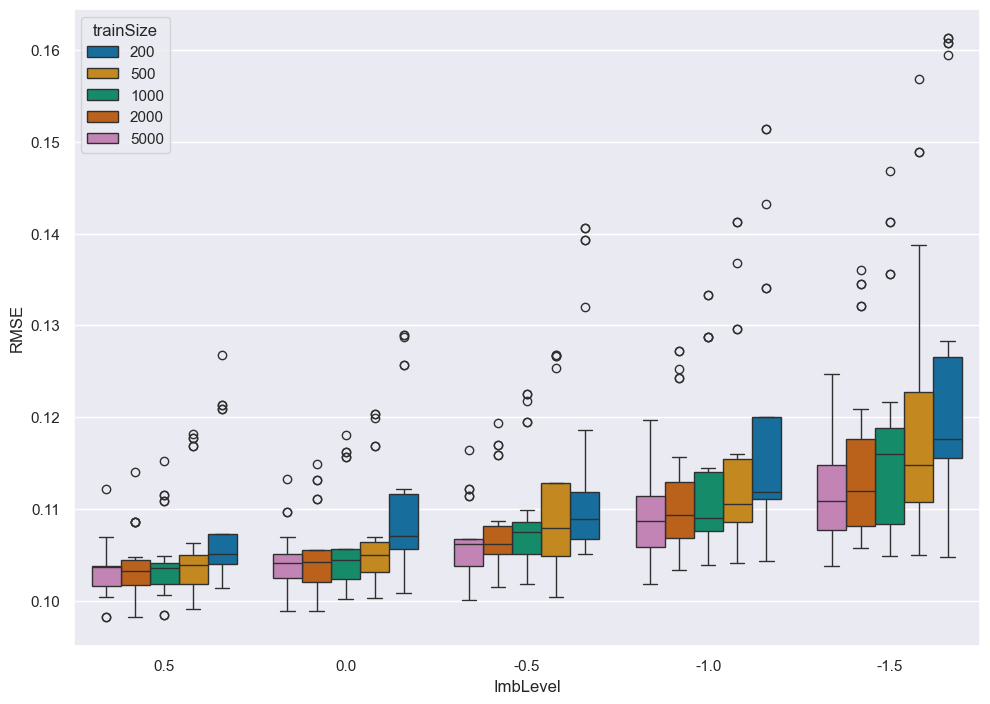

In [36]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='ImbLevel', y='RMSE',hue='trainSize', data=res_RMSE_l, palette=sns.color_palette(palette='colorblind'))
plt.gca().invert_xaxis()
# plt.ylim(2500, 5000)
plt.savefig(rep+'/boxplot_RMSE_imb_trainSize.png')

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\3928626578.py:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.boxplot(x='ImbLevel', y='RMSE',hue='Complexity', data=res_RMSE_l, palette=sns.color_palette(palette='colorblind'))


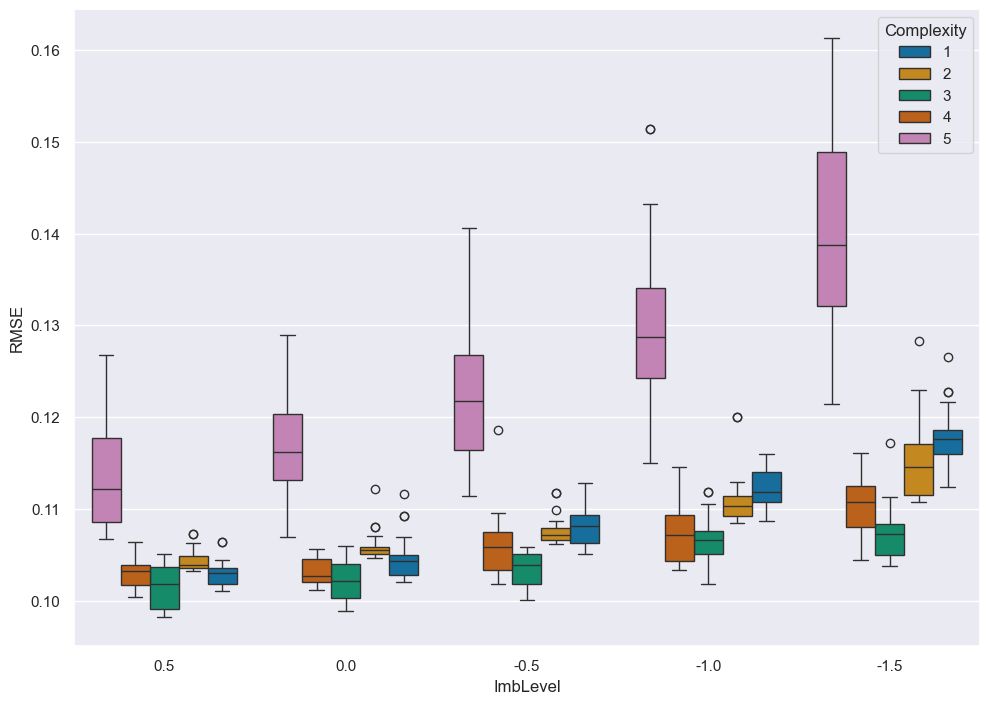

In [37]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='ImbLevel', y='RMSE',hue='Complexity', data=res_RMSE_l, palette=sns.color_palette(palette='colorblind'))
plt.gca().invert_xaxis()
# plt.ylim(2500, 5000)
plt.savefig(rep+'/boxplot_RMSE_imb_Complexity.png')

#### Erreur vs Y

In [38]:
Compl = 1

In [39]:
preds = res_preds_l.copy()
preds=pd.merge(res_MSE_l.drop(columns=['imb','bal']), preds, on='run', how='inner')
preds['mae_Imb'] = np.abs(preds.Imb-preds.obs)
preds['mae_Bal'] = np.abs(preds.Bal-preds.obs)
preds['rmse_Imb'] = np.sqrt((preds.Imb-preds.obs)**2)
preds['rmse_Bal'] = np.sqrt((preds.Bal-preds.obs)**2)
preds

run  Complexity  trainSize  ImbLevel  seed       obs        w_test  \
0          0           1       0.02       0.5   668  2.393184  8.927285e-04   
1          0           1       0.02       0.5   668  2.603184  8.626082e-04   
2          0           1       0.02       0.5   668  2.952597  8.947148e-04   
3          0           1       0.02       0.5   668  3.032681  9.389317e-04   
4          0           1       0.02       0.5   668  3.224732  1.063208e-03   
...      ...         ...        ...       ...   ...       ...           ...   
1124995  374           5       0.50      -1.5   160  0.340951  7.791708e-20   
1124996  374           5       0.50      -1.5   160  1.377084  5.044146e-30   
1124997  374           5       0.50      -1.5   160  1.592190  3.181836e-30   
1124998  374           5       0.50      -1.5   160  0.900571  1.185227e-28   
1124999  374           5       0.50      -1.5   160  0.490324  3.745768e-23   

              Imb       Bal   mae_Imb   mae_Bal  rmse_Imb  rmse_Bal  
0        2.238176  2.205121  0.155007  0.188062  0.155007  0.188062  
1        2.575051  2.558999  0.028133  0.044185  0.028133  0.044185  
2        3.176413  3.164221  0.223816  0.211623  0.223816  0.211623  
3        3.070621  3.073661  0.037940  0.040980  0.037940  0.040980  
4        3.202307  3.223985  0.022424  0.000746  0.022424  0.000746  
...           ...       ...       ...       ...       ...       ...  
1124995  0.306320  0.240651  0.034631  0.100300  0.034631  0.100300  
1124996  1.163932  1.164435  0.213152  0.212649  0.213152  0.212649  
1124997  1.345965  1.405712  0.246225  0.186478  0.246225  0.186478  
1124998  0.987317  0.956666  0.086746  0.056095  0.086746  0.056095  
1124999  0.534288  0.520256  0.043963  0.029932  0.043963  0.029932  

[1125000 rows x 13 columns]

In [40]:
preds = preds[preds.Complexity==Compl]

<Axes: xlabel='obs', ylabel='Count'>

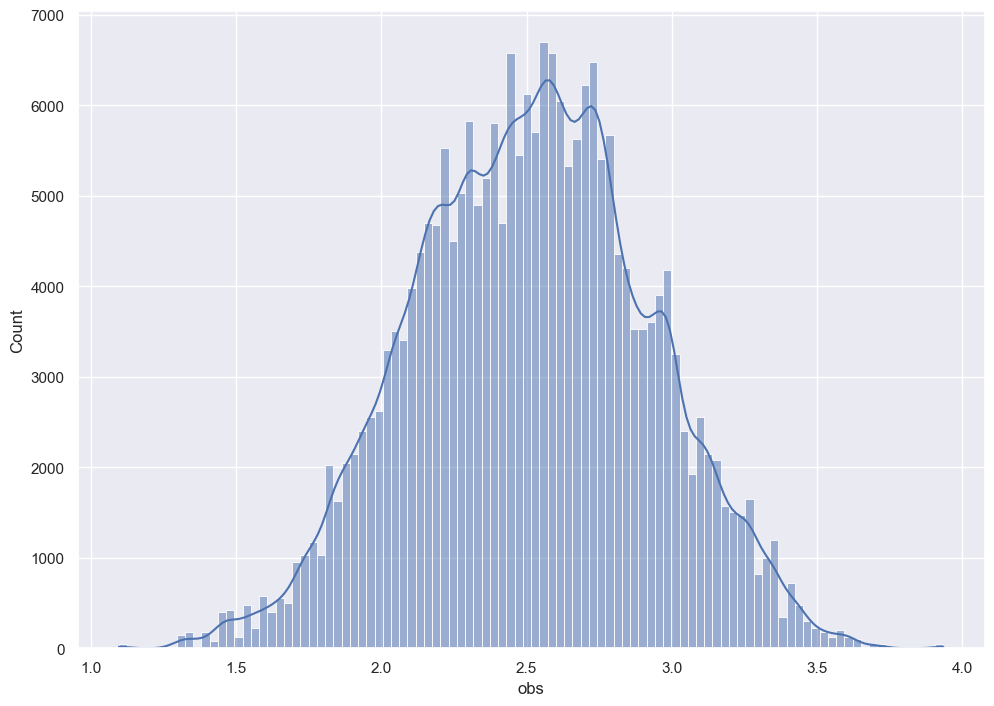

In [41]:
sns.histplot(preds.obs, kde=True,bins=100)

In [42]:
# kde_test = gaussian_kde(preds.obs)
# w_test = kde_test.evaluate(preds.obs)

In [43]:
# sns.lineplot(x=preds.obs, y=preds.w_test)

In [44]:
preds['D_w'] = pd.qcut(preds.obs,10, labels=[f"D{i}" for i in range(1, 11)])
preds['C_w'] = pd.qcut(preds.obs,100, labels=[f"C{i}" for i in range(1, 101)])

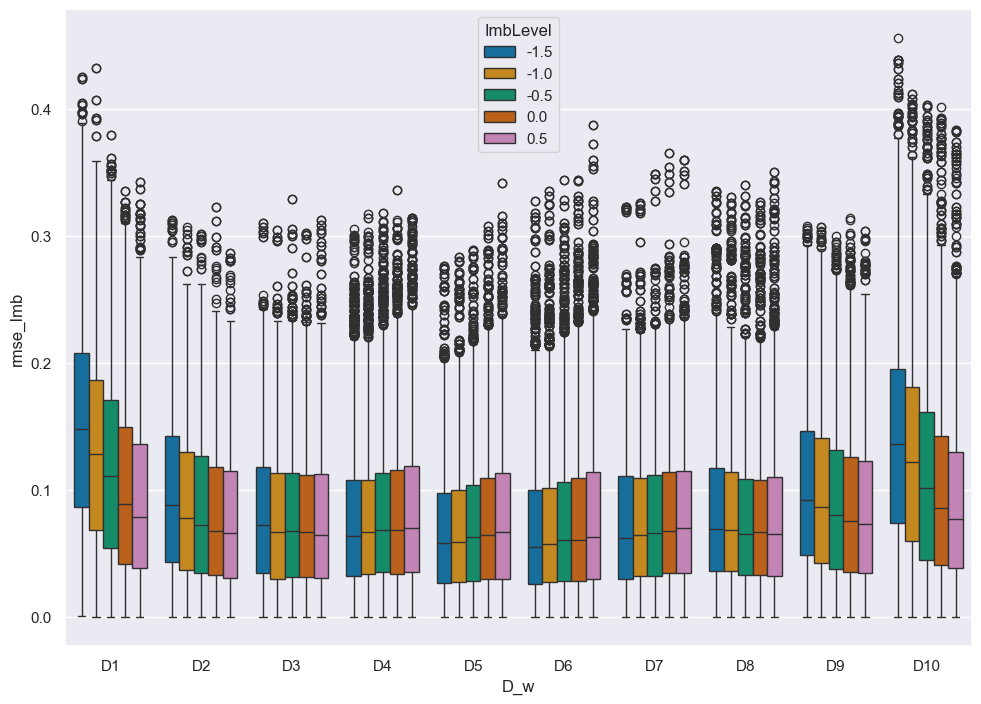

In [45]:
sns.boxplot(x='D_w', y='rmse_Imb',hue='ImbLevel', data=preds, palette='colorblind')
# plt.ylim(-1000, 15000)
plt.savefig(rep+'/boxplot_rmse_y_ImbLevel.png')

In [46]:
preds.groupby('D_w').rmse_Imb.mean()

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\1058787956.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  preds.groupby('D_w').rmse_Imb.mean()


D_w
D1     0.119219
D2     0.086015
D3     0.077672
D4     0.080341
D5     0.072893
D6     0.074168
D7     0.076878
D8     0.079180
D9     0.091912
D10    0.114066
Name: rmse_Imb, dtype: float64

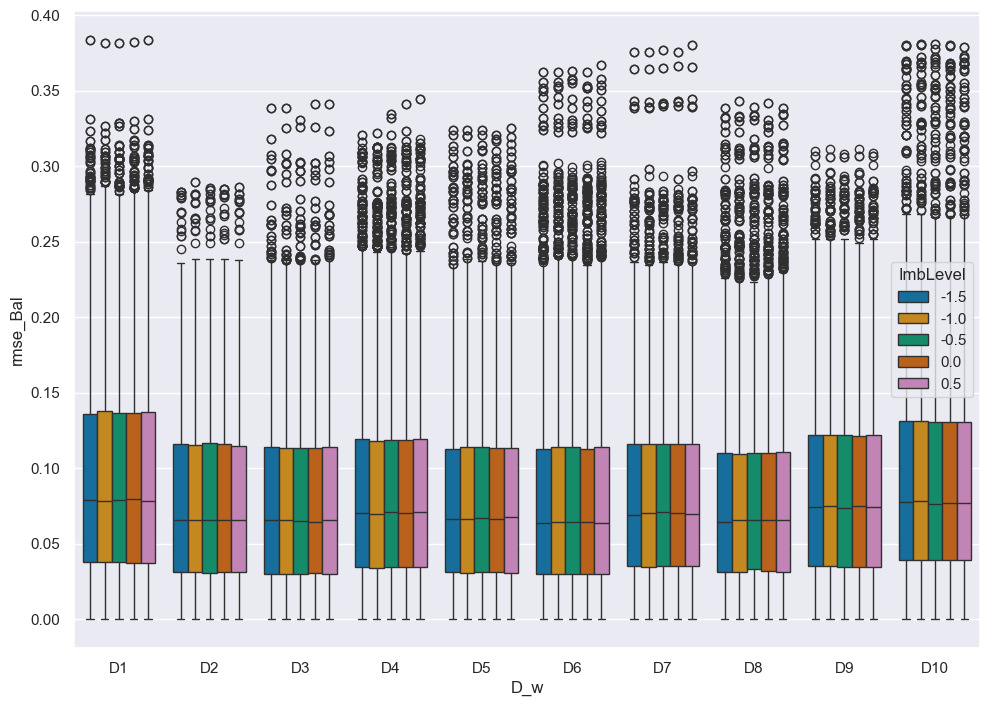

In [54]:
sns.boxplot(x='D_w', y='rmse_Bal',hue='ImbLevel', data=preds, palette='colorblind')
# plt.ylim(-1000, 15000)
plt.savefig(rep+'/boxplot_rmse_y_ImbLevel_Bal.png')

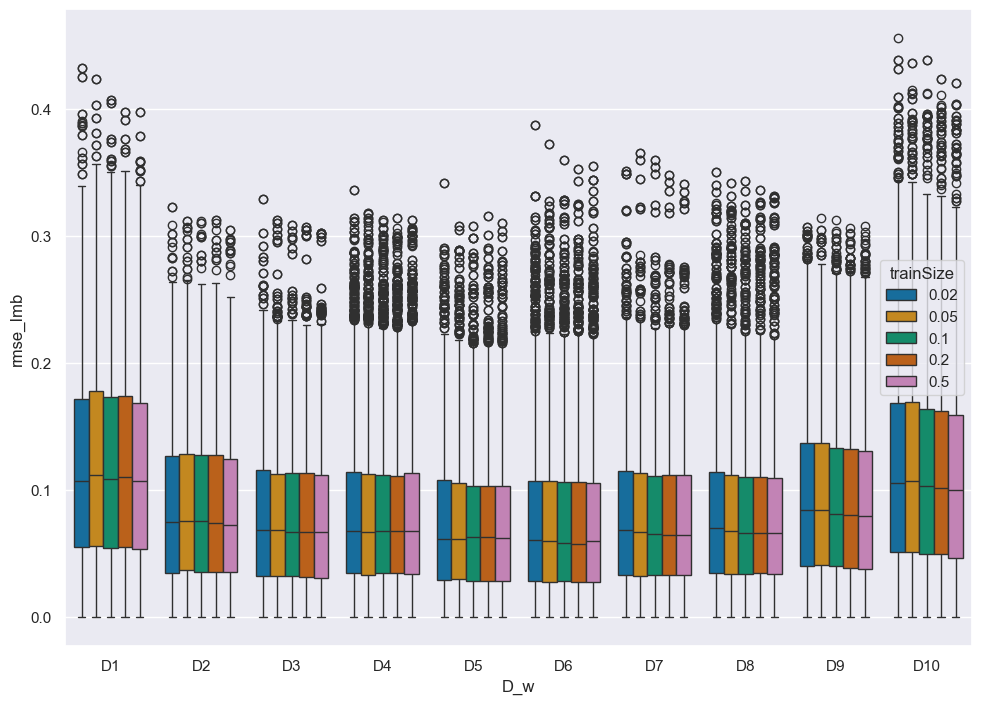

In [55]:
sns.boxplot(x='D_w', y='rmse_Imb',hue='trainSize', data=preds, palette='colorblind')
# plt.ylim(-1000, 15000)
plt.savefig(rep+'/boxplot_rmse_y_trainSize.png')

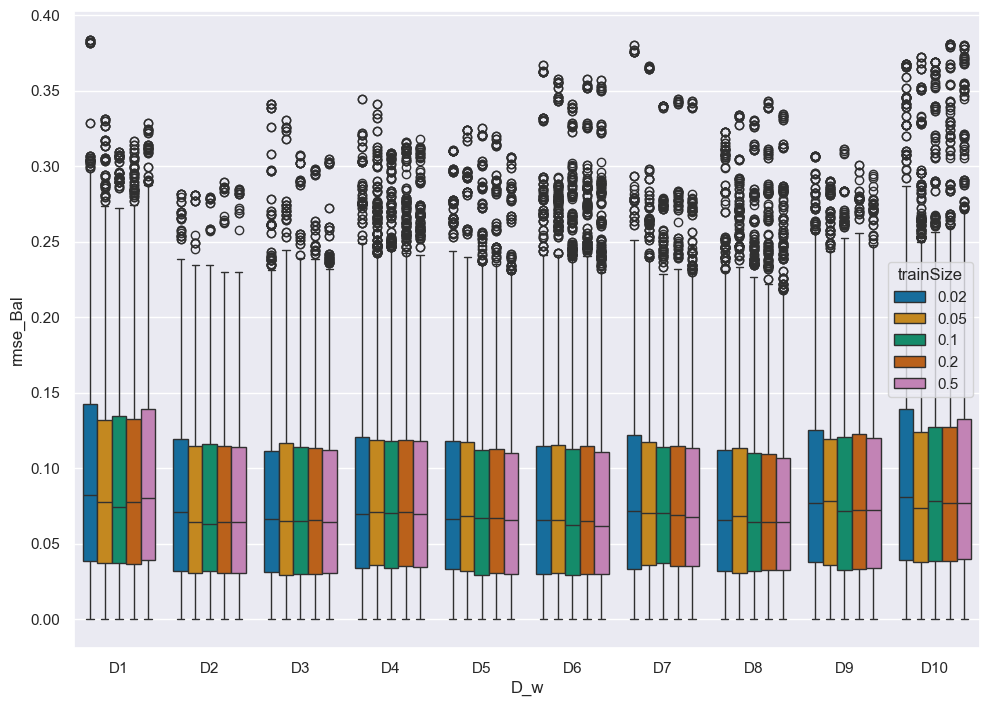

In [56]:
sns.boxplot(x='D_w', y='rmse_Bal',hue='trainSize', data=preds, palette='colorblind')
# plt.ylim(-1000, 15000)
plt.savefig(rep+'/boxplot_rmse_y_trainSize_Bal.png')

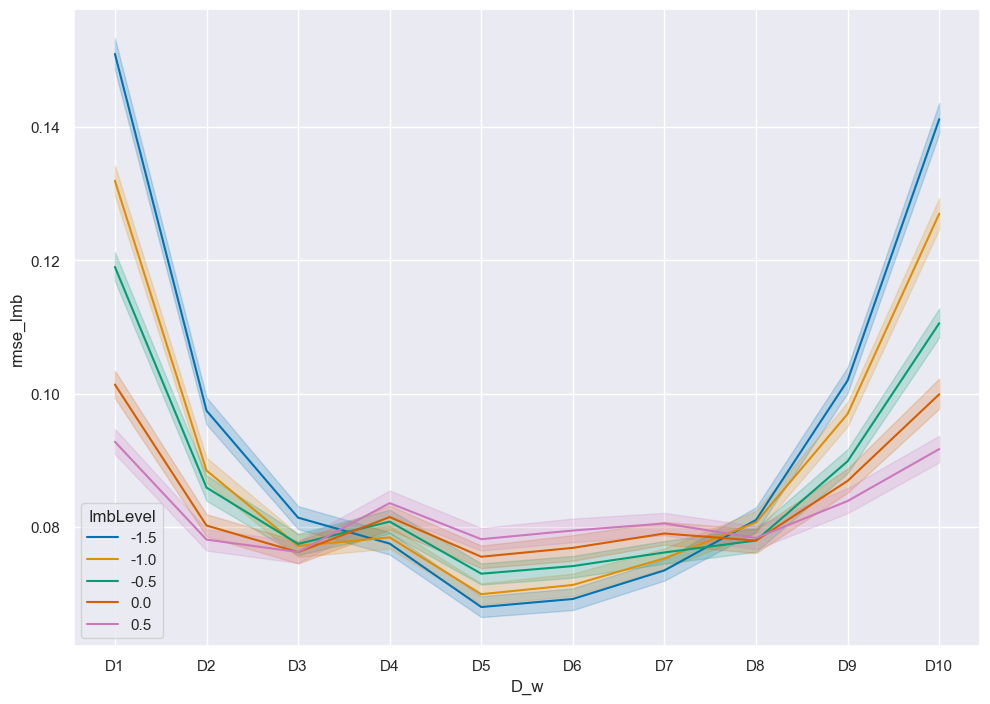

In [57]:
sns.lineplot(x='D_w', y='rmse_Imb',hue='ImbLevel', data=preds, palette='colorblind')
# plt.ylim(-1000, 15000)
plt.savefig(rep+'/lineplot_rmse_y_ImbLevel.png')

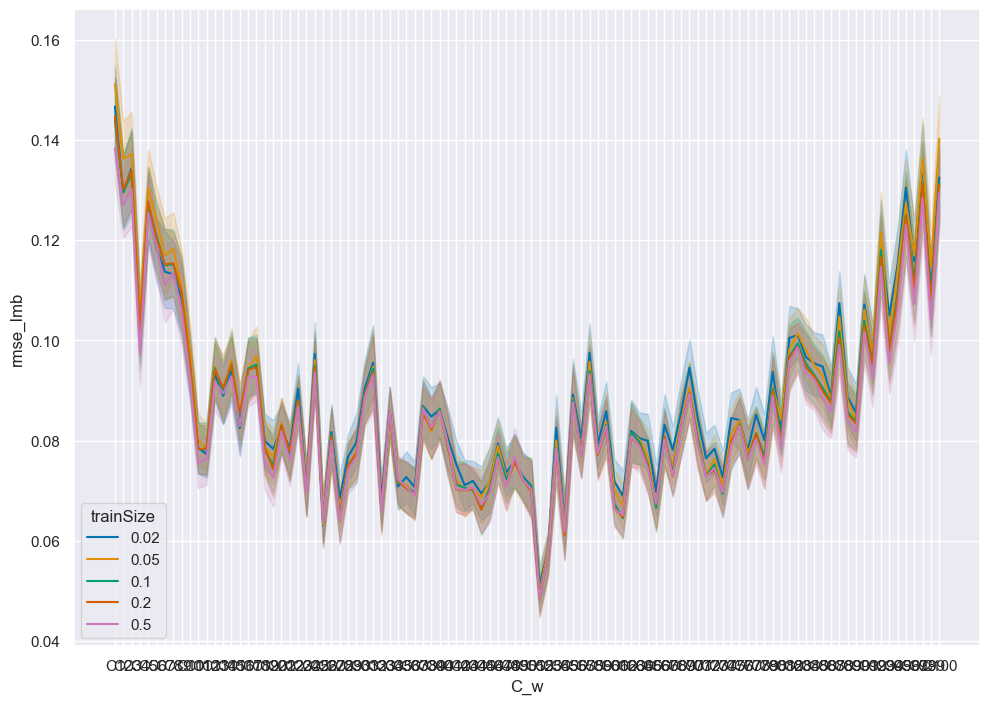

In [58]:
sns.lineplot(x='C_w', y='rmse_Imb',hue='trainSize', data=preds, palette='colorblind')
# plt.ylim(-1000, 15000)
plt.savefig(rep+'/lineplot_rmse_y_trainSize.png')

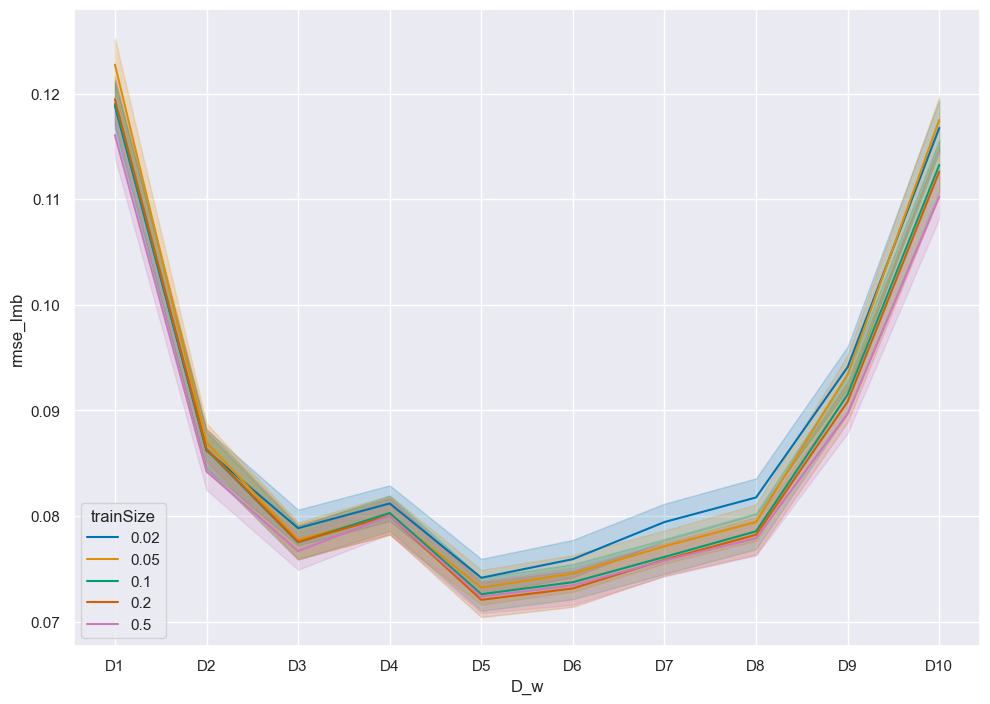

In [59]:
sns.lineplot(x='D_w', y='rmse_Imb',hue='trainSize', data=preds, palette='colorblind')
# plt.ylim(-1000, 15000)
plt.savefig(rep+'/lineplot_rmse_y_trainSize.png')

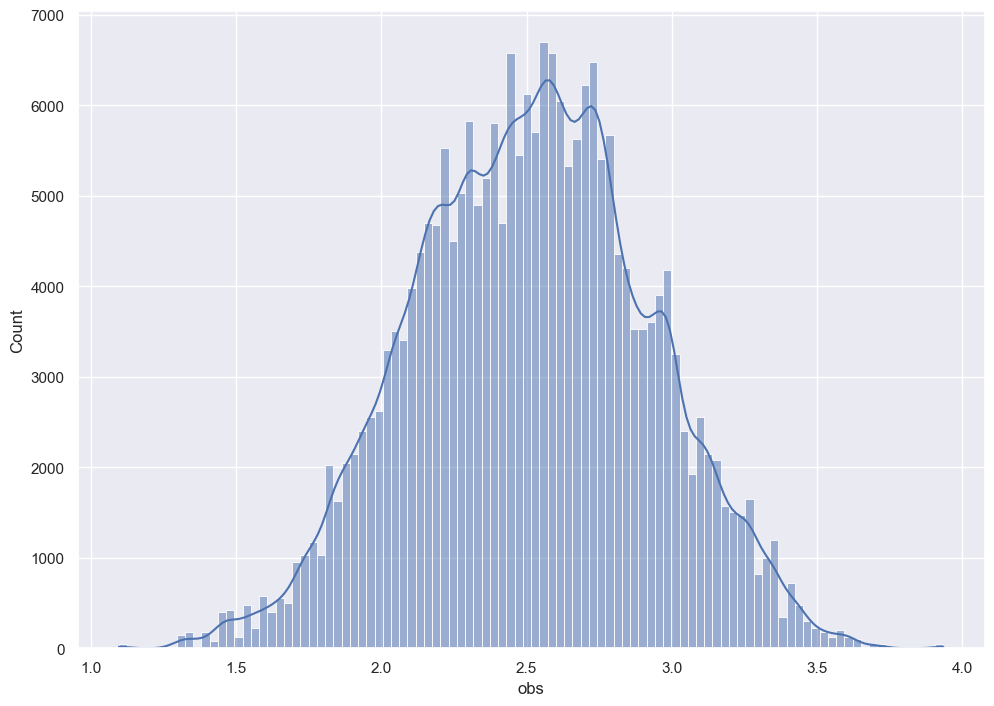

In [60]:
sns.histplot(preds.obs, kde=True,bins=100)
plt.savefig(rep+'/kde_ytest.png')

In [61]:
temp = preds.groupby('C_w').rmse_Imb.mean()
temp

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\3037430376.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = preds.groupby('C_w').rmse_Imb.mean()


C_w
C1      0.144927
C2      0.130483
C3      0.133759
C4      0.101705
C5      0.127431
          ...   
C96     0.126218
C97     0.112422
C98     0.132567
C99     0.108876
C100    0.132909
Name: rmse_Imb, Length: 100, dtype: float64

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\508939642.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=temp.index, y=temp.values, palette=sns.color_palette("RdYlGn_r", as_cmap=True, )(norm))
C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\508939642.py:6: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=temp.index, y=temp.values, palette=sns.color_palette("RdYlGn_r", as_cmap=True, )(norm))


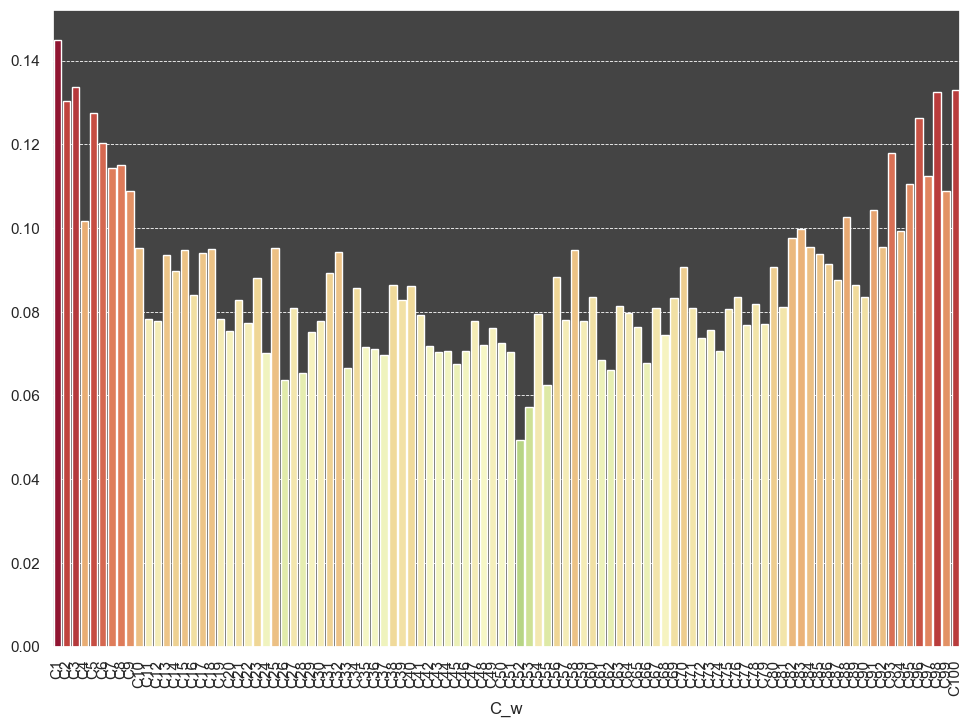

In [62]:
norm = temp.values / temp.values.max()
fig, ax = plt.subplots()
ax.set_facecolor("#444444")  
ax.grid(True, color="white", linestyle="--", linewidth=0.6)
plt.xticks(rotation=90)
sns.barplot(x=temp.index, y=temp.values, palette=sns.color_palette("RdYlGn_r", as_cmap=True, )(norm))
plt.savefig(rep+'/plot_rmse_y_centile.png')

In [63]:
temp_bal = preds.groupby('C_w').rmse_Bal.mean()
temp_bal

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\427454881.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_bal = preds.groupby('C_w').rmse_Bal.mean()


C_w
C1      0.092099
C2      0.092952
C3      0.098141
C4      0.074577
C5      0.098155
          ...   
C96     0.103788
C97     0.091693
C98     0.107288
C99     0.082390
C100    0.088403
Name: rmse_Bal, Length: 100, dtype: float64

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\404518347.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=temp_bal.index, y=temp_bal.values, palette=sns.color_palette("RdYlGn_r", as_cmap=True, )(norm_bal))
C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\404518347.py:6: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=temp_bal.index, y=temp_bal.values, palette=sns.color_palette("RdYlGn_r", as_cmap=True, )(norm_bal))


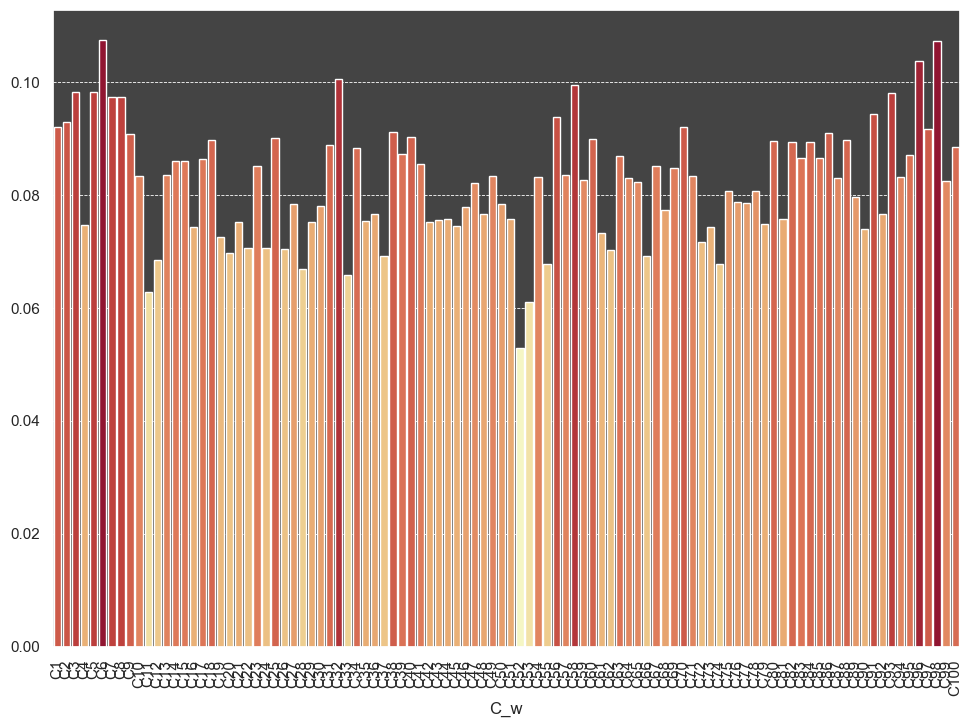

In [64]:
norm_bal = temp_bal.values / temp_bal.values.max()
fig, ax = plt.subplots()
ax.set_facecolor("#444444")
ax.grid(True, color="white", linestyle="--", linewidth=0.6)
plt.xticks(rotation=90)
sns.barplot(x=temp_bal.index, y=temp_bal.values, palette=sns.color_palette("RdYlGn_r", as_cmap=True, )(norm_bal))
plt.savefig(rep+'/plot_rmse_y_centile_Bal.png')

In [65]:
temp = preds.pivot_table(index=['D_w','ImbLevel'], values="rmse_Imb", aggfunc="mean").reset_index()

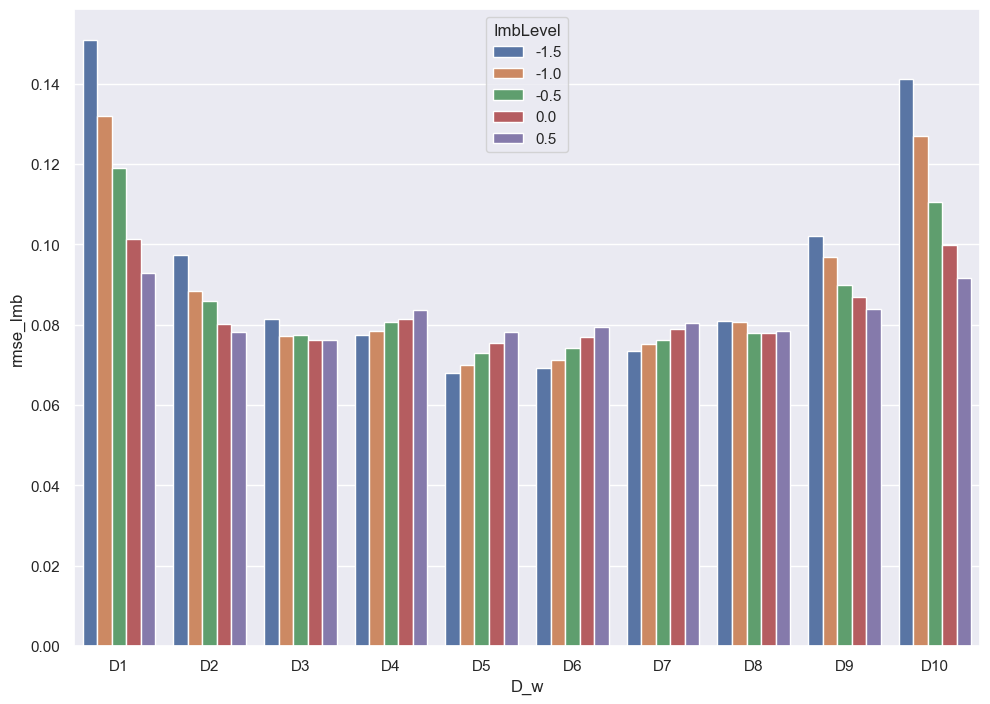

In [66]:
sns.barplot(data=temp, x='D_w', y='rmse_Imb', hue='ImbLevel', palette='deep')
plt.savefig(rep+'/plot_rmse_y_decile_Imb_ImbLevel.png')

In [67]:
temp = preds.pivot_table(index=['D_w','trainSize'], values="rmse_Imb", aggfunc="mean").reset_index()

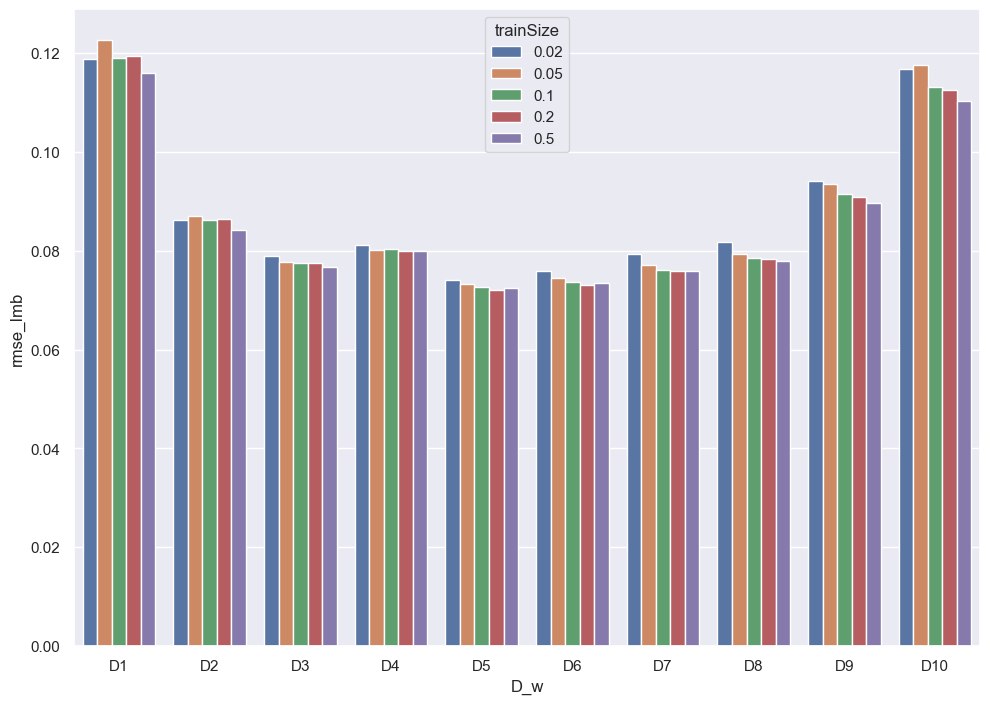

In [68]:
sns.barplot(data=temp, x='D_w', y='rmse_Imb', hue='trainSize', palette='deep')
plt.savefig(rep+'/plot_rmse_y_decile_Imb_trainSize.png')

#### Erreur vs w

In [69]:
Compl = 1

In [70]:
preds = res_preds_l.copy()
preds=pd.merge(res_MSE_l.drop(columns=['imb','bal']), preds, on='run', how='inner')
preds['mae_Imb'] = np.abs(preds.Imb-preds.obs)
preds['mae_Bal'] = np.abs(preds.Bal-preds.obs)
preds['rmse_Imb'] = np.sqrt((preds.Imb-preds.obs)**2)
preds['rmse_Bal'] = np.sqrt((preds.Bal-preds.obs)**2)
preds

run  Complexity  trainSize  ImbLevel  seed       obs        w_test  \
0          0           1       0.02       0.5   668  2.393184  8.927285e-04   
1          0           1       0.02       0.5   668  2.603184  8.626082e-04   
2          0           1       0.02       0.5   668  2.952597  8.947148e-04   
3          0           1       0.02       0.5   668  3.032681  9.389317e-04   
4          0           1       0.02       0.5   668  3.224732  1.063208e-03   
...      ...         ...        ...       ...   ...       ...           ...   
1124995  374           5       0.50      -1.5   160  0.340951  7.791708e-20   
1124996  374           5       0.50      -1.5   160  1.377084  5.044146e-30   
1124997  374           5       0.50      -1.5   160  1.592190  3.181836e-30   
1124998  374           5       0.50      -1.5   160  0.900571  1.185227e-28   
1124999  374           5       0.50      -1.5   160  0.490324  3.745768e-23   

              Imb       Bal   mae_Imb   mae_Bal  rmse_Imb  rmse_Bal  
0        2.238176  2.205121  0.155007  0.188062  0.155007  0.188062  
1        2.575051  2.558999  0.028133  0.044185  0.028133  0.044185  
2        3.176413  3.164221  0.223816  0.211623  0.223816  0.211623  
3        3.070621  3.073661  0.037940  0.040980  0.037940  0.040980  
4        3.202307  3.223985  0.022424  0.000746  0.022424  0.000746  
...           ...       ...       ...       ...       ...       ...  
1124995  0.306320  0.240651  0.034631  0.100300  0.034631  0.100300  
1124996  1.163932  1.164435  0.213152  0.212649  0.213152  0.212649  
1124997  1.345965  1.405712  0.246225  0.186478  0.246225  0.186478  
1124998  0.987317  0.956666  0.086746  0.056095  0.086746  0.056095  
1124999  0.534288  0.520256  0.043963  0.029932  0.043963  0.029932  

[1125000 rows x 13 columns]

In [71]:
preds = preds[preds.Complexity==Compl]

<Axes: xlabel='obs', ylabel='Count'>

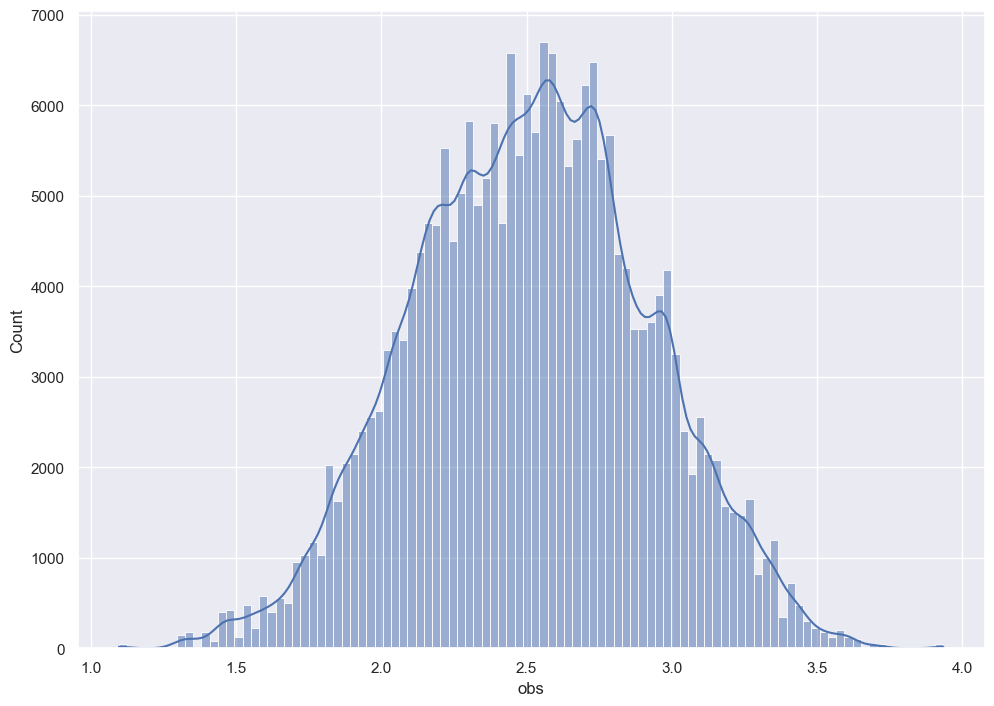

In [72]:
sns.histplot(preds.obs, kde=True,bins=100)

In [73]:
# kde_test = gaussian_kde(preds.obs)
# w_test = kde_test.evaluate(preds.obs)

<Axes: xlabel='obs', ylabel='w_test'>

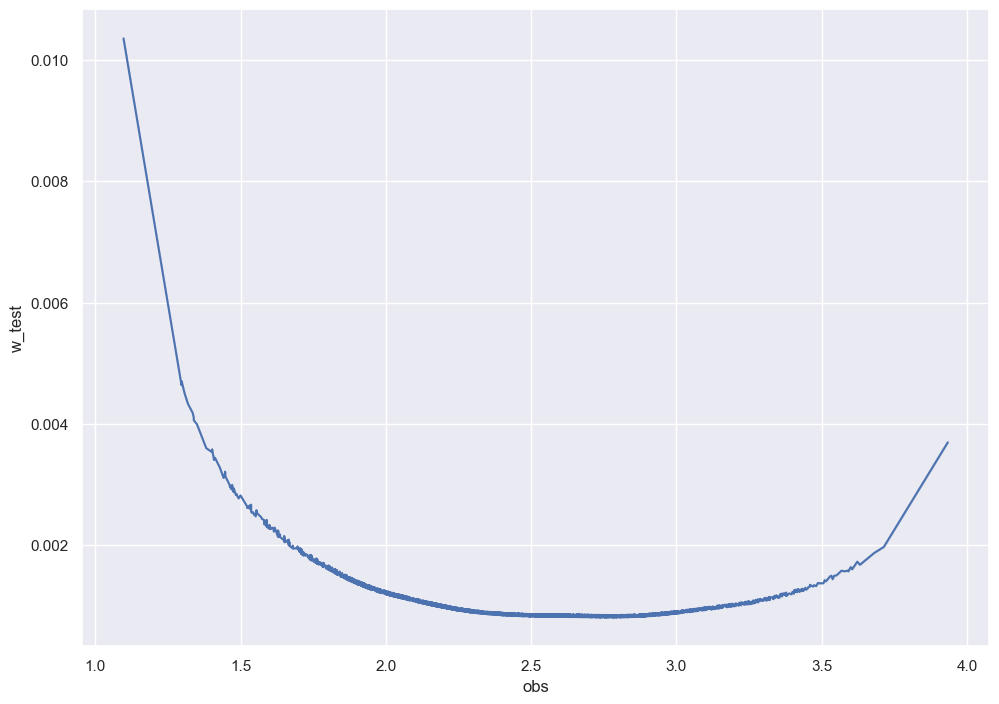

In [74]:
sns.lineplot(x=preds.obs, y=preds.w_test)

In [75]:
preds['D_w'] = pd.qcut(preds.w_test,10, labels=[f"D{i}" for i in range(1, 11)])
preds['C_w'] = pd.qcut(preds.w_test,100, labels=[f"C{i}" for i in range(1, 101)])

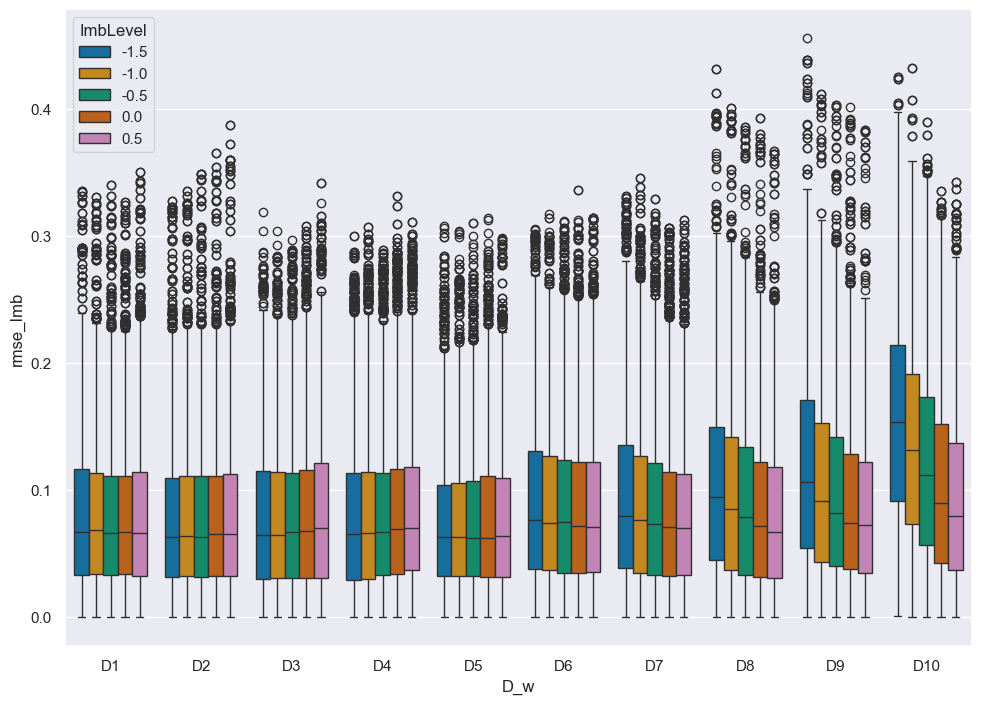

In [76]:
sns.boxplot(x='D_w', y='rmse_Imb',hue='ImbLevel', data=preds, palette='colorblind')
# plt.ylim(-1000, 15000)
plt.savefig(rep+'/boxplot_rmse_w_ImbLevel.png')

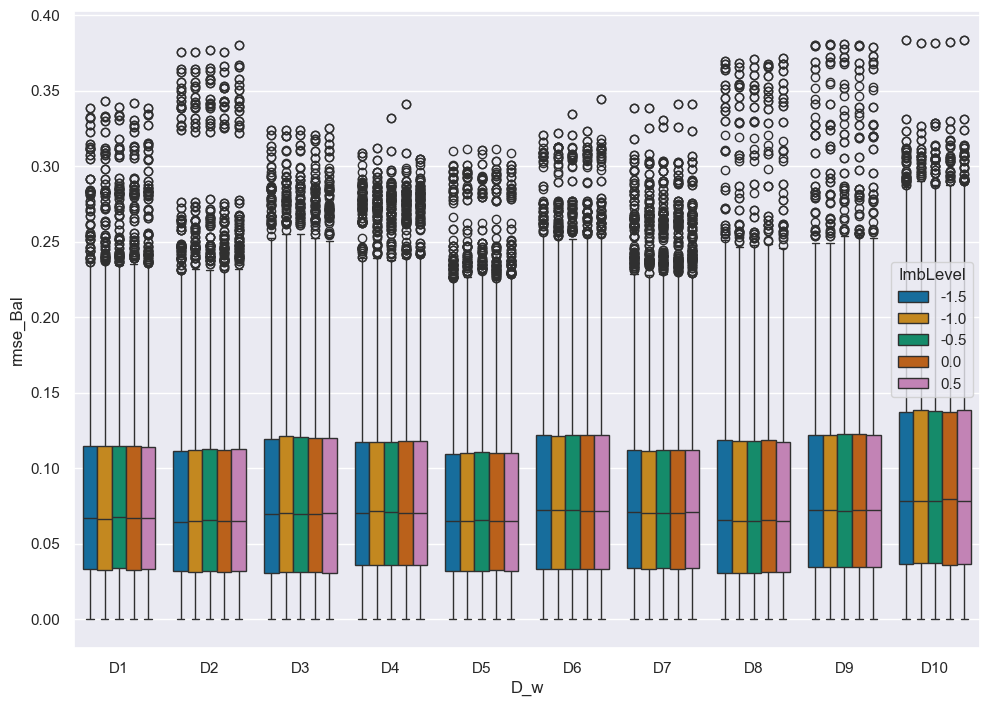

In [77]:
sns.boxplot(x='D_w', y='rmse_Bal',hue='ImbLevel', data=preds, palette='colorblind')
# plt.ylim(-1000, 15000)
plt.savefig(rep+'/boxplot_rmse_w_ImbLevel_Bal.png')

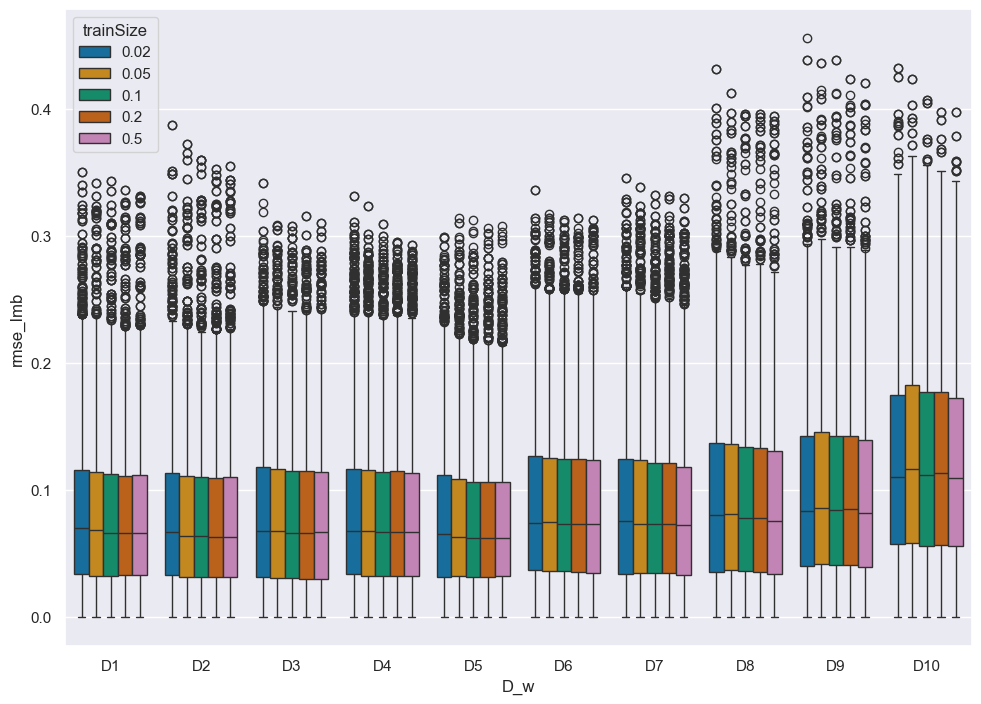

In [78]:
sns.boxplot(x='D_w', y='rmse_Imb',hue='trainSize', data=preds, palette='colorblind')
# plt.ylim(-1000, 15000)
plt.savefig(rep+'/boxplot_rmse_w_trainSize.png')

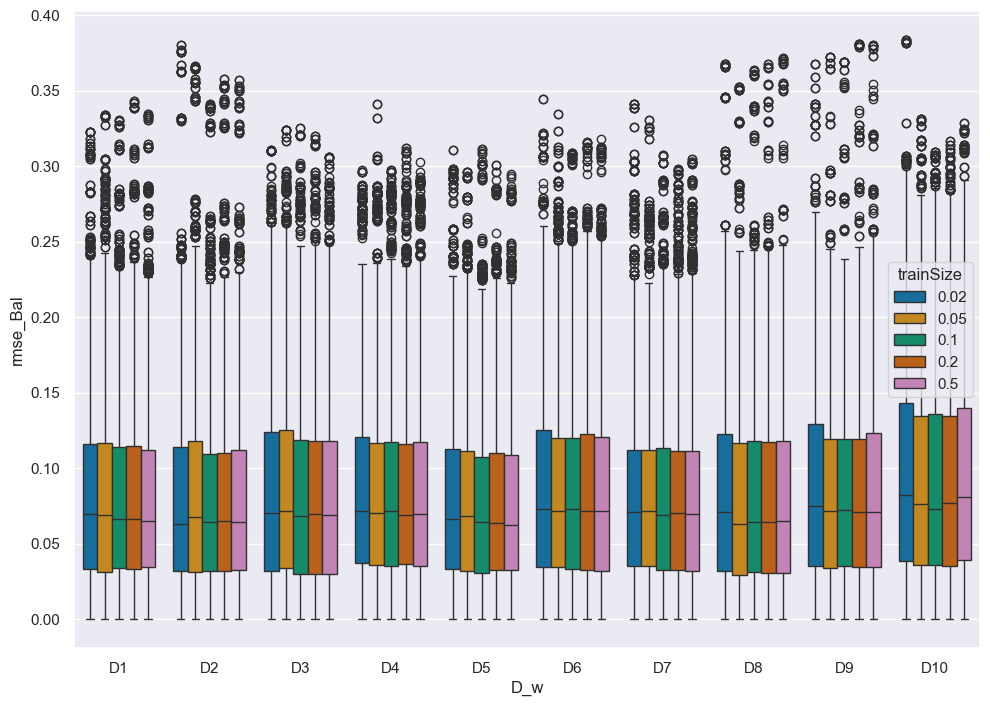

In [79]:
sns.boxplot(x='D_w', y='rmse_Bal',hue='trainSize', data=preds, palette='colorblind')
# plt.ylim(-1000, 15000)
plt.savefig(rep+'/boxplot_rmse_w_trainSize_Bal.png')

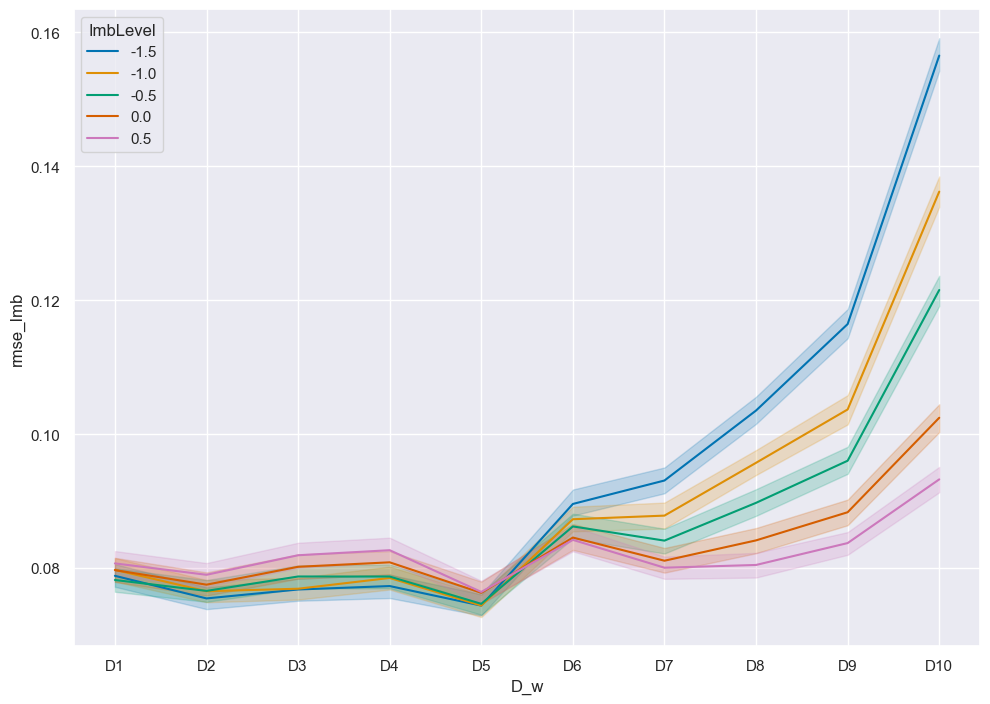

In [80]:
sns.lineplot(x='D_w', y='rmse_Imb',hue='ImbLevel', data=preds, palette='colorblind')
# plt.ylim(-1000, 15000)
plt.savefig(rep+'/lineplot_rmse_w_ImbLevel.png')

In [81]:
preds

run  Complexity  trainSize  ImbLevel  seed       obs    w_test  \
0          0           1       0.02       0.5   668  2.393184  0.000893   
1          0           1       0.02       0.5   668  2.603184  0.000863   
2          0           1       0.02       0.5   668  2.952597  0.000895   
3          0           1       0.02       0.5   668  3.032681  0.000939   
4          0           1       0.02       0.5   668  3.224732  0.001063   
...      ...         ...        ...       ...   ...       ...       ...   
1024995  274           1       0.50      -1.5   160  3.031703  0.000924   
1024996  274           1       0.50      -1.5   160  2.688604  0.000845   
1024997  274           1       0.50      -1.5   160  3.029787  0.000923   
1024998  274           1       0.50      -1.5   160  2.467616  0.000862   
1024999  274           1       0.50      -1.5   160  2.497914  0.000857   

              Imb       Bal   mae_Imb   mae_Bal  rmse_Imb  rmse_Bal D_w  C_w  
0        2.238176  2.205121  0.155007  0.188062  0.155007  0.188062  D6  C54  
1        2.575051  2.558999  0.028133  0.044185  0.028133  0.044185  D4  C40  
2        3.176413  3.164221  0.223816  0.211623  0.223816  0.211623  D6  C55  
3        3.070621  3.073661  0.037940  0.040980  0.037940  0.040980  D7  C64  
4        3.202307  3.223985  0.022424  0.000746  0.022424  0.000746  D8  C80  
...           ...       ...       ...       ...       ...       ...  ..  ...  
1024995  2.929932  2.969319  0.101771  0.062384  0.101771  0.062384  D7  C62  
1024996  2.821554  2.856174  0.132950  0.167570  0.132950  0.167570  D3  C25  
1024997  3.005247  3.057706  0.024540  0.027919  0.024540  0.027919  D7  C61  
1024998  2.401149  2.389909  0.066467  0.077706  0.066467  0.077706  D4  C39  
1024999  2.436815  2.418693  0.061099  0.079221  0.061099  0.079221  D4  C35  

[225000 rows x 15 columns]

In [82]:
spearmanr(preds[preds.ImbLevel==-1.].rmse_Imb, preds[preds.ImbLevel==-1.].w_test)

SignificanceResult(statistic=0.19246208863112413, pvalue=0.0)

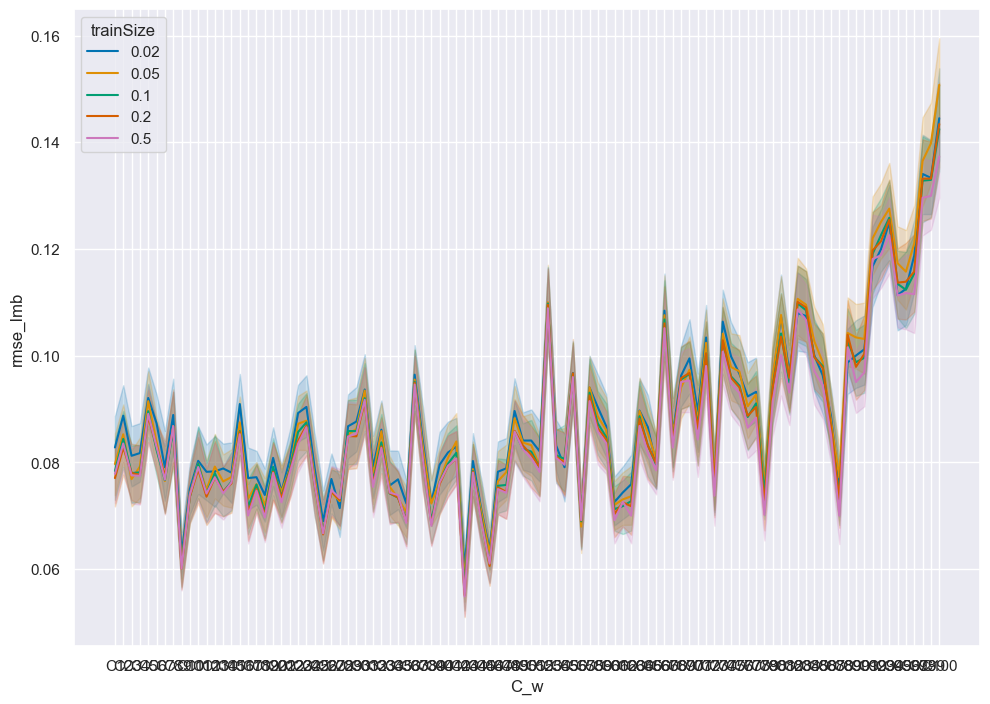

In [83]:
sns.lineplot(x='C_w', y='rmse_Imb',hue='trainSize', data=preds, palette='colorblind')
# plt.ylim(-1000, 15000)
plt.savefig(rep+'/lineplot_rmse_w_trainSize.png')

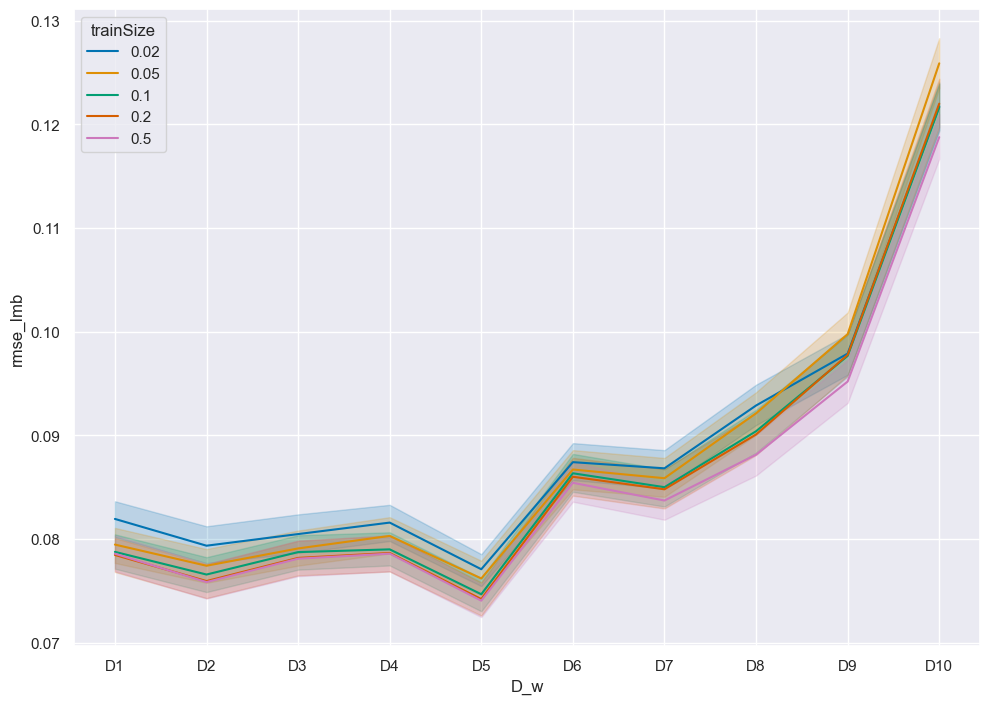

In [84]:
sns.lineplot(x='D_w', y='rmse_Imb',hue='trainSize', data=preds, palette='colorblind')
# plt.ylim(-1000, 15000)
plt.savefig(rep+'/lineplot_rmse_w_trainSize.png')

<Axes: xlabel='obs', ylabel='Count'>

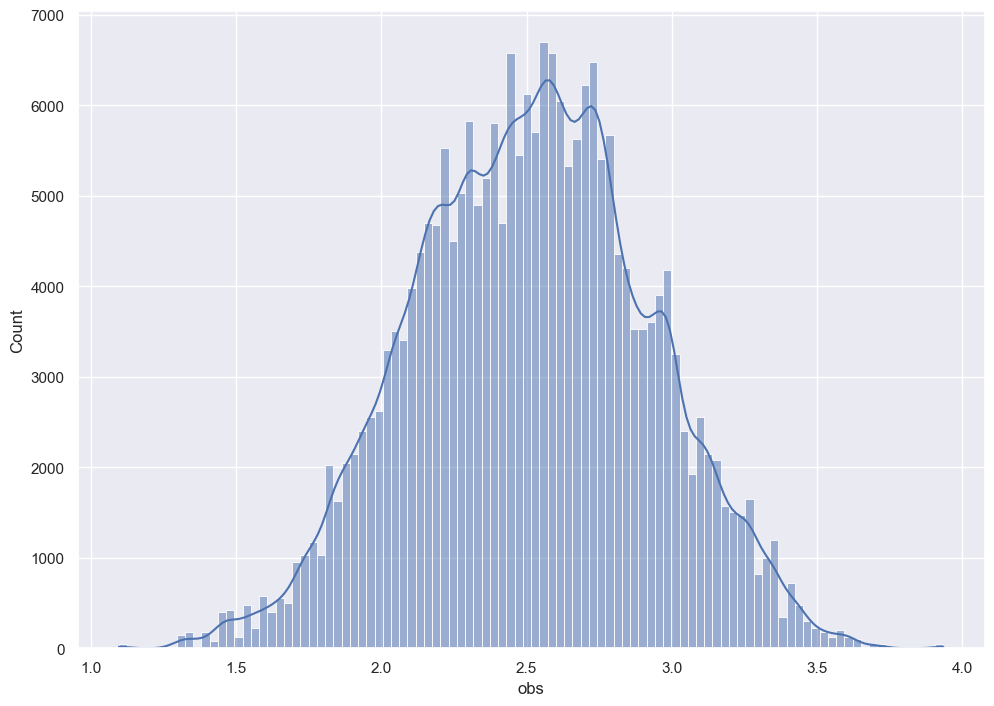

In [85]:
sns.histplot(preds.obs, kde=True,bins=100)
# plt.savefig(rep+'/kde_ytest.png')

In [86]:
temp = preds.groupby('C_w').rmse_Imb.mean()
temp

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\3037430376.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = preds.groupby('C_w').rmse_Imb.mean()


C_w
C1      0.079150
C2      0.084944
C3      0.078334
C4      0.078844
C5      0.090159
          ...   
C96     0.113244
C97     0.116502
C98     0.133226
C99     0.133834
C100    0.143693
Name: rmse_Imb, Length: 100, dtype: float64

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\1976196280.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=temp.index, y=temp.values, palette=sns.color_palette("RdYlGn_r", as_cmap=True, )(norm))
C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\1976196280.py:6: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=temp.index, y=temp.values, palette=sns.color_palette("RdYlGn_r", as_cmap=True, )(norm))


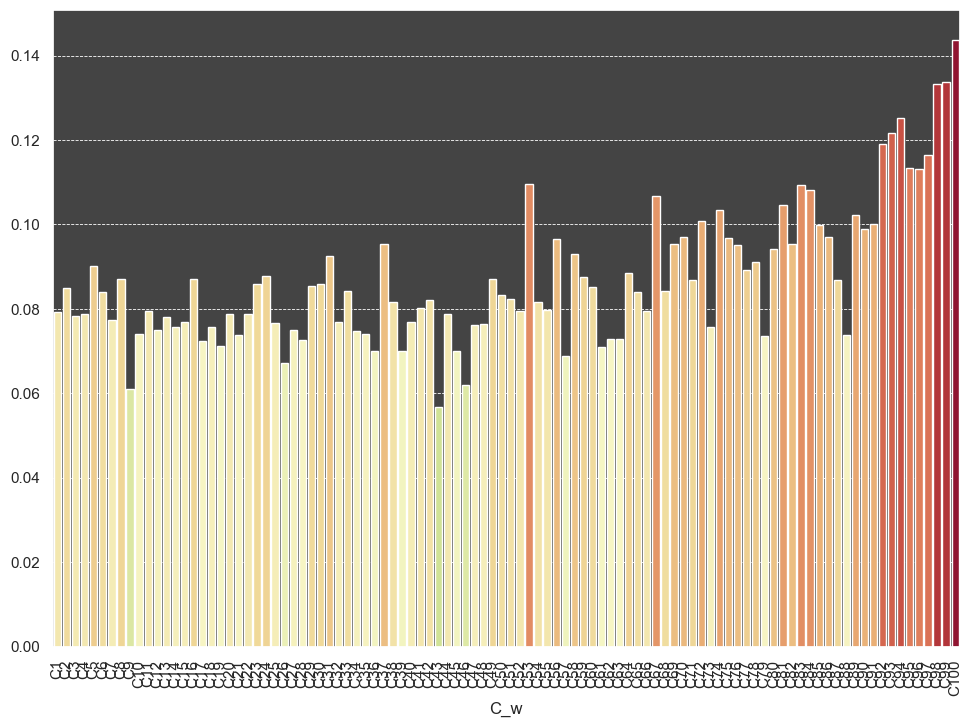

In [87]:
norm = temp.values / temp.values.max()
fig, ax = plt.subplots()
ax.set_facecolor("#444444")  
ax.grid(True, color="white", linestyle="--", linewidth=0.6)
plt.xticks(rotation=90)
sns.barplot(x=temp.index, y=temp.values, palette=sns.color_palette("RdYlGn_r", as_cmap=True, )(norm))
plt.savefig(rep+'/plot_rmse_w_centile.png')

In [88]:
temp_bal = preds.groupby('C_w').rmse_Bal.mean()
temp_bal

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\427454881.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_bal = preds.groupby('C_w').rmse_Bal.mean()


C_w
C1      0.074397
C2      0.084177
C3      0.081999
C4      0.084198
C5      0.097032
          ...   
C96     0.084499
C97     0.082249
C98     0.099248
C99     0.093216
C100    0.091483
Name: rmse_Bal, Length: 100, dtype: float64

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\3757552641.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=temp_bal.index, y=temp_bal.values, palette=sns.color_palette("RdYlGn_r", as_cmap=True, )(norm_bal))
C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\3757552641.py:6: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=temp_bal.index, y=temp_bal.values, palette=sns.color_palette("RdYlGn_r", as_cmap=True, )(norm_bal))


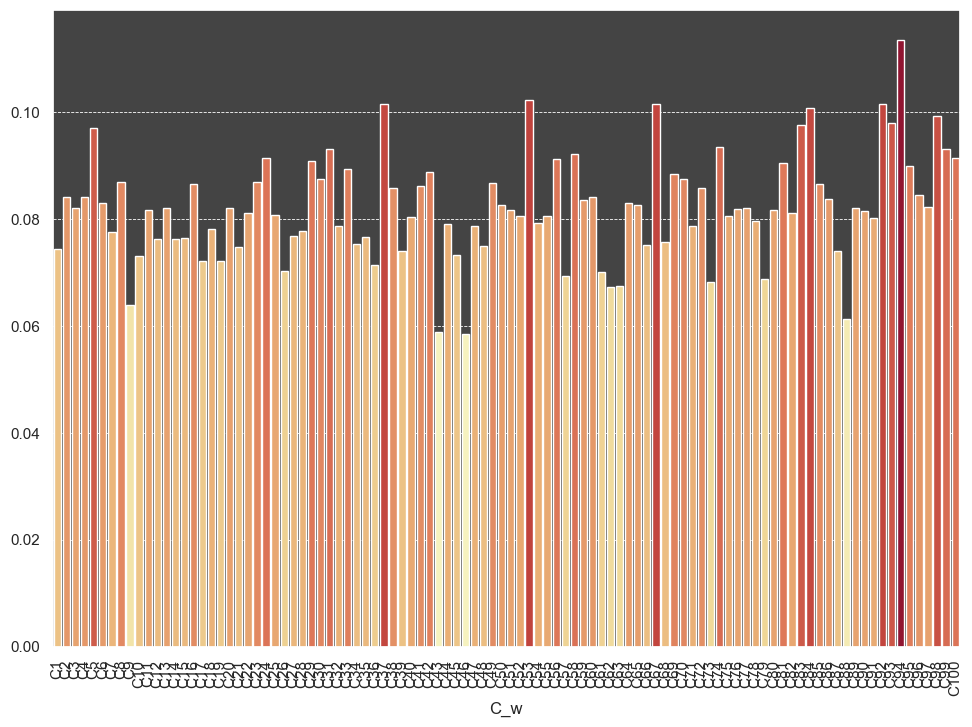

In [89]:
norm_bal = temp_bal.values / temp_bal.values.max()
fig, ax = plt.subplots()
ax.set_facecolor("#444444")
ax.grid(True, color="white", linestyle="--", linewidth=0.6)
plt.xticks(rotation=90)
sns.barplot(x=temp_bal.index, y=temp_bal.values, palette=sns.color_palette("RdYlGn_r", as_cmap=True, )(norm_bal))
plt.savefig(rep+'/plot_rmse_w_centile_Bal.png')

In [90]:
temp = preds.pivot_table(index=['D_w','ImbLevel'], values="rmse_Imb", aggfunc="mean").reset_index()

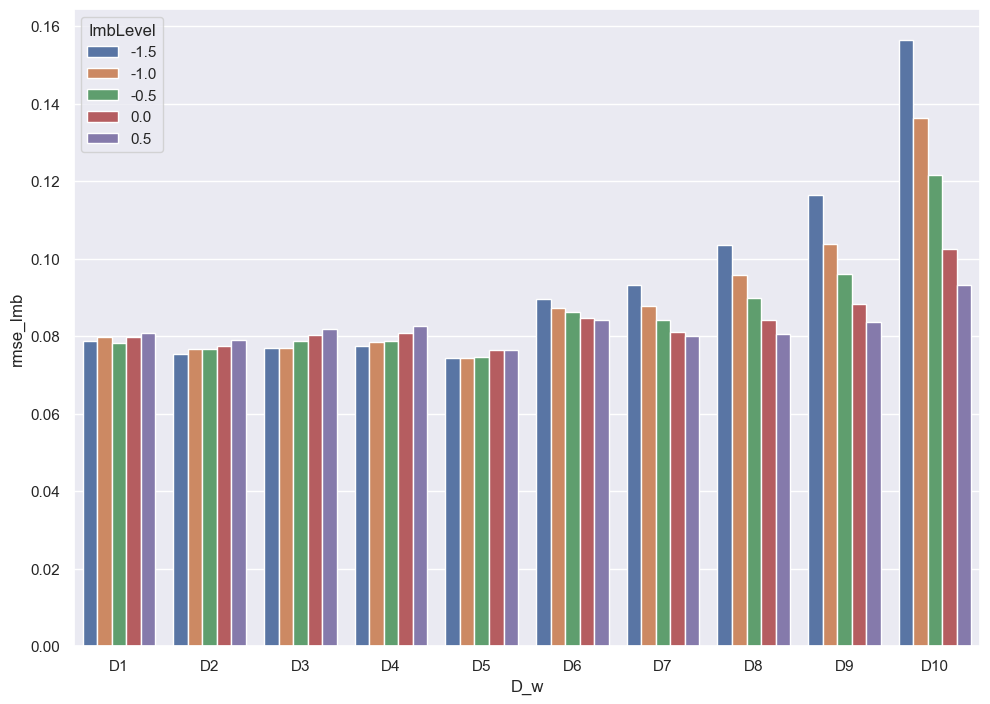

In [91]:
sns.barplot(data=temp, x='D_w', y='rmse_Imb', hue='ImbLevel', palette='deep')
plt.savefig(rep+'/plot_rmse_w_decile_Imb_ImbLevel.png')

In [92]:
temp = preds.pivot_table(index=['D_w','trainSize'], values="rmse_Imb", aggfunc="mean").reset_index()

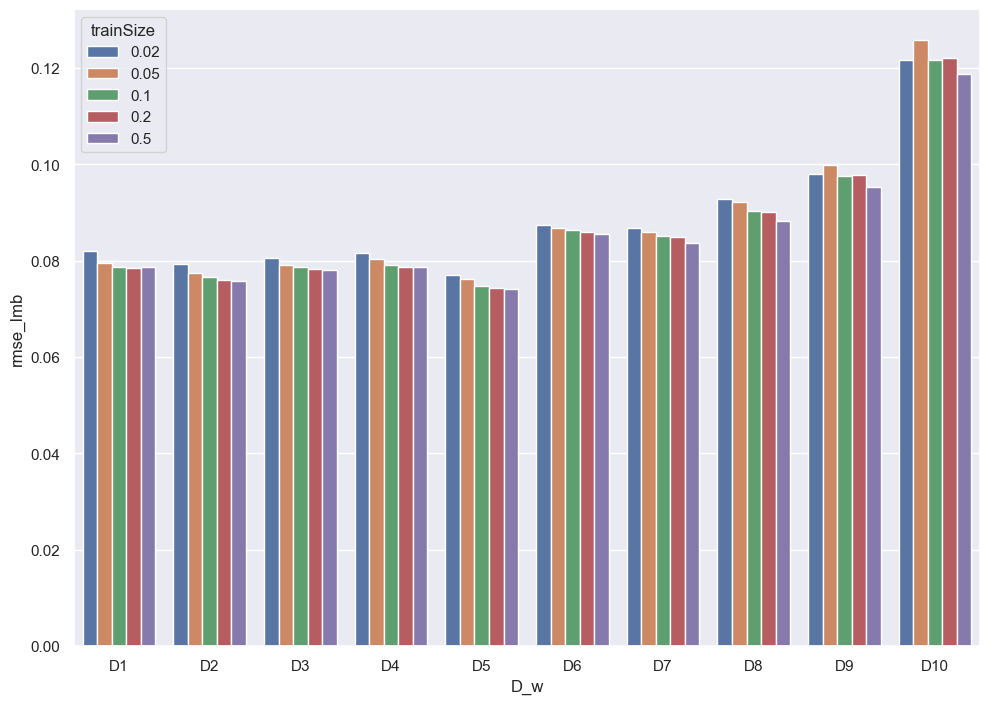

In [93]:
sns.barplot(data=temp, x='D_w', y='rmse_Imb', hue='trainSize', palette='deep')
plt.savefig(rep+'/plot_rmse_w_decile_Imb_trainSize.png')

#### Focus

In [ ]:
filtre = (res_ytrain_l.ImbLevel==-0.5)&(res_ytrain_l.trainSize==0.2)&(res_ytrain_l.Complexity==1)

In [ ]:
sns.histplot(res_ytrain_l[filtre].y_train, kde=True,bins=100)

In [ ]:
temp = preds[ (preds.ImbLevel==-0.5)&(preds.trainSize==0.2)&(preds.Complexity==1)].groupby('C_w').rmse_Imb.mean()

In [ ]:
norm = temp.values / temp.values.max()
fig, ax = plt.subplots()
ax.set_facecolor("#444444")
ax.grid(True, color="white", linestyle="--", linewidth=0.6)
plt.xticks(rotation=90)
sns.barplot(x=temp.index, y=temp.values, palette=sns.color_palette("autumn_r", as_cmap=True, )(norm))

In [ ]:
preds_focus = preds[preds.ImbLevel==-1.5]
seed_samples = preds_focus.seed.unique()
seed_samples

In [ ]:
res_ytrain_l = []
simu = 0
for k in range(5):
    seed_sample = seed_samples[k]
    np.random.seed(seed_sample)
    random.seed(int(seed_sample))
    
    for compl in complS:
        for imb in imbS:
            for trainsize in trainsizeS:
                print("============================     simu : ",simu,"          ======================")
                print("graine = ", seed_sample)
                
                # data
                data = simu_data(n, graine=seed_sample, c=compl)

                # Train-test sampling
                w_Y_data=IR_weighting(data[lab_Y], plot=False, alpha=alpha)
                split = trainTest(data,test_size,seed_sample,w_test=w_Y_data,train_size=trainsize, imbForce=imb)
                X_train = split['X_train']
                X_test = split['X_test']
                X_bal = split['X_bal']
                y_train =  X_train[[lab_Y]]
                
                res_ytrain = pd.DataFrame({'y_train':y_train[lab_Y]})
                res_ytrain['run'] = simu
                res_ytrain['Complexity'] = compl
                res_ytrain['trainSize'] = trainsize
                res_ytrain['ImbLevel'] = imb
                res_ytrain['seed'] = seed_sample
                
                if len(res_ytrain_l)==0:
                    res_ytrain_l =  res_ytrain
                else:
                    res_ytrain_l  = pd.concat([res_ytrain_l, res_ytrain])
                simu +=1
                

In [ ]:
res_ytrain_l.to_csv(rep+'/res_ytrain_l.csv',index=False)

In [ ]:
res_ytrain_l.seed.unique()

In [ ]:
sns.histplot(res_ytrain_l[res_ytrain_l.ImbLevel==-1.5].y_train, kde=True,bins=100)

In [ ]:
temp_bal = preds[preds.ImbLevel==-1.5].groupby('C_w').rmse_Imb.mean()
temp_bal

norm_bal = temp_bal.values / temp_bal.values.max()
fig, ax = plt.subplots()
ax.set_facecolor("#777777")
ax.grid(True, color="white", linestyle="--", linewidth=0.6)
plt.xticks(rotation=90)
sns.barplot(x=temp_bal.index, y=temp_bal.values, palette=sns.color_palette("RdYlGn_r", as_cmap=True, )(norm_bal))
plt.savefig(rep+'/plot_rmse_w_centile_Bal.png')

#### Significance test

In [102]:
from scipy.stats import wilcoxon

In [146]:
res_wilcoxon = pd.DataFrame(columns=["ImbLevel" ,  'trainSize', 'wilcoxon'])

for imb in imbS:
    for trainsize in trainsizeS:
        temp = res_MSE_l[(res_MSE_l.ImbLevel == imb) & (res_MSE_l.trainSize == trainsize)]
        res = pd.DataFrame({"ImbLevel" : [imb],  'trainSize' : [trainsize], 'wilcoxon':[wilcoxon(temp.imb, temp.bal)[1]]})
        res_wilcoxon = pd.concat([res_wilcoxon, res])

C:\Users\samgo\AppData\Local\Temp\ipykernel_17620\3438300875.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_wilcoxon = pd.concat([res_wilcoxon, res])


In [147]:
res_wilcoxon

ImbLevel  trainSize      wilcoxon
0       0.5       0.02  2.996123e-01
0       0.5       0.05  2.199864e-01
0       0.5       0.10  5.424044e-01
0       0.5       0.20  6.720752e-01
0       0.5       0.50  1.817299e-01
0       0.0       0.02  7.098365e-02
0       0.0       0.05  2.498031e-04
0       0.0       0.10  5.960464e-07
0       0.0       0.20  1.192093e-07
0       0.0       0.50  2.980232e-07
0      -0.5       0.02  8.165836e-06
0      -0.5       0.05  2.980232e-07
0      -0.5       0.10  5.960464e-08
0      -0.5       0.20  5.960464e-08
0      -0.5       0.50  5.960464e-08
0      -1.0       0.02  5.960464e-07
0      -1.0       0.05  5.960464e-08
0      -1.0       0.10  5.960464e-08
0      -1.0       0.20  5.960464e-08
0      -1.0       0.50  5.960464e-08
0      -1.5       0.02  5.960464e-08
0      -1.5       0.05  5.960464e-08
0      -1.5       0.10  5.960464e-08
0      -1.5       0.20  5.960464e-08
0      -1.5       0.50  5.960464e-08

<Axes: xlabel='ImbLevel', ylabel='wilcoxon'>

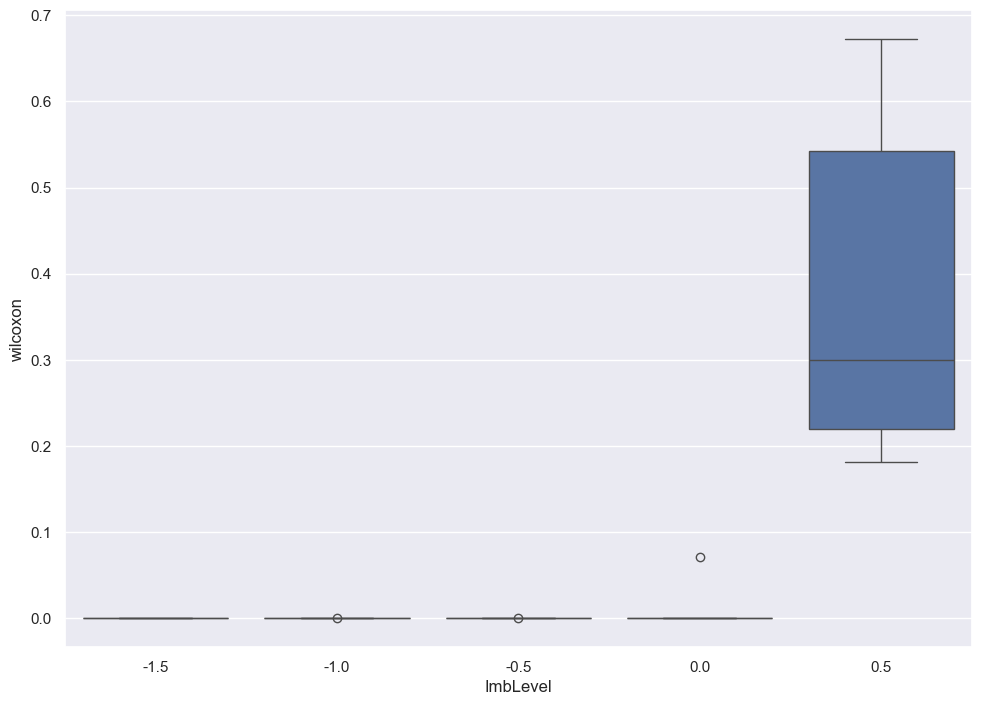

In [148]:
sns.boxplot(x=res_wilcoxon.ImbLevel, y = res_wilcoxon.wilcoxon)

#### res_aml

In [149]:
for metric in ['res_aml_l']:
    run1 = pd.read_csv(rep+"/1-2/"+metric+".csv", index_col=0)
    run234 = pd.read_csv(rep+"/3-4-5/"+metric+".csv", index_col=0) 
    runs = pd.concat([run1,run234])
    runs.to_csv(rep+"/"+metric+".csv", index=False)

In [150]:
res_aml_l = pd.read_csv(rep+"/res_aml_l.csv")

In [154]:
res_aml_l["model"] = res_aml_l["model_id"].str.split("_").str[0]
res_aml_l.drop(columns='model_id', inplace=True)
res_aml_l

rmse       mse       mae     rmsle  mean_residual_deviance train  \
0      0.106344  0.011309  0.084145  0.031042                0.011309   imb   
1      0.107918  0.011646  0.085147  0.031449                0.011646   imb   
2      0.109079  0.011898  0.085584  0.031828                0.011898   imb   
3      0.152244  0.023178  0.121445  0.043662                0.023178   imb   
4      0.153898  0.023685  0.120746  0.044018                0.023685   imb   
...         ...       ...       ...       ...                     ...   ...   
14995  0.109070  0.011896  0.086802  0.065164                0.011896   bal   
14996  0.109290  0.011944  0.086822  0.065390                0.011944   bal   
14997  0.109290  0.011944  0.086870  0.065579                0.011944   bal   
14998  0.109649  0.012023  0.087169  0.065505                0.012023   bal   
14999  0.124776  0.015569  0.099158  0.075619                0.015569   bal   

       run  Complexity  trainSize  ImbLevel  seed            model  
0        0           1       0.02       0.5   668              GLM  
1        0           1       0.02       0.5   668  StackedEnsemble  
2        0           1       0.02       0.5   668  StackedEnsemble  
3        0           1       0.02       0.5   668              GBM  
4        0           1       0.02       0.5   668              GBM  
...    ...         ...        ...       ...   ...              ...  
14995  374           5       0.50      -1.5   160              DRF  
14996  374           5       0.50      -1.5   160              XRT  
14997  374           5       0.50      -1.5   160     DeepLearning  
14998  374           5       0.50      -1.5   160              GBM  
14999  374           5       0.50      -1.5   160              GLM  

[15000 rows x 12 columns]

<Axes: xlabel='ImbLevel', ylabel='mae'>

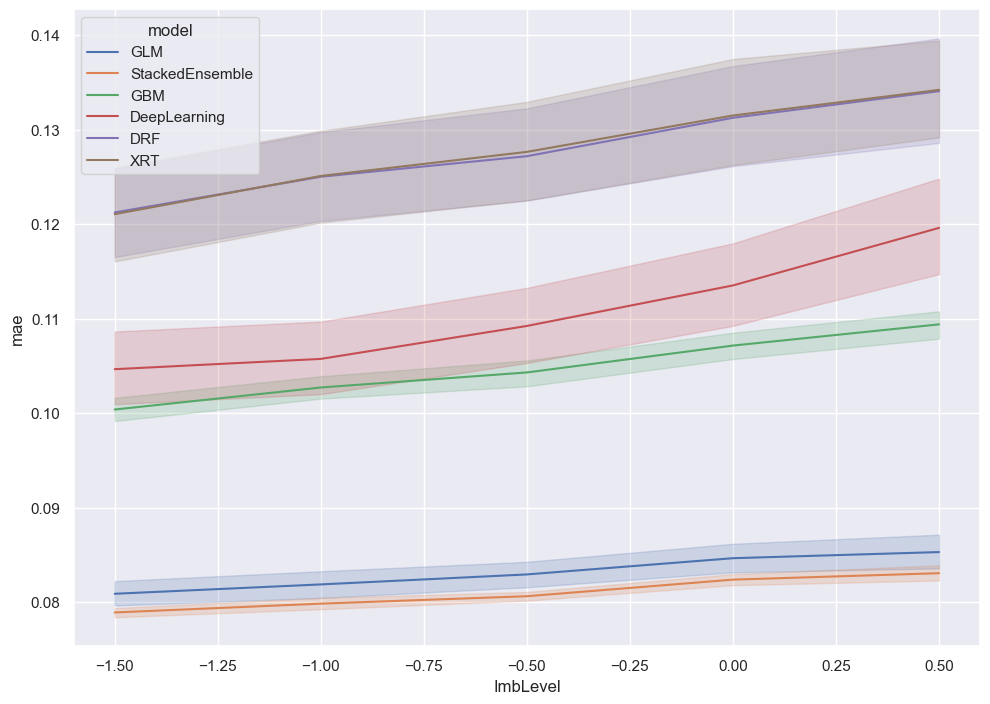

In [169]:
filtre = (res_aml_l.train=='imb')
sns.lineplot(y=res_aml_l[filtre].mae, x= res_aml_l[filtre].ImbLevel, hue=res_aml_l[filtre].model)